# Electrical impedance tomography phantom reconstruction noise analysis


This notebook is for the debugging process and generating a sequence of code that analyses the voltage measurement data of a known phantom and compares it to simulated data. 

**Part A:**
First we analyse the voltage measurements with code that:
1. generates a simulated resistor network domain
2. gives the noise of a real measurement sequence vs. simulated EIT voltage measurements  (MSE, Rsqr, SNR)
3. generates a noise model from the measurements

**Part B:**
Then we use EIDORS reconstruction and noise analysis to:
1. reconstruct with voltage data using the Matlab EIDORS toolbox
    1. simluated voltage data
    2. simluated voltage data with modelled noise
    3. real voltage data
2. analyse the EIDORS reconstruction of the simulated and the real measurements in terms of:
    1. Error per element
    2. Mean square error $MSE=\frac{1}{n}\Sigma(y−\hat y)^2$
    3. $R^2$ value $R^2=1-\frac{MSE}{Var(y)}$
    4. Repeat for the actual change in resistance vs. the EIT reconstructions


**Part C:**
Check whether SNR observed in piezoresistive samples is likely to have a poor reconstruction  

</br>

*Notes:*

*Non python reqs: EIDORS, netlist for a resistor network, Matlab install, square_recon() Matlab function*

*Python reqs: Download all imported modules using pip install + homemade ert_mesh_sim.py module*

In [1]:
# Some useful functions to load for analysis:

def remove_inj_meas(raw_EIT_data, skip_elecs=1):
    # removes current injection electrodes assuming adjacent current
    #  injection pattern of a 16 electrode device where the data[0] is the
    #  first item to remove.
    # skip_elecs = 0 or 1 only.
    fil_EIT_data = []
    for i in range(skip_elecs+1,len(raw_EIT_data)-1):
        j = i+1
        if (j % 16 and j % (16+skip_elecs) and j % (16-skip_elecs)):
            fil_EIT_data.append(raw_EIT_data[i])
    
    return fil_EIT_data

def get_Radj_data(raw_EIT_data_V, i_src_A, num_elecs=16):
    # Iterates through voltage data and determines all adjacent electrode resistances
    num_cycles = len(raw_EIT_data_V)//(num_elecs**2)
    R_elec_arr = np.zeros(((num_elecs*num_cycles),1))
    cycle = 0
    for i in range(len(raw_EIT_data_V)):
        if not (i % (num_elecs+1)):
            cycle = i // num_elecs**2
            R_elec_arr[i//(num_elecs)] = abs(raw_EIT_data_V[i+cycle])/i_src_A
    R_elec_arr_ = np.reshape(R_elec_arr,(num_cycles,num_elecs))
    R_elec_arr_[1][0] = R_elec_arr_[0][0]
    for cycle in range(2,num_cycles):
        R_elec_arr_[cycle][1:cycle] = R_elec_arr_[cycle][0:cycle-1]
        R_elec_arr_[cycle][0] = R_elec_arr_[0][0]
    R_elec_arr_[-1][-1] = R_elec_arr_[-2][-1]
    return R_elec_arr_

def calc_vmeas_noise(elec_data_orig, elec_data_vmeas_l, elec_cycles, main_title="", plot=True, error_ref_data='sim'):
    '''
    Function that takes a 'clean' original data and a 'noisy' measured dataset then calculates error and outputs:
    - an error array 
    - a SNR array

    then if plot==True, plots:
    1. The measurement and the simulation/mean data in time
    2. The measurement error
    3. A distirbution of the measurment error data
    4. Measurement error vs measurment data
    5. Percentage error vs measurement data
    6. Measurement data vs the simulation/mean data

    Using 'error_ref_data' choose a string defining your error reference dataset (e.g. mean data, simulated data) 

    '''
    skip_elecs = 1
    elec_er_data_l = np.array([])
    elec_snr_data_l = np.array([])
    elec_mean_data =np.zeros((256,))
    print("num of elec cycles %d" % elec_cycles)
    for i in range(elec_cycles):
        elec_mean_data = elec_mean_data + np.array(elec_data_vmeas_l[i*num_elecs**2:(i+1)*num_elecs**2])
    elec_mean_data = elec_mean_data / elec_cycles
    for i in range(elec_cycles):
        elec_data_er = elec_mean_data - elec_data_vmeas_l[i*num_elecs**2:(i+1)*num_elecs**2] # calc the mean error
        elec_data_snr = np.abs(elec_mean_data) / np.abs(elec_data_er) # calc mean shifted SNR
        elec_er_data_l = np.append(elec_er_data_l, elec_data_er)
        elec_snr_data_l = np.append(elec_snr_data_l, elec_data_snr)

    
    # neutralise SNR error outlier at index 0
    elec_er_data_l[0] = elec_er_data_l[1]

    # remove injection electrodes
    elec_er_data_l = remove_inj_meas(elec_er_data_l)
    elec_snr_data_l = remove_inj_meas(elec_snr_data_l) 

    if plot:
        plt.figure(figsize=(20,10))

        ax1 = plt.subplot(2,3,1)
        # ax1.plot(elec_data_vmeas_l,'r-',label='meas')
        # ax1.plot(list(elec_data_orig)*elec_cycles,'.',label=error_ref_data)
        ax1.plot((elec_data_vmeas_l[0:num_elecs**2]),'r-',label='meas')
        ax1.plot(remove_inj_meas(elec_data_orig),'.',label=error_ref_data)
        plt.title(f"1 - {error_ref_data} vs vmeas ERT measurements")
        plt.xlabel("reading [n]")
        plt.ylabel('voltage [V]')
        plt.legend()
        ax2 = plt.subplot(2,3,2)
        # ax2.plot(elec_er_data_l)
        ax2.plot(elec_er_data_l[0:num_elecs**2])
        plt.title(f"2 - {error_ref_data} vs vmeas ERT measurements error")
        plt.xlabel("reading [n]")
        plt.ylabel('error [V]')
        ax3 = plt.subplot(2,3,3)
        ax3.hist(elec_er_data_l,bins=40)
        plt.title(f"3 - {error_ref_data} vs vmeas ERT measurements error freq")
        plt.xlabel('error [V]')
        plt.ylabel('counts [n]')

        ax4 = plt.subplot(2,3,4)
        ax4.plot((elec_data_vmeas_l[0:len(elec_er_data_l)]),(elec_er_data_l),'.')
        plt.title("4 - Measurement vs measurment error")
        plt.xlabel('measurement [V]')
        plt.ylabel('error [V]')
        ax5 = plt.subplot(2,3,5)
        # ax5.plot((elec_data_orig),100*elec_data_er/elec_data_orig,'.')
        # plt.title("5 - Measurement vs % measurment error")
        # plt.xlabel('Measurement [V]')
        # plt.ylabel('% error [%]')
        # plt.ylim(0,1e-1)
        ax5.plot(elec_snr_data_l[0:len(elec_data_vmeas_l)],'.')
        plt.title("5 - Reading vs SNR")
        plt.title(f"5 -  vs measurment error")
        plt.xlabel("reading [n]")
        plt.ylabel('SNR')
        plt.ylim(0,1e2)
        ax6 = plt.subplot(2,3,6)
        ax6.plot(remove_inj_meas(elec_data_vmeas_l), elec_snr_data_l[0:len(elec_data_vmeas_l)],'.')
        plt.title("6 - SNR over one cyle")
        plt.xlabel('Measurement [V]')
        plt.xlim(-0.03,0.03)
        plt.ylabel('SNR')
        plt.ylim(0,2e2)

        plt.suptitle(f"{main_title} - noise analysis")

    return elec_er_data_l, elec_snr_data_l


## Part A - Voltage measurement analysis
### 1.0 Simulate phantom resistor mesh

In [2]:
import ert_mesh_sim as esim # have ert_mesh_sim.py in your local directory 
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import scipy.stats as stats
from matplotlib import cm
from matplotlib.ticker import LinearLocator

i_src = 1e-3
i_src_str = "1mA"
num_elecs = 16

# INPUT phantom mesh .cir netlist files:
resmeshpcb_2k2 = esim.ErtSim(r'..\KiCAD_scripting\Kicad_netlist_pyspice_sim\resistor_network_2k2.cir', i_src, num_elecs) #add 'r' before file string
resmeshpcb_2k2_anom_3k3 = esim.ErtSim(r'..\KiCAD_scripting\Kicad_netlist_pyspice_sim\resistor_network_3k3_pcb_anom_2k2_bg.cir', i_src, num_elecs)

sim_data = resmeshpcb_2k2.run_sim()
sim_data_anom = resmeshpcb_2k2_anom_3k3.run_sim()

elec_data_sim = resmeshpcb_2k2.get_elec_data()
# elec_data_sim = elec_data_sim[1:256] + [elec_data_sim[0]] # shift data one
elec_data_sim_anom = resmeshpcb_2k2_anom_3k3.get_elec_data()
# elec_data_sim_anom = elec_data_sim_anom[1:256] + [elec_data_sim_anom[0]] # shift data one

2023-07-04 14:23:09,243 - PySpice.Doc.ExampleTools - ExampleTools.INFO - SPICE library path is c:\Users\rel80\AppData\Local\anaconda3\lib\libraries
2023-07-04 14:23:09,354 - numexpr.utils - utils.INFO - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-07-04 14:23:09,355 - numexpr.utils - utils.INFO - NumExpr defaulting to 8 threads.


Exception ignored from cffi callback <function NgSpiceShared._send_stat at 0x000001AA01AE2DD0>:
Traceback (most recent call last):
  File "c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\PySpice\Spice\NgSpice\Shared.py", line 644, in _send_stat
    @staticmethod
KeyboardInterrupt: 


### 2.0 Compare real and simulated electrode measurements

In [ ]:
# INPUT raw ERT voltage measurement sequence:
#   note: length of these changes file to file
raw_homg_data_V = f"../PCB_MUX/data/res_mesh_2k2_{i_src_str}_nplc0.1.csv" # res mesh (2k2) reading at using 1mA adj pattern
# raw_homg_data_V = "../PCB_MUX/data/test_dual_PS.csv"
raw_anom_data_V = f"../PCB_MUX/data/res_mesh_2k2_3k3_anom_{i_src_str}_nplc0.1.csv" # res mesh (2k2 + 3k3 bg anom) reading at using 1mA adj pattern

elec_data_homg_l = pd.read_csv(raw_homg_data_V,skiprows=1)
elec_data_homg_l['voltage [V]'][1:-1] = elec_data_homg_l['voltage [V]'][0:-2] # shift all readings by one
elec_data_homg_l['voltage [V]'][0] = elec_data_homg_l['voltage [V]'][num_elecs**2]

elec_data_anom_l = pd.read_csv(raw_anom_data_V,skiprows=1) 
elec_data_anom_l['voltage [V]'][1:-1] = elec_data_anom_l['voltage [V]'][0:-2] # shift all readings by one
elec_data_anom_l['voltage [V]'][0] = elec_data_anom_l['voltage [V]'][num_elecs**2]

#### 2.1 Homogeneous error plots

In [ ]:
# %matplotlib inline
%matplotlib qt

elec_cycles_homg = len(elec_data_homg_l['voltage [V]'])//num_elecs**2
# iterate through real homg measurements and calculate error and SNRs
elec_er_data_homg_l, elec_snr_data_homg_l = calc_vmeas_noise(elec_data_sim, elec_data_homg_l['voltage [V]'], elec_cycles_homg)

num of elec cycles 10


In [ ]:
Rout = get_Radj_data(elec_data_homg_l['voltage [V]'], i_src)
plt.plot((Rout))
plt.legend((np.linspace(1,15,15)))
np.mean(Rout,0)
np.set_printoptions(precision=3)


r adjacent [Ohm] - min=2450.94 Ohm, max=3277.79 Ohm
 mean=[3274.55  3186.37  3275.158 2451.115 3274.358 3185.417 3275.735 2452.75
 3274.858 3186.759 3277.563 2452.843 3274.962 3185.047 3273.838 2451.621] 
 +/- [0.    0.235 0.205 0.23  0.175 0.285 0.235 0.26  0.33  0.265 0.22  0.23
 0.255 0.26  0.175 0.135] Ohm


#### 2.2 Anomaly error plots

num of elec cycles 10


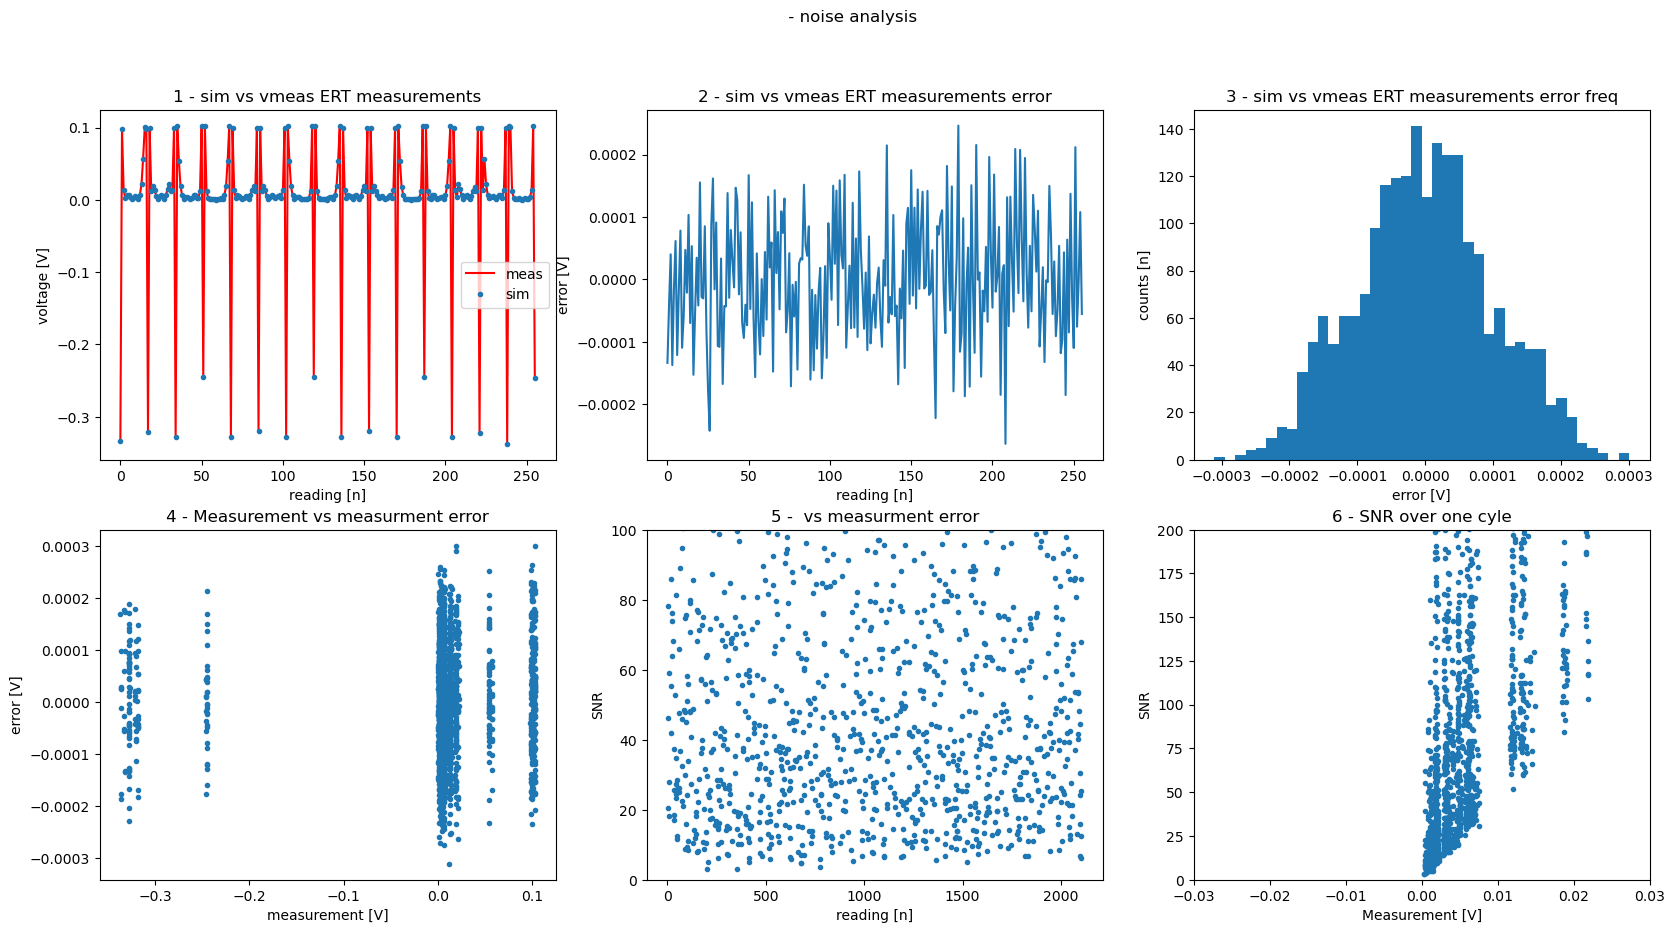

In [ ]:
elec_cycles_anom = len(elec_data_anom_l['voltage [V]'])//num_elecs**2
# iterate through real homg measurements and calculate error and SNRs
elec_er_data_anom_l, elec_snr_data_anom_l = calc_vmeas_noise(elec_data_sim_anom, elec_data_anom_l['voltage [V]'], elec_cycles_anom)

In [ ]:
# min SNR
print(min(elec_snr_data_homg_l))
print(min(elec_snr_data_anom_l))

1.9607672447547497
2.408262683952684


#### 2.3 Error/noise analysis

To generate noise similar to that seen in the system we must create a model that adequately matches the observed noise.

Plot observations:

0. In plot 1 we can see the simulations closely matches the measured values
1. In plot 2 we can see a seemingly 'random' noise for one EIT cycle with amplitude $\approx \pm 0.13 mV$
2. In plot 3 the error we can see is centered around 0 with a good normal distribution
3. In plot 4 we can see no clear relationship between error and measurement voltages
4. In plot 5 we can see a range of SNRs (many above approaching inf cut off). With a minimum SNR of $\approx 2$
5. In plot 6 we can see The minimum SNr related to the measurement

Noise modelling - 

The noise model for this is simple we can determine the parameters of plot 3 and randomly add this white noise to the system using a fitted normal distribution.

#### 2.4 Determine statistical values

In [ ]:
elec_data_er_df = pd.DataFrame(elec_er_data_homg_l,columns=['error[V]'])
elec_data_er_df.describe() # summary of error stats

error[V]
count  2.107000e+03
mean   6.685716e-07
std    9.641124e-05
min   -2.877000e-04
25%   -6.310250e-05
50%   -1.404000e-06
75%    6.336800e-05
max    2.807000e-04

In [ ]:
elec_data_er_anom_df = pd.DataFrame(elec_er_data_anom_l,columns=['error[V]'])
elec_data_er_anom_df.describe() # summary of error stats

error[V]
count  2.107000e+03
mean  -6.858561e-07
std    1.005947e-04
min   -3.105000e-04
25%   -6.762100e-05
50%   -1.344000e-06
75%    6.420450e-05
max    3.005000e-04

Determine the MSE, Rsqr and SNR for the real measurements relative to the simulated:

In [ ]:
# for homg electrode measurements:
# find MSE 
elec_mse_homg = sum(elec_data_er_df['error[V]']**2)/len(elec_data_er_df)
print("MSE=%.2e" % elec_mse_anom)
# find Rsqr values
elec_rsq_anom = 1 - elec_mse_homg/elec_data_homg_l['voltage [V]'].var()
print("Rsqr=%.6f" % elec_rsq_homg)
# find min and average SNR
elec_snr_homg_min_dB = np.min(20*np.log(elec_snr_data_homg_l))
elec_snr_homg_dB = np.mean(20*np.log(elec_snr_data_homg_l))
print("SNR min = %.2e dB SNR avg = %.2e dB" % (elec_snr_homg_min_dB, elec_snr_homg_dB))


MSE=9.29e-09
Rsqr=0.999999
SNR min = 1.35e+01 dB SNR avg = 1.04e+02 dB


In [ ]:
# for anom electrode measurements:
# find MSE 
elec_mse_anom = sum(elec_data_er_anom_df['error[V]']**2)/len(elec_data_er_anom_df)
print("MSE=%.2e" % elec_mse_anom)
# find Rsqr values
elec_rsq_anom = 1 - elec_mse_anom/elec_data_anom_l['voltage [V]'].var()
print("Rsqr=%.6f" % elec_rsq_anom)
# find min and average SNR
elec_snr_anom_min_dB = np.min(20*np.log(elec_snr_data_anom_l))
elec_snr_anom_dB = np.mean(20*np.log(elec_snr_data_anom_l))
print("SNR min = %.2e dB SNR avg = %.2e dB" % (elec_snr_anom_min_dB, elec_snr_anom_dB))


MSE=1.01e-08
Rsqr=0.999999
SNR min = 1.76e+01 dB SNR avg = 1.03e+02 dB


### 3.0 Generate a noise model from the measurements

Given the analysis in 2.0 assume a normally distributed 'white' noise function can generate noise for the system. 

data_homg_mean = 6.69e-07 V
data_homg_std = 9.64e-05 V


Text(0, 0.5, 'Normalized frequency')

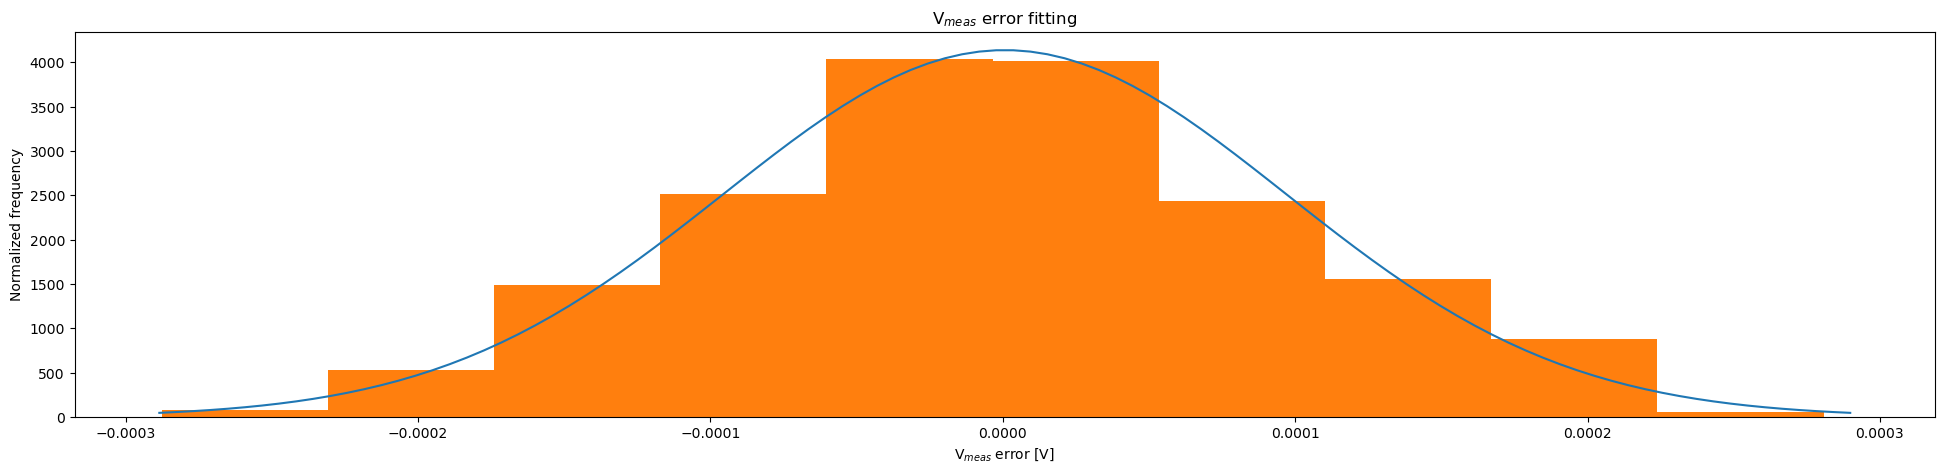

In [ ]:
# fit the homg measurement noise
data_homg_mean, data_homg_std = stats.norm.fit(elec_er_data_homg_l)
print("data_homg_mean = %.2e V" % data_homg_mean)
print(f"data_homg_std = %.2e V" % data_homg_std)

x = np.linspace(data_homg_mean - 3*data_homg_std, data_homg_mean + 3*data_homg_std, 100)

plt.figure(figsize=(24,5))
plt.plot(x, stats.norm.pdf(x, data_homg_mean, data_homg_std))
plt.hist(elec_er_data_homg_l, density=True) # density = normalised!
plt.title("V$_{meas}$ error fitting")
plt.xlabel("V$_{meas}$ error [V]")
plt.ylabel("Normalized frequency")

data_homg_mean = -6.86e-07 V
data_homg_std = 1.01e-04 V


Text(0, 0.5, 'Normalized frequency')

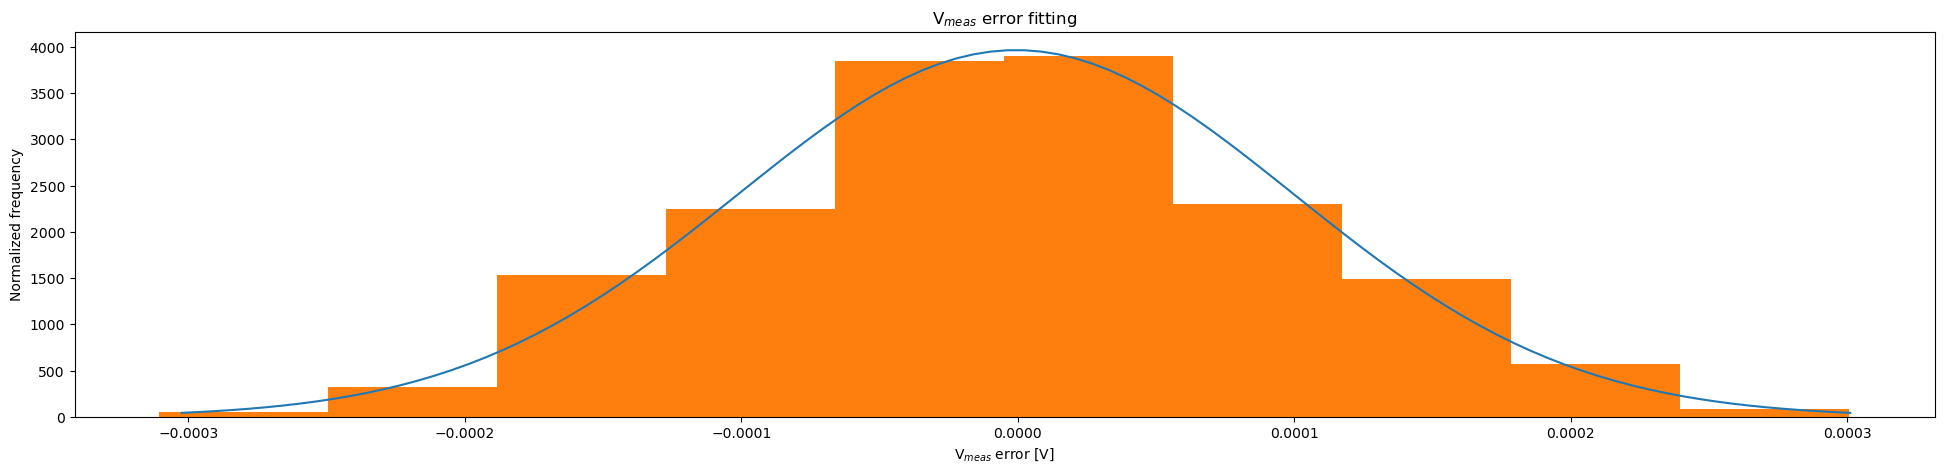

In [ ]:
# fit the anom measurement noise
data_anom_mean, data_anom_std = stats.norm.fit(elec_er_data_anom_l)
print("data_homg_mean = %.2e V" % data_anom_mean)
print(f"data_homg_std = %.2e V" % data_anom_std)

x = np.linspace(data_anom_mean - 3*data_anom_std, data_anom_mean + 3*data_anom_std, 100)

plt.figure(figsize=(24,5))
plt.plot(x, stats.norm.pdf(x, data_anom_mean, data_anom_std))
plt.hist(elec_er_data_anom_l, density=True) # density = normalised!
plt.title("V$_{meas}$ error fitting")
plt.xlabel("V$_{meas}$ error [V]")
plt.ylabel("Normalized frequency")

**Model fit**

Both error plots are similar in mean and std so can be deemed fit for both the data sets.

**Validity of model**

We can see that the validity of the model is poor around zero, with the global minima of mean error seen at Vmeas = ~0.04 V. This offset could be caused by a small DC ias in the system due to the impedance of the multiplexers and cables in the measurement. 

The impedance of the multiplexers are 50 $\pm$ 40 $\Omega$ hence with a 1 mA current source we expect to get a 2*50 $\pm$ 40 mV DC offset. This must be added to the fitted model offset parameter. 

#### 3.3 Optimisation of SNR

Based on the noise and error observed for the SMU determine the optimal current source value given the voltage must be limited to +/-20V for the current MUX setup

**Objective:**

- Maximise the SNR of Vmeas for the SMU PCB_MUX ERT system

**Adjustable variables:**

- SMU
    - Current source value
    - Integration time
- Hardware
    - DUT
    - Wiring
    - ICs
    - …

**Constraints:**

- Current source driving voltage
    - limited to 20V by MUX's

- Domain under test
    - Assuming maximum resistance seen between adjacent electrodes is 20 kOhm
    - Likely to have vibrationally sensitive electrode resistance

**Formulation:**

$Maximise : SNR = Vsim / |Vmeas - Vsim|$

$Maximise : f_{sample} = 1 / (nplc + t_{comms})$

**Domain:**
- Using a PCB resistor mesh network as the noisy domain under test
- Isrc has to be > 0 A
- Vmax driving the Isrc has to be < 20 V
- SNR for the domain must give a Rsqr < 0.65 (WHY?? cite something)

**Solution Method:**
1. Determine the overall noise (already achieved above in section 2.0)

2. Determine the major noise/error contributors. Consider:

    i. SMU Isrc noise

    ii. SMU general sample error (quantisation, integration time, etc.)

    iii. Circuit noise (MUX, resistor, more?)
    
    iv. Wiring parasitic noise (capacitive and inductive)

3. Optimise by changing Isrc or other configurable parameters until we have a sufficiently high Rsqr during reconstruction

##### Noise sources

No relationships have been seen between error and measurement. Hence the overall noise of the system has been modelled as Gaussian. 

The current noise of the SMU was determined to be the desired current source value vs the driven actual current (as measured by the SMU). Testing was completed on a 4k7 THT resistor using 1mA to determine if there is the current source noise and the correlation between the measured voltage and the current source.

The current source noise, Inoise, was shown to have a range of approx. $\pm$ 30nA which translate to $\pm$ 141uV on the voltage measurment. There was no correlation between the Vmeas and Isrc value showing that with increased Isrc, Vmeas does not increase.

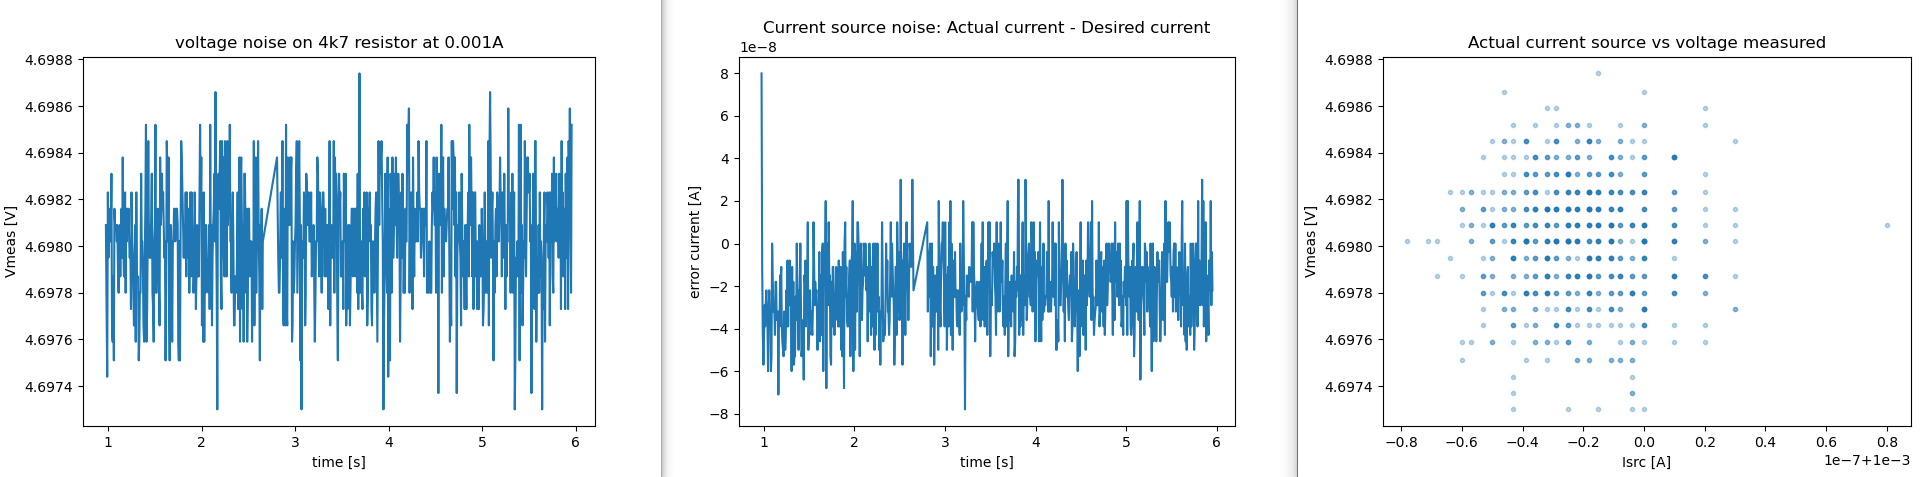

*Figure: Snapshot generated by check_Isrc_error.py*

The above voltage measurement has a range of approx. 4.6976V to 4.6984V, i.e. 800uV.

**A more mathematically correct way is to use variance or confidence intervals rather than getting range using an eye-o-meter.  

##### Comparing Isrc values vs SNR

For Isrc values of 100uA, 500uA, 1mA, 1.25mA, 2mA, 5mA

for Isrsc = 100uA
num of elec cycles 10
homogeneous DUT meas
MSE=2.57e-08
SNR_min=2.32e+00, SNR_mean=inf
err_mean = -6.23e-07 V, err_std = 1.60e-04


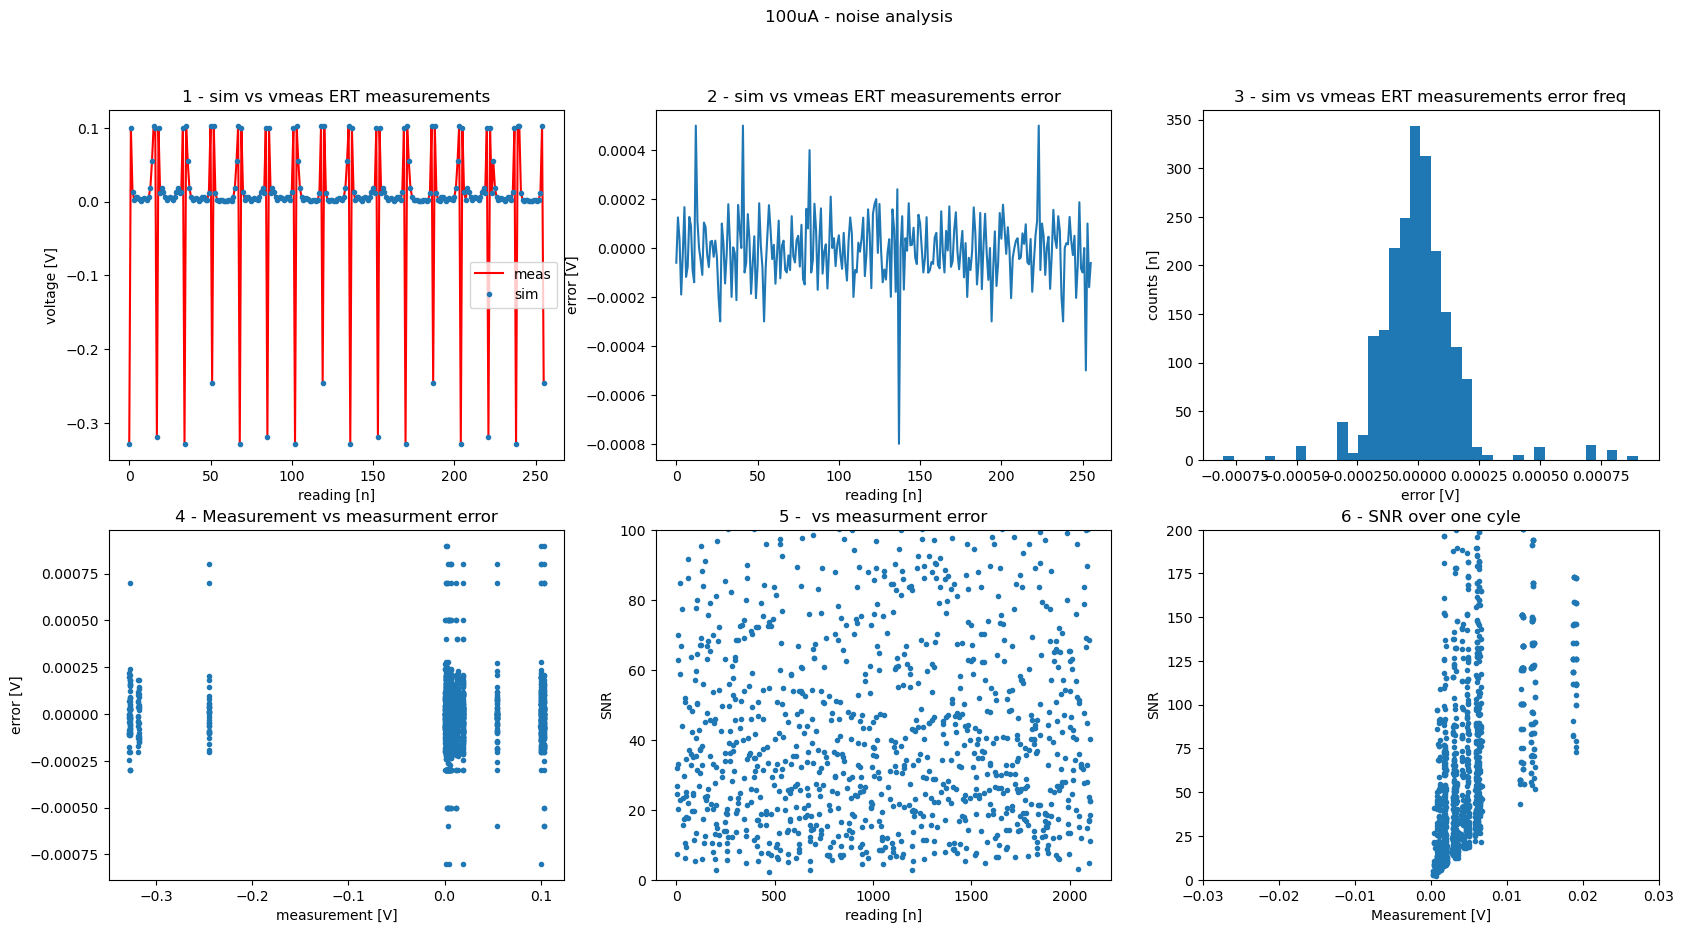

num of elec cycles 10
anomaly DUT meas
MSE=1.15e-08
SNR_min=2.32e+00, SNR_mean=2.72e+12
err_mean = -1.06e-06 V, err_std = 1.07e-04



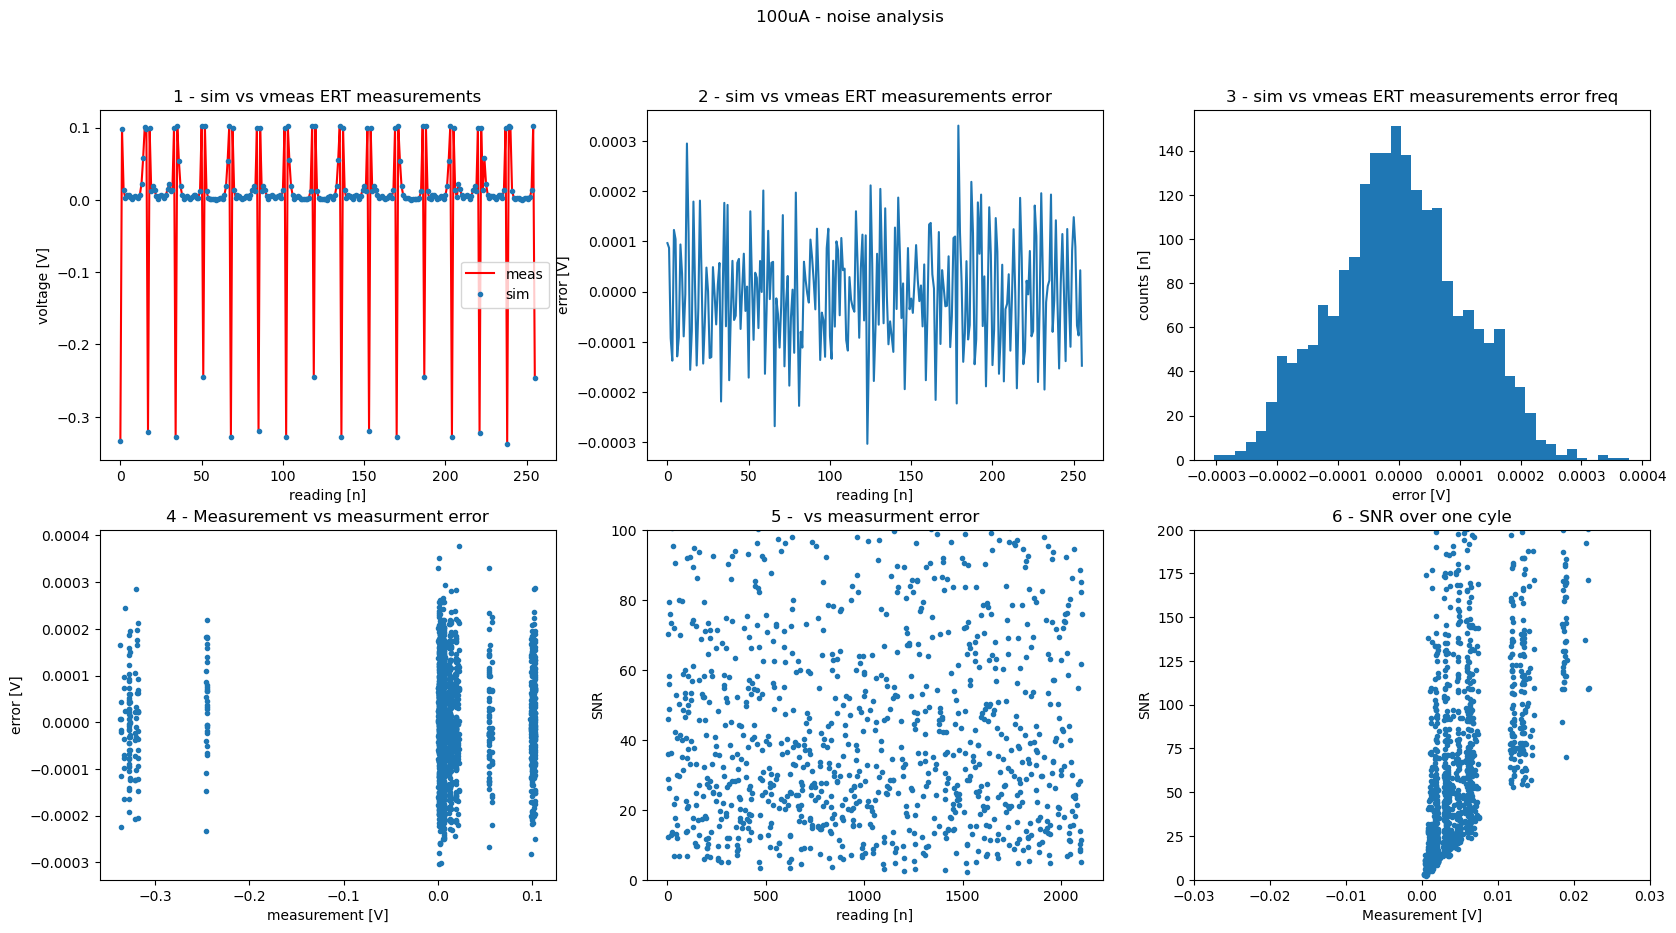

for Isrsc = 500uA
num of elec cycles 10
homogeneous DUT meas
MSE=1.19e-08
SNR_min=1.17e+01, SNR_mean=7.10e+03
err_mean = -1.48e-07 V, err_std = 1.09e-04


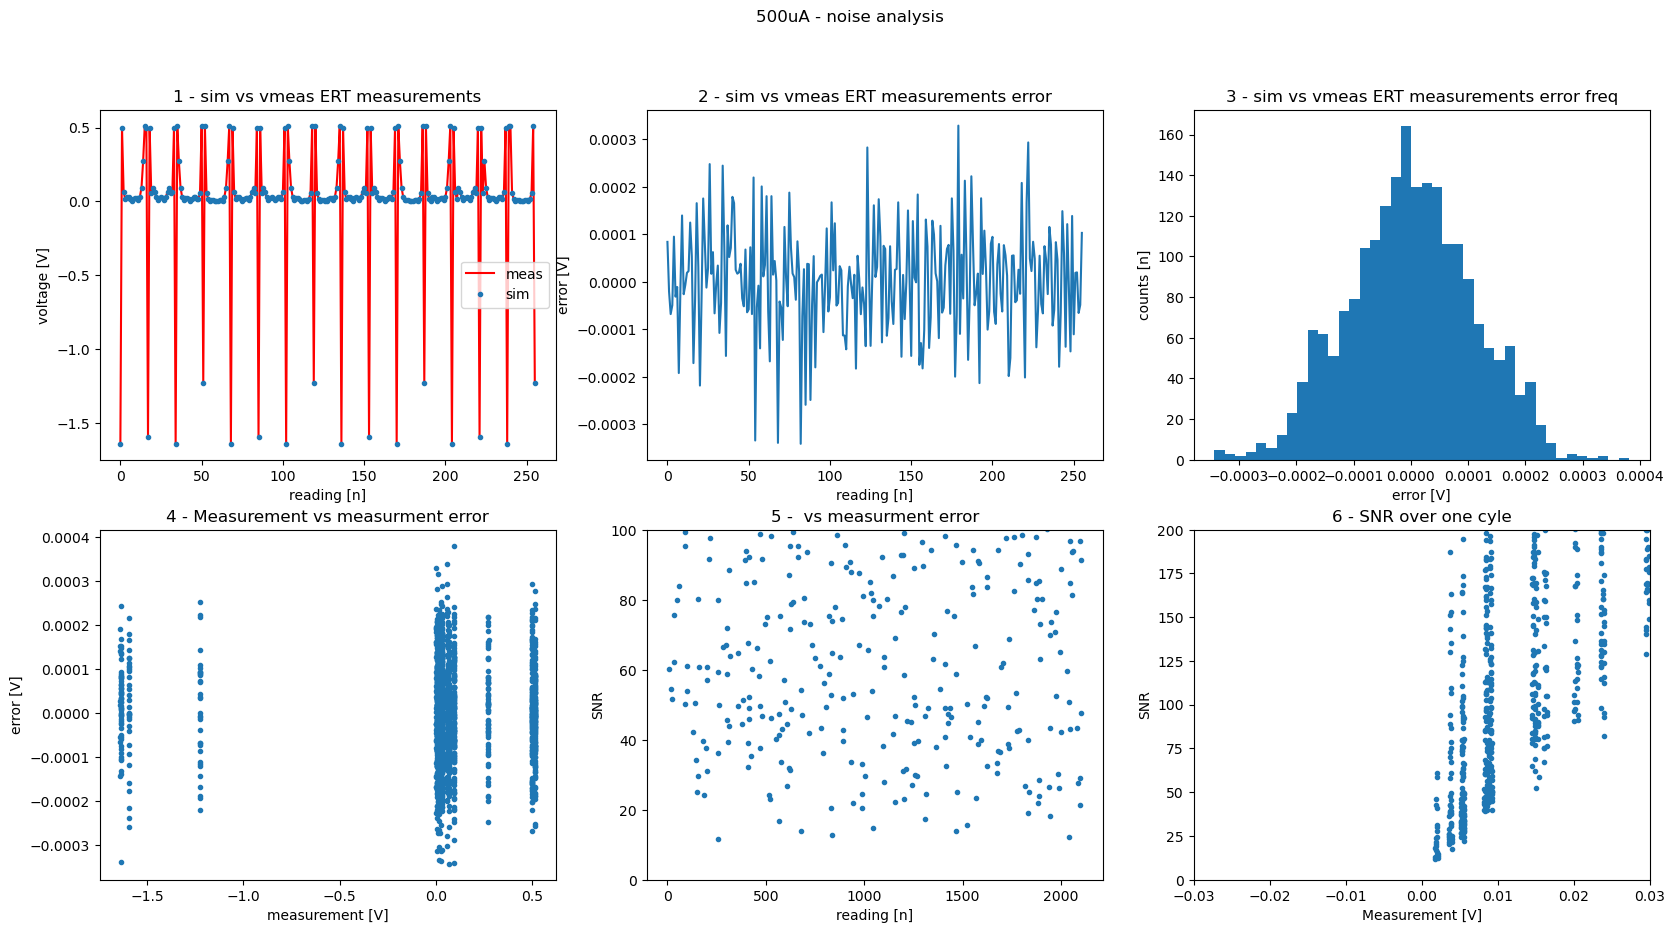

num of elec cycles 10
anomaly DUT meas
MSE=1.13e-08
SNR_min=8.89e+00, SNR_mean=8.88e+03
err_mean = 1.46e-06 V, err_std = 1.06e-04



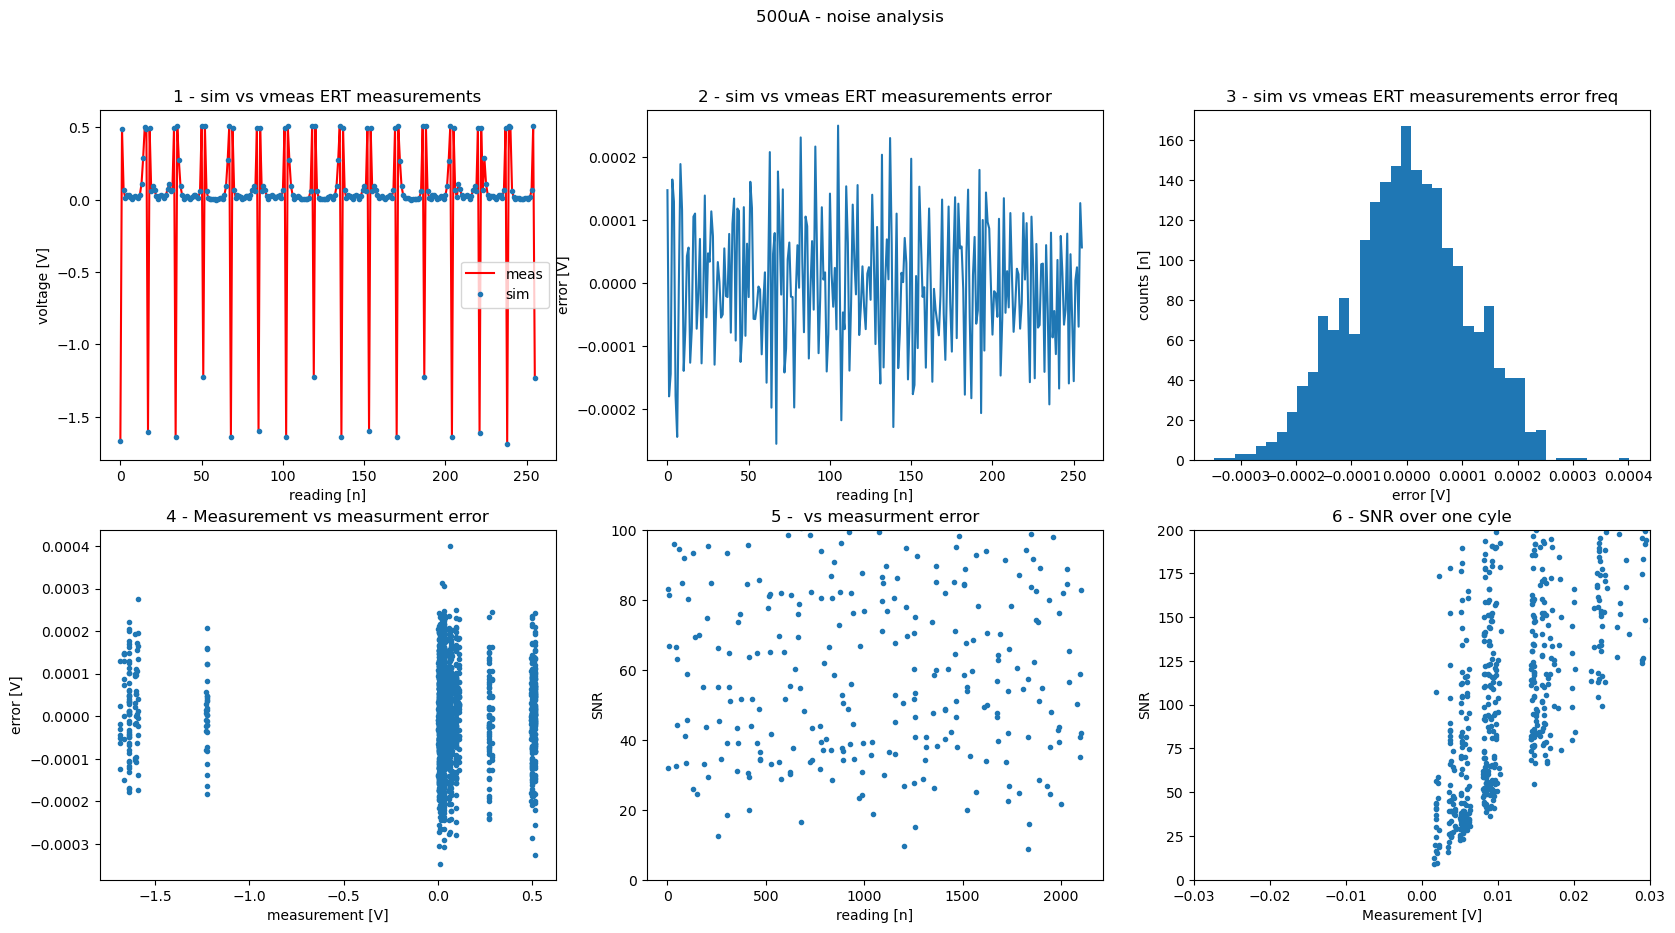

for Isrsc = 1mA
num of elec cycles 10
homogeneous DUT meas
MSE=1.21e-08
SNR_min=1.52e+01, SNR_mean=inf
err_mean = -2.27e-07 V, err_std = 1.10e-04


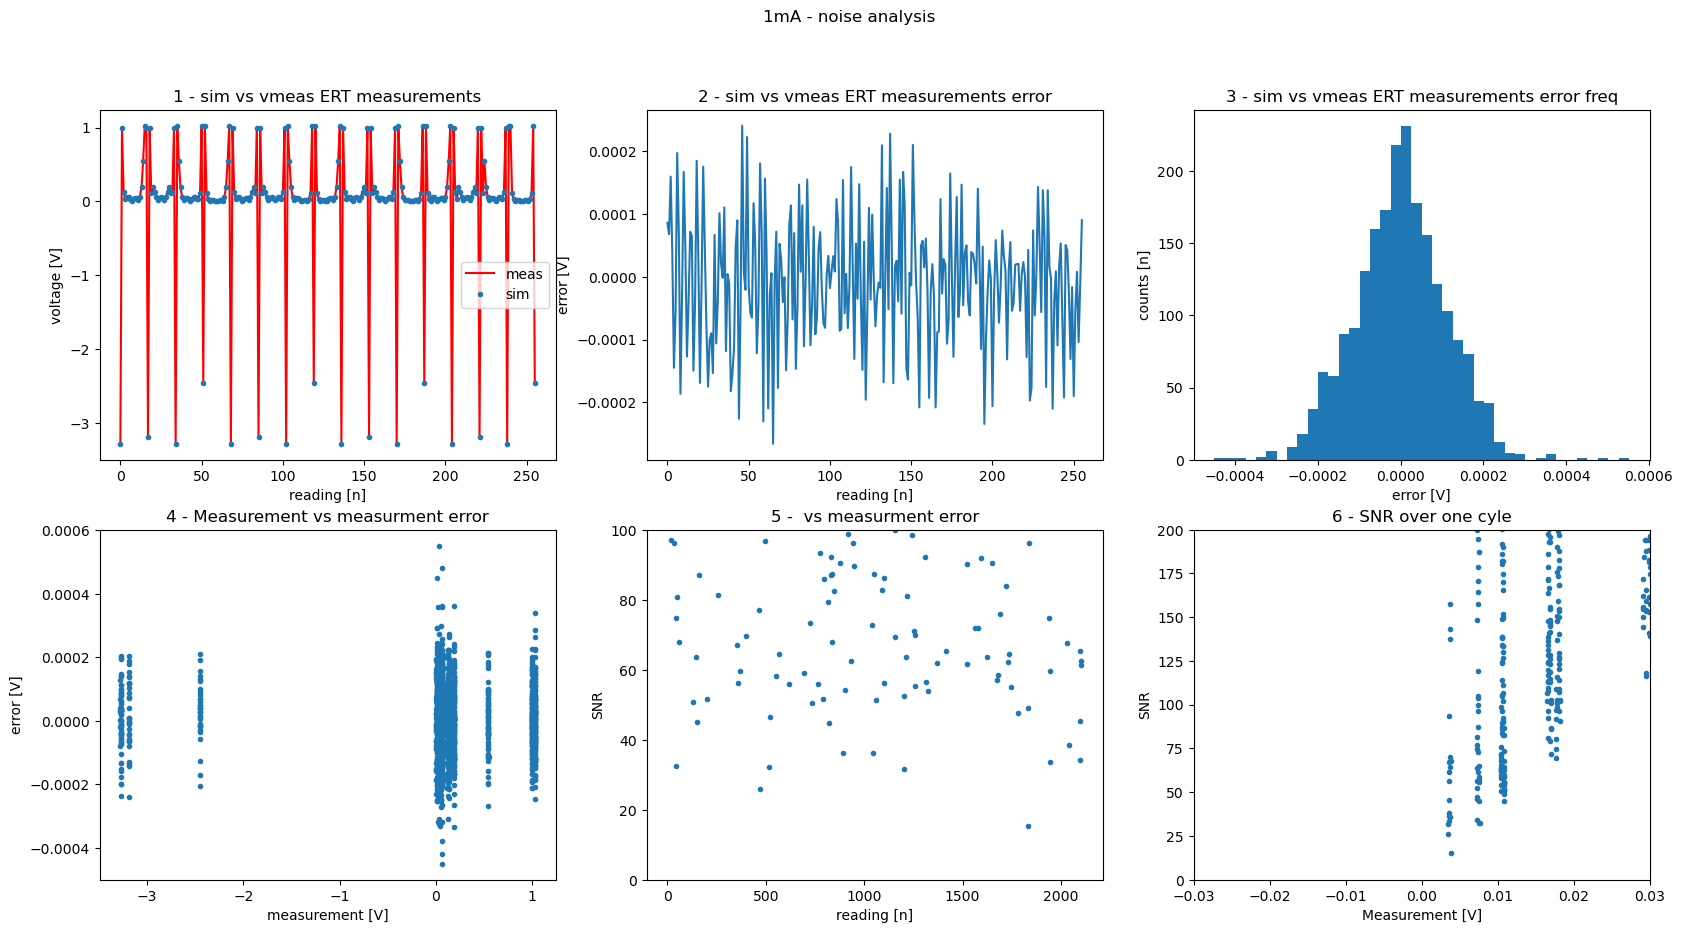

num of elec cycles 10
anomaly DUT meas
MSE=1.12e-08
SNR_min=1.75e+01, SNR_mean=inf
err_mean = 6.72e-07 V, err_std = 1.06e-04



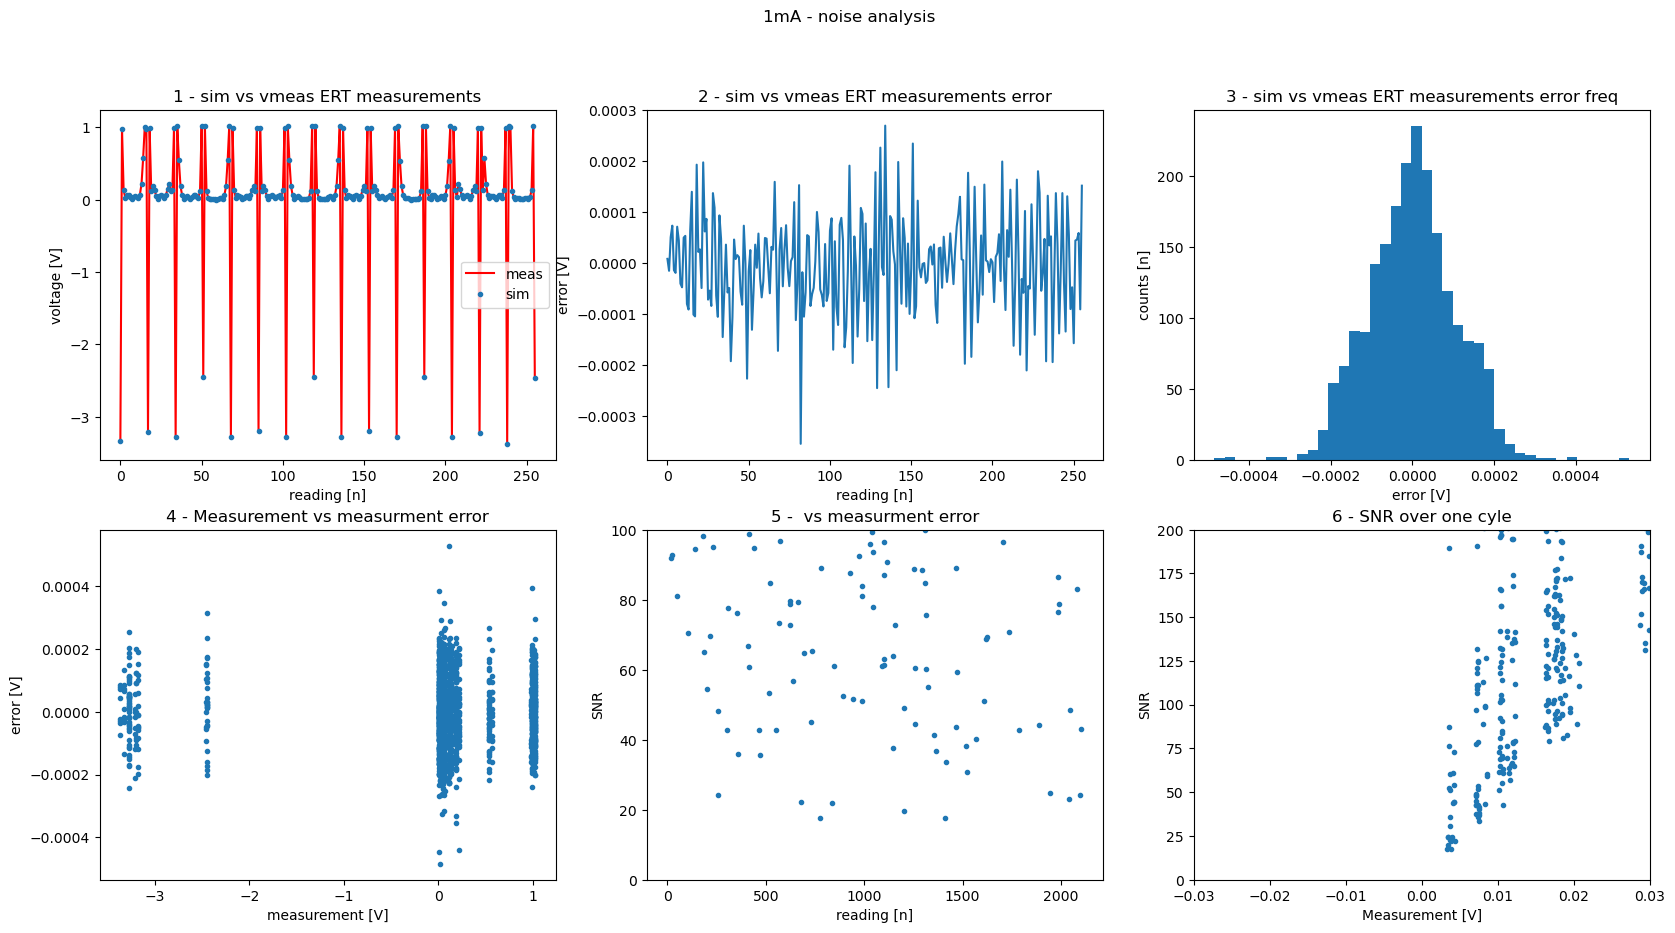

for Isrsc = 1.25mA
num of elec cycles 10
homogeneous DUT meas
MSE=2.03e-08
SNR_min=2.02e+01, SNR_mean=inf
err_mean = -1.30e-06 V, err_std = 1.43e-04


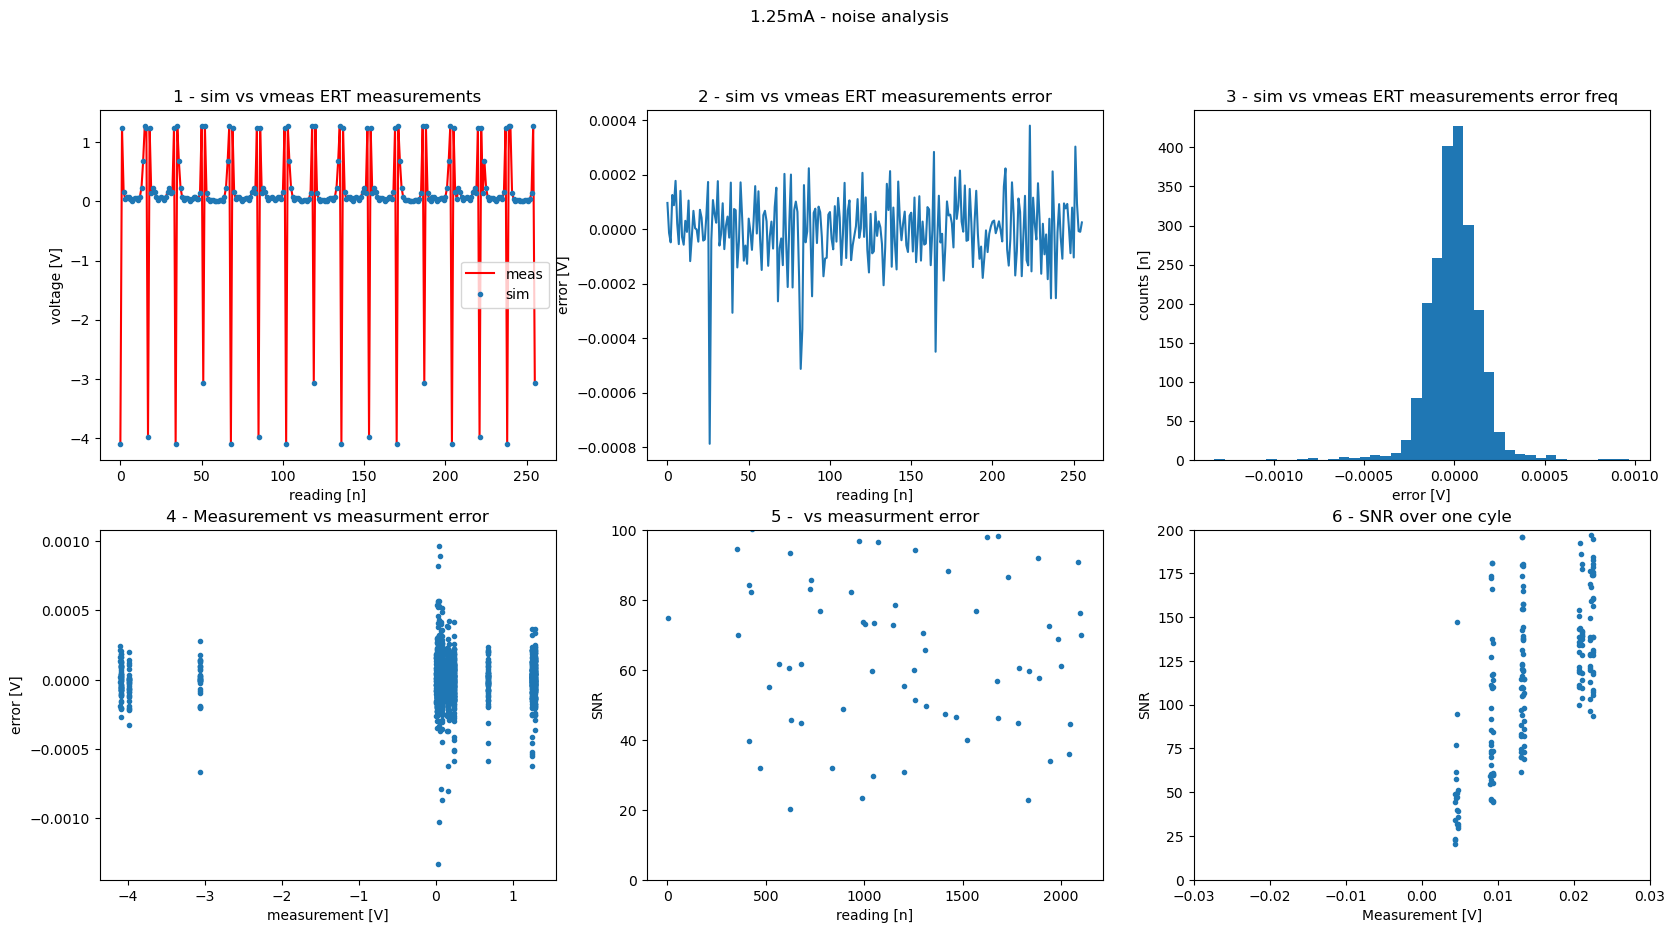

num of elec cycles 10
anomaly DUT meas
MSE=2.95e-08
SNR_min=1.98e+01, SNR_mean=inf
err_mean = -1.43e-06 V, err_std = 1.72e-04



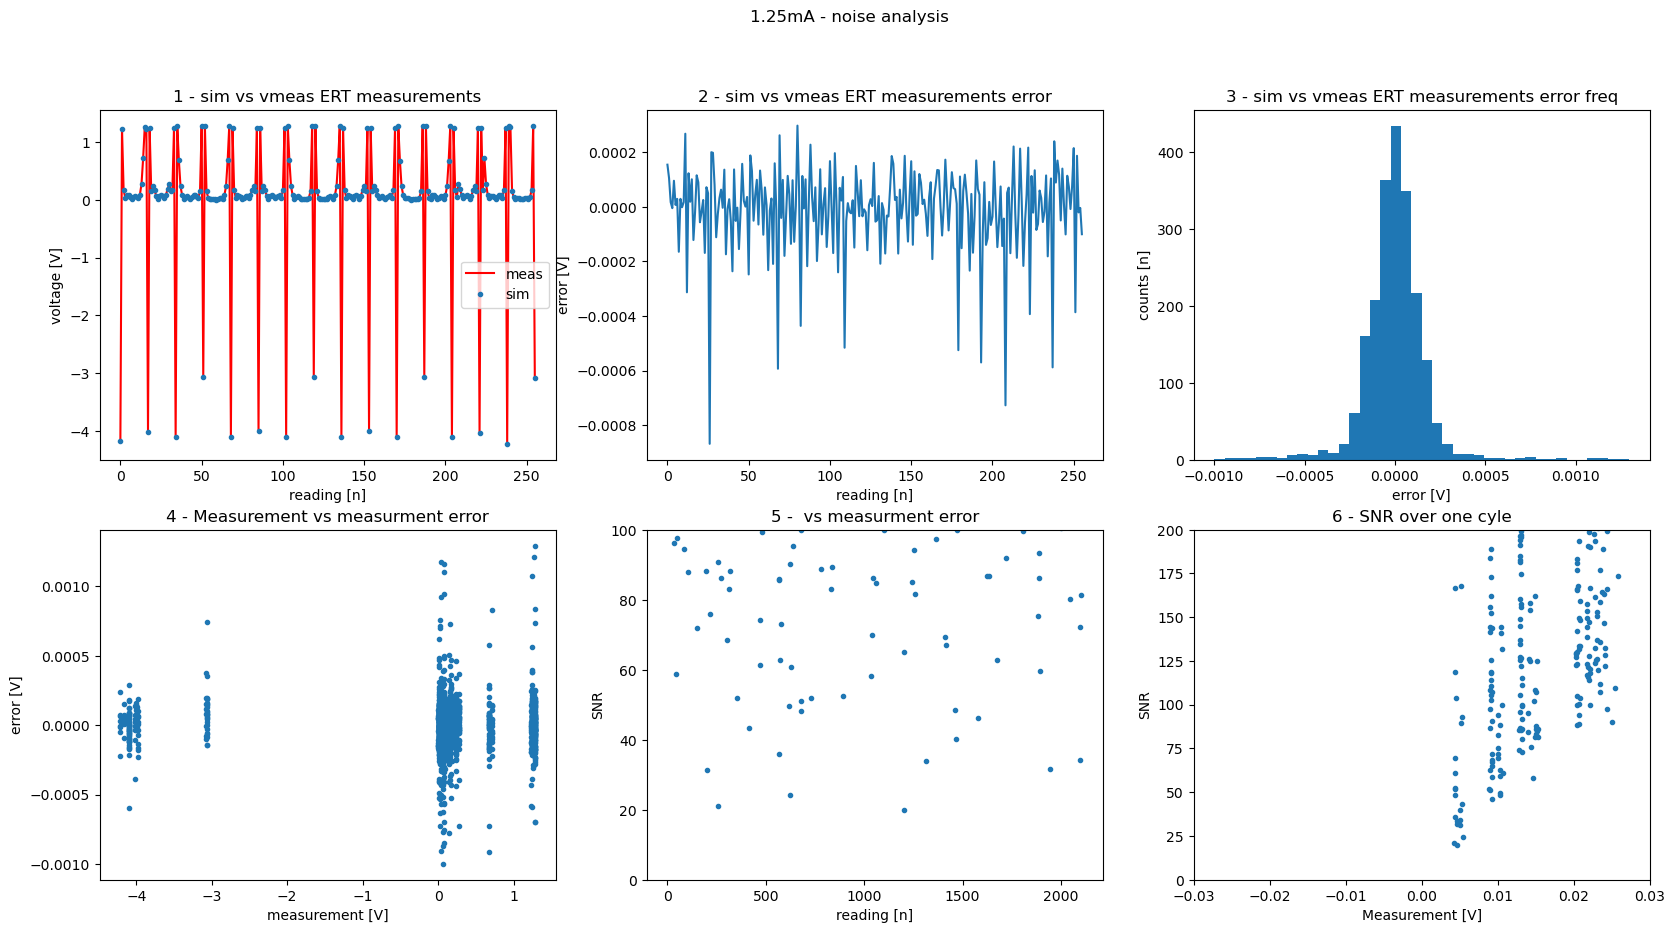

for Isrsc = 1.5mA
num of elec cycles 10
homogeneous DUT meas
MSE=2.14e-08
SNR_min=2.83e+01, SNR_mean=3.28e+12
err_mean = 1.41e-06 V, err_std = 1.46e-04


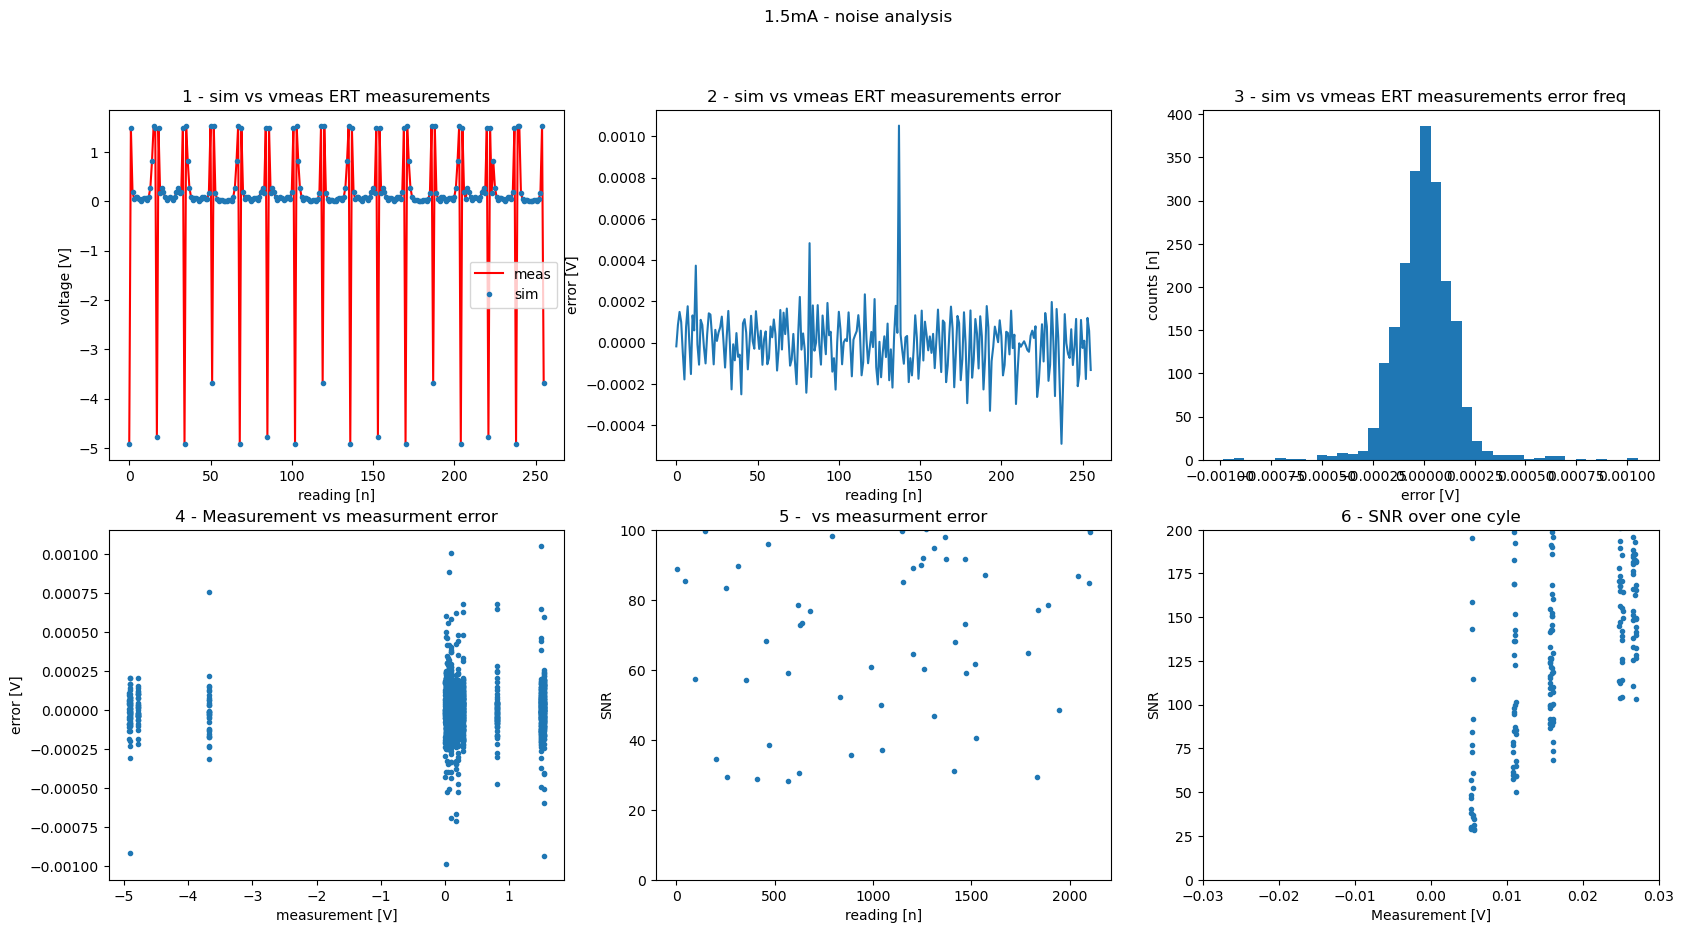

num of elec cycles 10
anomaly DUT meas
MSE=2.50e-08
SNR_min=3.09e+01, SNR_mean=1.37e+04
err_mean = -1.53e-07 V, err_std = 1.58e-04



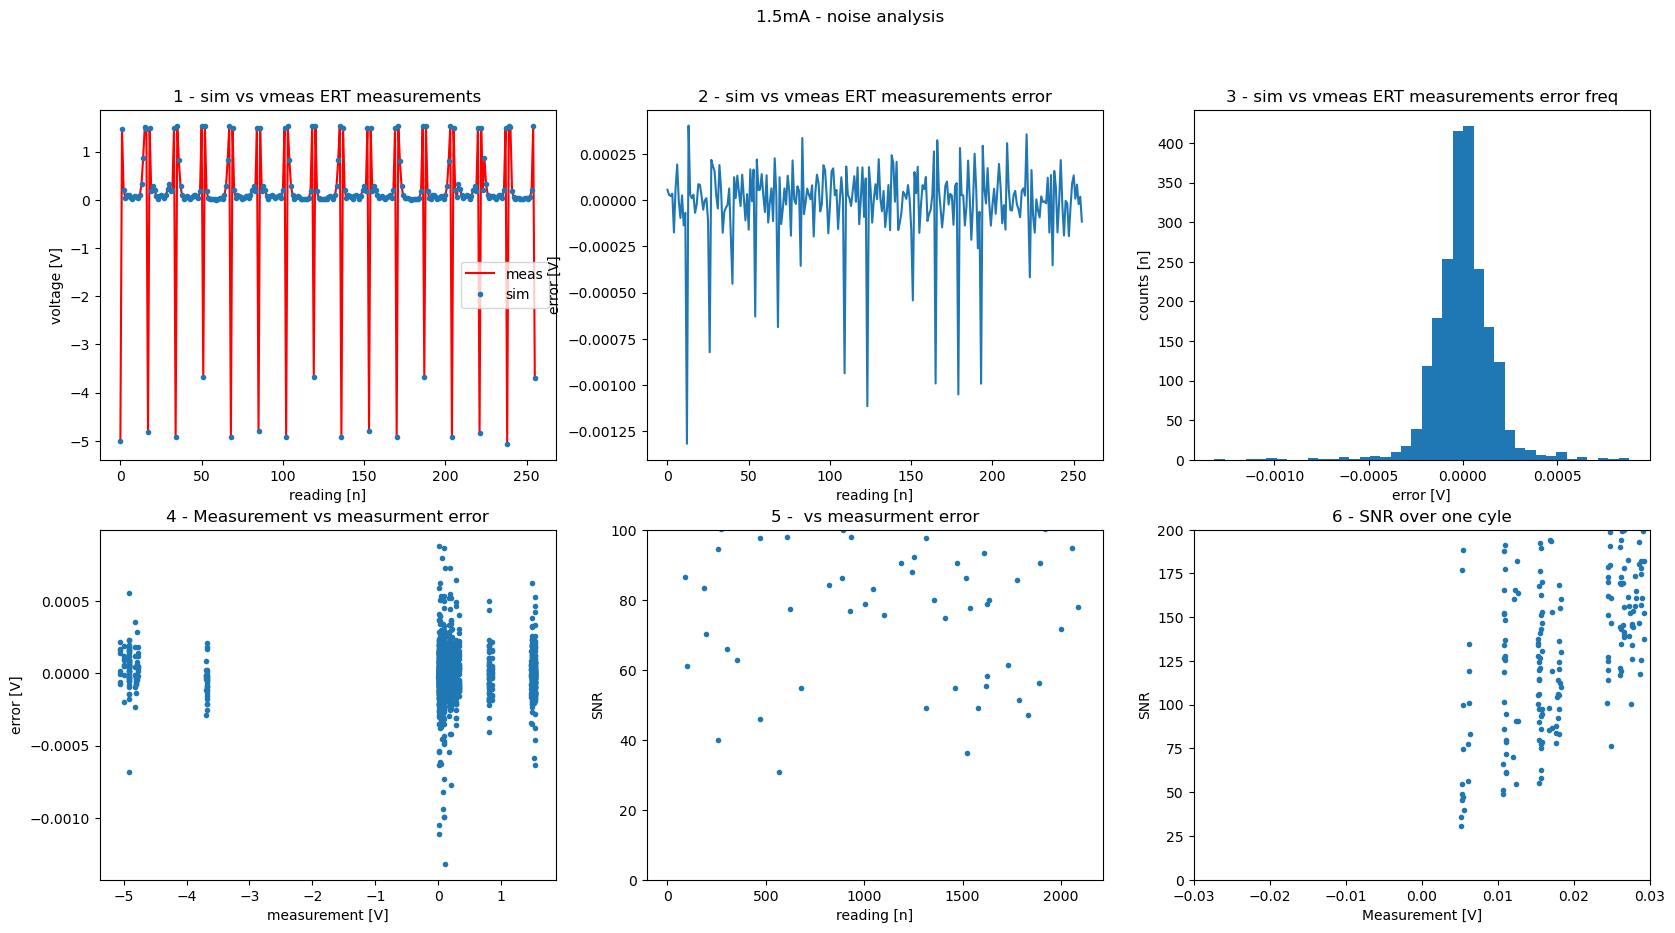

for Isrsc = 2mA
num of elec cycles 10
homogeneous DUT meas
MSE=2.47e-08
SNR_min=3.63e+01, SNR_mean=inf
err_mean = -1.14e-06 V, err_std = 1.57e-04


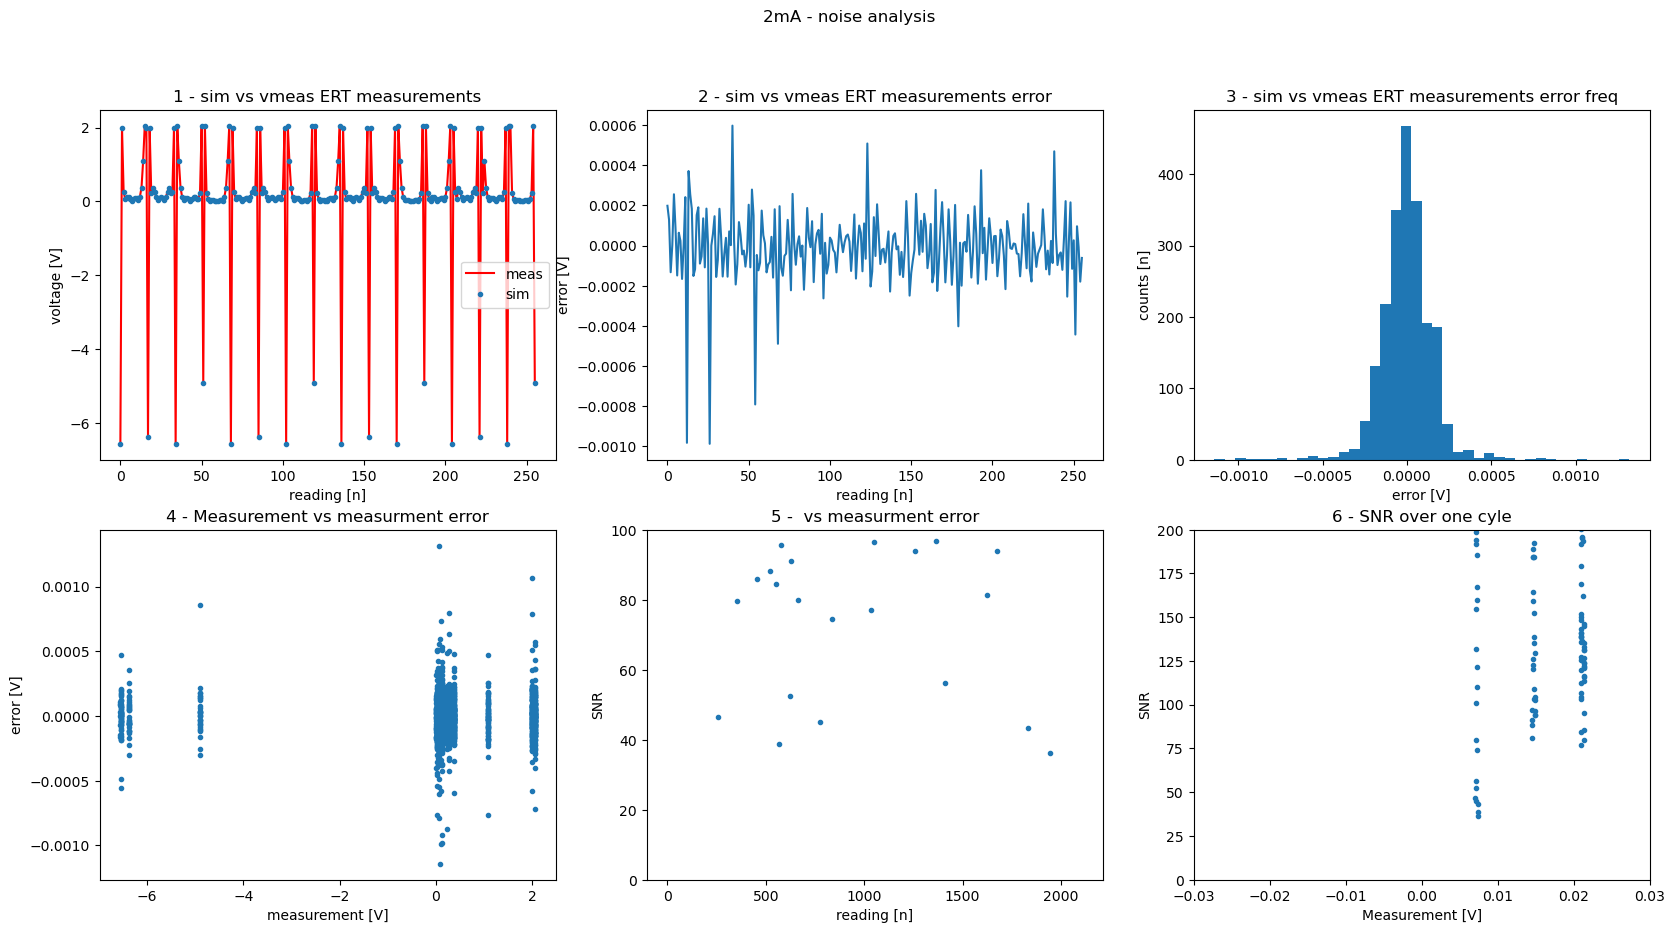

num of elec cycles 10
anomaly DUT meas
MSE=2.76e-08
SNR_min=3.39e+01, SNR_mean=inf
err_mean = -5.97e-07 V, err_std = 1.66e-04



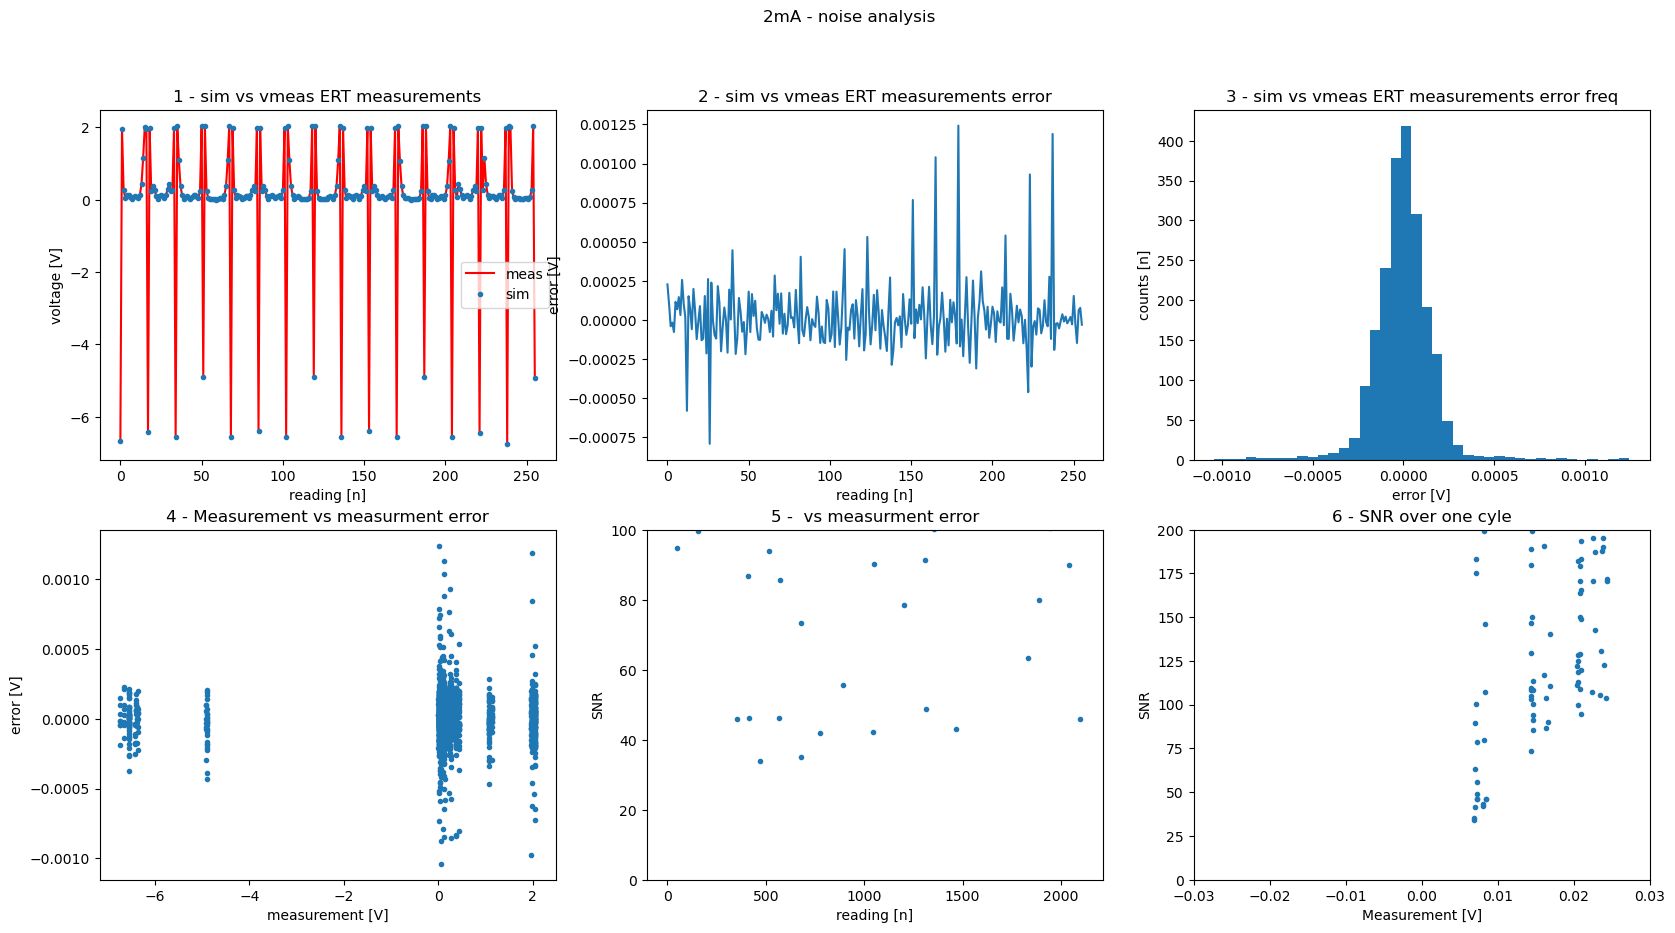

for Isrsc = 5mA
num of elec cycles 10
homogeneous DUT meas
MSE=2.83e-08
SNR_min=9.76e+01, SNR_mean=inf
err_mean = -1.50e-06 V, err_std = 1.68e-04


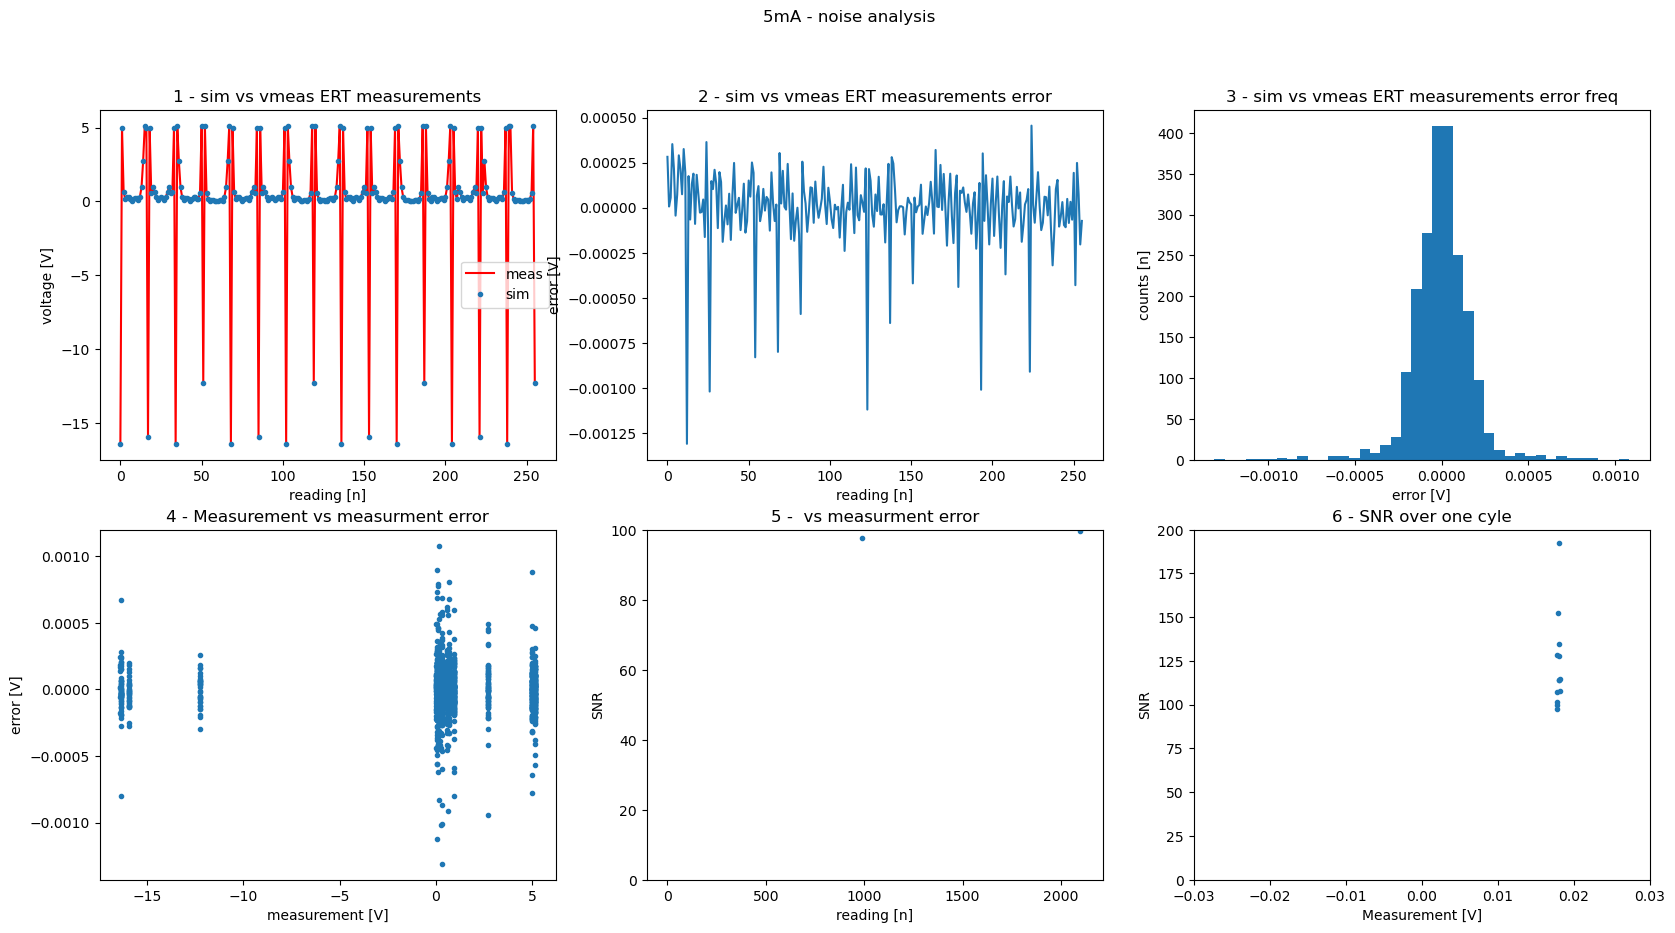

num of elec cycles 10
anomaly DUT meas
MSE=3.02e-08
SNR_min=8.44e+01, SNR_mean=inf
err_mean = -2.43e-06 V, err_std = 1.74e-04



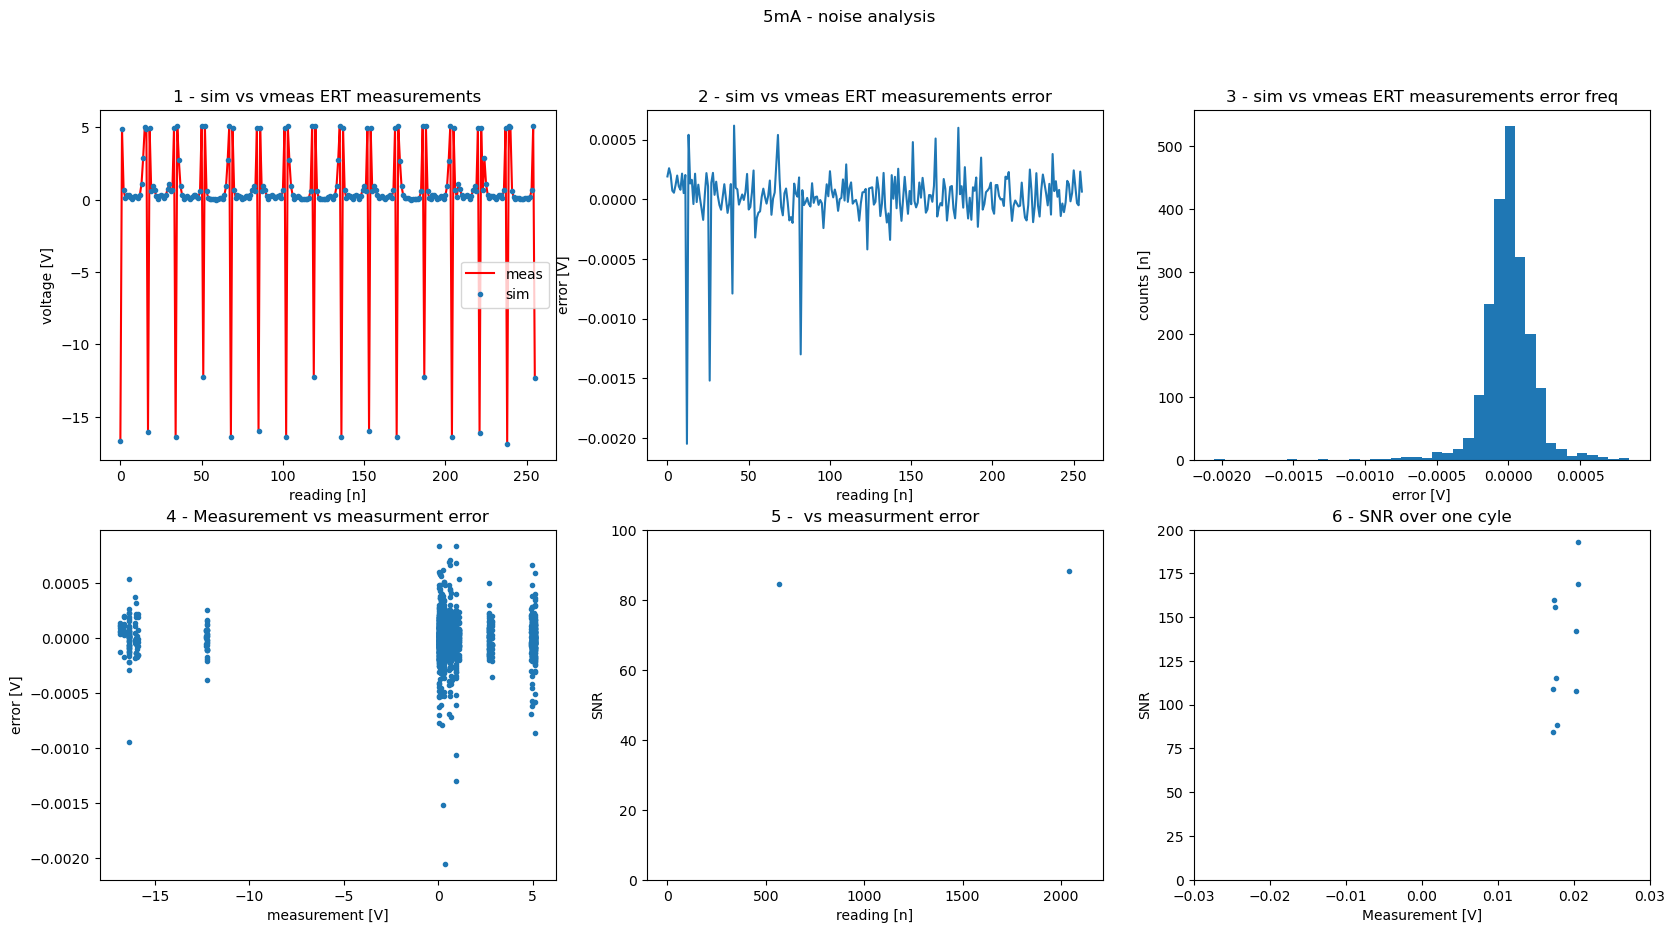

In [ ]:
%matplotlib inline
# %matplotlib qt

i_src_arr = [100e-6, 500e-6, 1e-3, 1.25e-3, 1.5e-3, 2e-3, 5e-3]
i_src_str_arr = ['100uA', '500uA', '1mA', '1.25mA', '1.5mA','2mA','5mA']
nplc_str = '0.02'
mse_isrc_homg_arr = []
mse_isrc_anom_arr = []
snr_min_isrc_homg_arr = []
snr_min_isrc_anom_arr = []
snr_isrc_homg_arr_l = []
snr_isrc_anom_arr_l = []
std_isrc_homg_arr = []
std_isrc_anom_arr = []

for i in range(len(i_src_arr)):
    i_src = i_src_arr[i]
    i_src_str = i_src_str_arr[i]

    # INPUT phantom mesh .cir netlist files:
    resmeshpcb_2k2 = esim.ErtSim(r'..\KiCAD_scripting\Kicad_netlist_pyspice_sim\resistor_network_2k2.cir', i_src, num_elecs) #add 'r' before file string
    resmeshpcb_2k2_anom_3k3 = esim.ErtSim(r'..\KiCAD_scripting\Kicad_netlist_pyspice_sim\resistor_network_3k3_pcb_anom_2k2_bg.cir', i_src, num_elecs)

    sim_data = resmeshpcb_2k2.run_sim()
    sim_data_anom = resmeshpcb_2k2_anom_3k3.run_sim()

    elec_data_sim = resmeshpcb_2k2.get_elec_data()
    # elec_data_sim = elec_data_sim[1:256] + [elec_data_sim[0]] # shift data one
    elec_data_sim_anom = resmeshpcb_2k2_anom_3k3.get_elec_data()
    # elec_data_sim_anom = elec_data_sim_anom[1:256] + [elec_data_sim_anom[0]] # shift data one

    # INPUT raw ERT voltage measurement sequence:
    #   note: length of these changes file to file
    raw_homg_data_V = f"../PCB_MUX/data/res_mesh_2k2_{i_src_str}_nplc{nplc_str}.csv" # res mesh (2k2) reading at using 1mA adj pattern
    raw_anom_data_V = f"../PCB_MUX/data/res_mesh_2k2_3k3_anom_{i_src_str}_nplc{nplc_str}.csv" # res mesh (2k2 + 3k3 bg anom) reading at using 1mA adj pattern

    elec_data_homg_l = pd.read_csv(raw_homg_data_V,skiprows=1)
    elec_data_homg_l['voltage [V]'][1:-1] = elec_data_homg_l['voltage [V]'][0:-2] # shift all readings by one
    elec_data_homg_l['voltage [V]'][0] = elec_data_homg_l['voltage [V]'][num_elecs**2]

    elec_data_anom_l = pd.read_csv(raw_anom_data_V,skiprows=1) 
    elec_data_anom_l['voltage [V]'][1:-1] = elec_data_anom_l['voltage [V]'][0:-2] # shift all readings by one
    elec_data_anom_l['voltage [V]'][0] = elec_data_anom_l['voltage [V]'][num_elecs**2]

    print(f"for Isrsc = {i_src_str}")

    # homogeneous error plots -
    elec_cycles_homg = len(elec_data_homg_l['voltage [V]'])//num_elecs**2
    # iterate through real homg measurements and calculate error and SNRs
    elec_er_data_homg_l, elec_snr_data_homg_l = calc_vmeas_noise(elec_data_sim, elec_data_homg_l['voltage [V]'], elec_cycles_homg, i_src_str, plot=True)
    print("homogeneous DUT meas")
    elec_mse_homg = sum(np.array(elec_er_data_homg_l)**2)/len(elec_er_data_homg_l)
    mse_isrc_homg_arr.append(elec_mse_homg)
    print("MSE=%.2e" % elec_mse_homg)
    snr_min_isrc_homg_arr.append(np.min(elec_snr_data_homg_l))
    snr_isrc_homg_arr_l.append(elec_snr_data_homg_l)
    print("SNR_min=%.2e, SNR_mean=%.2e" % (np.min(elec_snr_data_homg_l),np.mean(elec_snr_data_homg_l)))
    data_homg_mean, data_homg_std = stats.norm.fit(elec_er_data_homg_l)
    std_isrc_homg_arr.append(data_homg_std)
    print("err_mean = %.2e V, err_std = %.2e" % (data_homg_mean,data_homg_std))
    plt.show()



    # anomaly error plots -
    elec_cycles_anom = len(elec_data_anom_l['voltage [V]'])//num_elecs**2
    # iterate through real anom measurements and calculate error and SNRs
    elec_er_data_anom_l, elec_snr_data_anom_l = calc_vmeas_noise(elec_data_sim_anom, elec_data_anom_l['voltage [V]'], elec_cycles_anom, i_src_str, plot=True)
    print("anomaly DUT meas")
    elec_mse_anom = sum(np.array(elec_er_data_anom_l)**2)/len(elec_er_data_anom_l)  
    mse_isrc_anom_arr.append(elec_mse_anom)
    print("MSE=%.2e" % elec_mse_anom)
    snr_min_isrc_anom_arr.append(np.min(elec_snr_data_anom_l))
    snr_isrc_anom_arr_l.append(elec_snr_data_anom_l)
    print("SNR_min=%.2e, SNR_mean=%.2e" % (np.min(elec_snr_data_anom_l),np.mean(elec_snr_data_anom_l)))
    data_anom_mean, data_anom_std = stats.norm.fit(elec_er_data_anom_l)
    std_isrc_anom_arr.append(data_anom_std)
    print("err_mean = %.2e V, err_std = %.2e" % (data_anom_mean,data_anom_std))
    print()
    plt.show()

    


Text(0, 0.5, 'Stdev [V]')

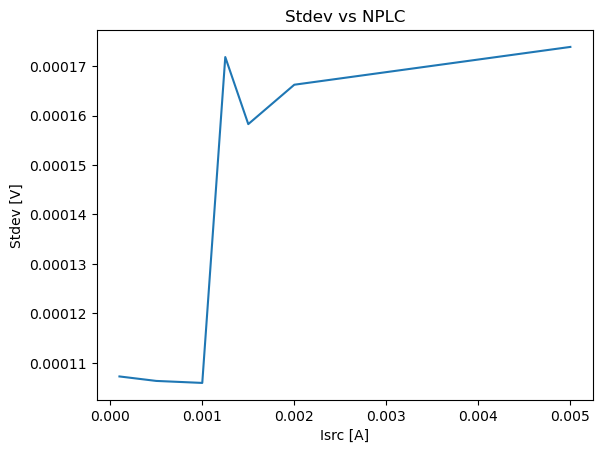

In [ ]:
plt.title("Stdev vs Isrc")
plt.plot(i_src_arr,std_isrc_anom_arr)
plt.xlabel('Isrc [A]')
plt.ylabel('Stdev [V]')

Text(0.5, 0.92, 'SNR vs Isrc for nplc = 0.02')

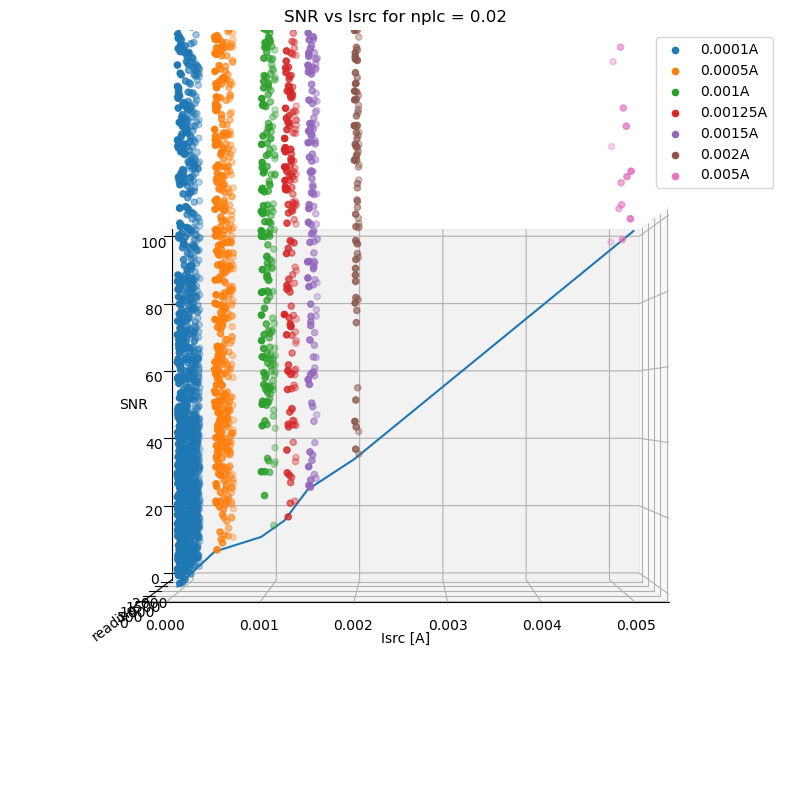

In [ ]:
# %matplotlib qt
%matplotlib inline
readings_l = np.linspace(1,np.shape(snr_isrc_anom_arr_l)[1],np.shape(snr_isrc_anom_arr_l)[1])
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

for i in range(len(i_src_arr)):
    ax.scatter(i_src_arr[i], readings_l, snr_isrc_homg_arr_l[i],label=f"{i_src_arr[i]}A")
ax.plot(i_src_arr,np.zeros(len(i_src_arr)), np.min(np.array(snr_isrc_homg_arr_l),1),'-')
ax.set_xlabel('Isrc [A]')
ax.set_ylabel('reading')
ax.set_zlabel('SNR')
ax.set_zlim(0,100)
ax.view_init(0,-90,0)
ax.legend()
ax.set_title(f'SNR vs Isrc for nplc = {nplc_str}')

##### Comparing integration time (NPLC) values vs SNR

for number of power line cycles (NPLC) = 0.01, 0.02, 0.05, 0.1, 0.5 and 1.0

In [ ]:
%matplotlib inline
# %matplotlib qt
i_src = 1.5e-3
i_src_str = '1.5mA'

nplc_arr = np.array([0.01, 0.02, 0.05, 0.1, 0.5, 1])
nplc_str_arr = nplc_arr.astype(str)
mse_nplc_homg_arr = [] # MSEs
mse_nplc_anom_arr = []
snr_min_nplc_homg_arr = [] # SNR mins
snr_min_nplc_anom_arr = []
snr_nplc_homg_arr_l = [] 
snr_nplc_anom_arr_l = []
std_nplc_homg_arr = []
std_nplc_anom_arr = []

for i in range(len(nplc_str_arr)):
    nplc_str = nplc_str_arr[i]
    
    # INPUT phantom mesh .cir netlist files:
    resmeshpcb_2k2 = esim.ErtSim(r'..\KiCAD_scripting\Kicad_netlist_pyspice_sim\resistor_network_2k2.cir', i_src, num_elecs) #add 'r' before file string
    resmeshpcb_2k2_anom_3k3 = esim.ErtSim(r'..\KiCAD_scripting\Kicad_netlist_pyspice_sim\resistor_network_3k3_pcb_anom_2k2_bg.cir', i_src, num_elecs)

    sim_data = resmeshpcb_2k2.run_sim()
    sim_data_anom = resmeshpcb_2k2_anom_3k3.run_sim()

    elec_data_sim = resmeshpcb_2k2.get_elec_data()
    # elec_data_sim = elec_data_sim[1:256] + [elec_data_sim[0]] # shift data one
    elec_data_sim_anom = resmeshpcb_2k2_anom_3k3.get_elec_data()
    # elec_data_sim_anom = elec_data_sim_anom[1:256] + [elec_data_sim_anom[0]] # shift data one

    # INPUT raw ERT voltage measurement sequence:
    #   note: length of these changes file to file
    raw_homg_data_V = f"../PCB_MUX/data/res_mesh_2k2_{i_src_str}_nplc{nplc_str}.csv" # res mesh (2k2) reading at using 1mA adj pattern
    raw_anom_data_V = f"../PCB_MUX/data/res_mesh_2k2_3k3_anom_{i_src_str}_nplc{nplc_str}.csv" # res mesh (2k2 + 3k3 bg anom) reading at using 1mA adj pattern

    elec_data_homg_l = pd.read_csv(raw_homg_data_V,skiprows=1)
    elec_data_homg_l['voltage [V]'][1:-1] = elec_data_homg_l['voltage [V]'][0:-2] # shift all readings by one
    elec_data_homg_l['voltage [V]'][0] = elec_data_homg_l['voltage [V]'][num_elecs**2]

    elec_data_anom_l = pd.read_csv(raw_anom_data_V,skiprows=1) 
    elec_data_anom_l['voltage [V]'][1:-1] = elec_data_anom_l['voltage [V]'][0:-2] # shift all readings by one
    elec_data_anom_l['voltage [V]'][0] = elec_data_anom_l['voltage [V]'][num_elecs**2]

    print(f"for Isrsc = {i_src_str} and NPLC = {nplc_str}")

    # homogeneous error plots -
    elec_cycles_homg = len(elec_data_homg_l['voltage [V]'])//num_elecs**2
    # iterate through real homg measurements and calculate error and SNRs
    elec_er_data_homg_l, elec_snr_data_homg_l = calc_vmeas_noise(elec_data_sim, elec_data_homg_l['voltage [V]'], elec_cycles_homg, nplc_str, plot=False)
    print("homogeneous DUT meas")
    elec_mse_homg = sum(np.array(elec_er_data_homg_l)**2)/len(elec_er_data_homg_l)
    mse_nplc_homg_arr.append(elec_mse_homg)
    print("MSE=%.2e" % elec_mse_homg)
    snr_min_nplc_homg_arr.append(np.min(elec_snr_data_homg_l))
    snr_nplc_homg_arr_l.append(elec_snr_data_homg_l)
    print("SNR_min=%.2e, SNR_mean=%.2e" % (np.min(elec_snr_data_homg_l),np.mean(elec_snr_data_homg_l)))
    data_homg_mean, data_homg_std = stats.norm.fit(elec_er_data_homg_l)
    std_nplc_homg_arr.append(data_homg_std)
    print("err_mean = %.2e V, err_std = %.2e" % (data_homg_mean,data_homg_std))
    plt.show()

    # anomaly error plots -
    elec_cycles_anom = len(elec_data_anom_l['voltage [V]'])//num_elecs**2
    # iterate through real anom measurements and calculate error and SNRs
    elec_er_data_anom_l, elec_snr_data_anom_l = calc_vmeas_noise(elec_data_sim_anom, elec_data_anom_l['voltage [V]'], elec_cycles_anom, nplc_str, plot=False)
    print("anomaly DUT meas")
    elec_mse_anom = sum(np.array(elec_er_data_anom_l)**2)/len(elec_er_data_anom_l)  
    mse_nplc_anom_arr.append(elec_mse_anom)
    print("MSE=%.2e" % elec_mse_anom)
    snr_min_nplc_anom_arr.append(np.min(elec_snr_data_anom_l))
    snr_nplc_anom_arr_l.append(elec_snr_data_anom_l)
    print("SNR_min=%.2e, SNR_mean=%.2e" % (np.min(elec_snr_data_anom_l),np.mean(elec_snr_data_anom_l)))
    data_anom_mean, data_anom_std = stats.norm.fit(elec_er_data_anom_l)
    std_nplc_anom_arr.append(data_anom_std)
    print("err_mean = %.2e V, err_std = %.2e" % (data_anom_mean,data_anom_std))
    print()
    plt.show()

    


for Isrsc = 1.5mA and NPLC = 0.01
num of elec cycles 10
homogeneous DUT meas
MSE=2.82e-08
SNR_min=2.90e+01, SNR_mean=inf
err_mean = 2.88e-07 V, err_std = 1.68e-04
num of elec cycles 10
anomaly DUT meas
MSE=3.27e-08
SNR_min=3.74e+01, SNR_mean=inf
err_mean = 3.05e-06 V, err_std = 1.81e-04

for Isrsc = 1.5mA and NPLC = 0.02
num of elec cycles 10
homogeneous DUT meas
MSE=2.14e-08
SNR_min=2.74e+01, SNR_mean=3.29e+12
err_mean = 1.41e-06 V, err_std = 1.46e-04
num of elec cycles 10
anomaly DUT meas
MSE=2.50e-08
SNR_min=3.01e+01, SNR_mean=1.38e+04
err_mean = -1.53e-07 V, err_std = 1.58e-04

for Isrsc = 1.5mA and NPLC = 0.05
num of elec cycles 10
homogeneous DUT meas
MSE=1.43e-08
SNR_min=2.33e+01, SNR_mean=1.98e+04
err_mean = -6.64e-07 V, err_std = 1.20e-04
num of elec cycles 10
anomaly DUT meas
MSE=1.52e-08
SNR_min=2.31e+01, SNR_mean=inf
err_mean = -3.08e-07 V, err_std = 1.23e-04

for Isrsc = 1.5mA and NPLC = 0.1
num of elec cycles 10
homogeneous DUT meas
MSE=1.57e-08
SNR_min=2.52e+01, SNR_mean

Text(0, 0.5, 'Stdev [V]')

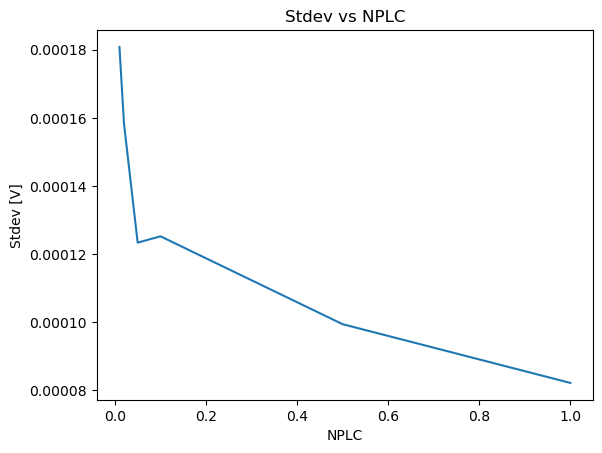

In [ ]:
plt.title("Stdev vs NPLC")
plt.plot(nplc_arr,std_nplc_anom_arr)
plt.xlabel('NPLC')
plt.ylabel('Stdev [V]')

Text(0.5, 0.92, 'SNR vs NPLC for Isrc = 1.5mA')

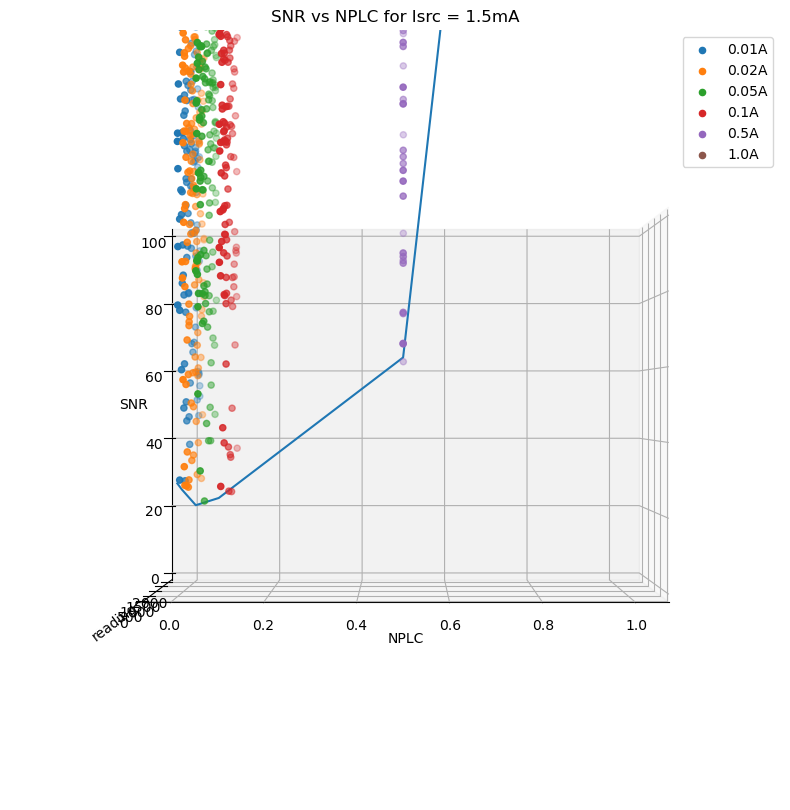

In [ ]:
# %matplotlib qt
%matplotlib inline
readings_l = np.linspace(1,np.shape(snr_nplc_anom_arr_l)[1],np.shape(snr_nplc_anom_arr_l)[1])
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

for i in range(len(nplc_arr)):
    ax.scatter(nplc_arr[i], readings_l, snr_nplc_homg_arr_l[i],label=f"{nplc_arr[i]}A")
ax.plot(nplc_arr,np.zeros(len(nplc_arr)),np.min(np.array(snr_nplc_homg_arr_l),1),'-')
ax.set_xlabel('NPLC')
ax.set_ylabel('reading')
ax.set_zlabel('SNR')
ax.set_zlim(0,100)
ax.view_init(0,-90,0)
ax.legend()
ax.set_title(f'SNR vs NPLC for Isrc = {i_src_str}')

##### Comparing both Isrc and NPLC values vs SNR

Create a 2D mesh to see any obvious min/max. 

In [ ]:
%matplotlib inline
# %matplotlib qt


i_src_arr = [100e-6, 500e-6, 1e-3, 1.25e-3, 1.5e-3, 2e-3, 5e-3]
i_src_str_arr = ['100uA', '500uA', '1mA', '1.25mA', '1.5mA','2mA','5mA']
nplc_arr = np.array([0.01, 0.02, 0.05, 0.1, 0.5, 1])
nplc_str_arr = nplc_arr.astype(str)

mse_isrc_nplc_homg_arr = np.zeros((len(i_src_arr),len(nplc_str_arr))) # MSEs
mse_isrc_nplc_anom_arr = np.zeros((len(i_src_arr),len(nplc_str_arr)))
snr_min_isrc_nplc_homg_arr = np.zeros((len(i_src_arr),len(nplc_str_arr))) # SNR mins
snr_min_isrc_nplc_anom_arr = np.zeros((len(i_src_arr),len(nplc_str_arr)))
std_isrc_nplc_homg_arr = np.zeros((len(i_src_arr),len(nplc_str_arr))) # Stdevs
std_isrc_nplc_anom_arr = np.zeros((len(i_src_arr),len(nplc_str_arr)))


for i in range(len(i_src_arr)):
    for n in range(len(nplc_str_arr)):
        i_src = i_src_arr[i]
        i_src_str = i_src_str_arr[i]
        nplc_str = nplc_str_arr[n]
        
        # INPUT phantom mesh .cir netlist files:
        resmeshpcb_2k2 = esim.ErtSim(r'..\KiCAD_scripting\Kicad_netlist_pyspice_sim\resistor_network_2k2.cir', i_src, num_elecs) #add 'r' before file string
        resmeshpcb_2k2_anom_3k3 = esim.ErtSim(r'..\KiCAD_scripting\Kicad_netlist_pyspice_sim\resistor_network_3k3_pcb_anom_2k2_bg.cir', i_src, num_elecs)

        sim_data = resmeshpcb_2k2.run_sim()
        sim_data_anom = resmeshpcb_2k2_anom_3k3.run_sim()

        elec_data_sim = resmeshpcb_2k2.get_elec_data()
        # elec_data_sim = elec_data_sim[1:256] + [elec_data_sim[0]] # shift data one
        elec_data_sim_anom = resmeshpcb_2k2_anom_3k3.get_elec_data()
        # elec_data_sim_anom = elec_data_sim_anom[1:256] + [elec_data_sim_anom[0]] # shift data one

        # INPUT raw ERT voltage measurement sequence:
        #   note: length of these changes file to file
        raw_homg_data_V = f"../PCB_MUX/data/res_mesh_2k2_{i_src_str}_nplc{nplc_str}.csv" # res mesh (2k2) reading at using 1mA adj pattern
        raw_anom_data_V = f"../PCB_MUX/data/res_mesh_2k2_3k3_anom_{i_src_str}_nplc{nplc_str}.csv" # res mesh (2k2 + 3k3 bg anom) reading at using 1mA adj pattern

        elec_data_homg_l = pd.read_csv(raw_homg_data_V,skiprows=1)
        elec_data_homg_l['voltage [V]'][1:-1] = elec_data_homg_l['voltage [V]'][0:-2] # shift all readings by one
        elec_data_homg_l['voltage [V]'][0] = elec_data_homg_l['voltage [V]'][num_elecs**2]

        elec_data_anom_l = pd.read_csv(raw_anom_data_V,skiprows=1) 
        elec_data_anom_l['voltage [V]'][1:-1] = elec_data_anom_l['voltage [V]'][0:-2] # shift all readings by one
        elec_data_anom_l['voltage [V]'][0] = elec_data_anom_l['voltage [V]'][num_elecs**2]

        print(f"for Isrsc = {i_src_str}")
        print(f"for NPLC = {nplc_str}")


        # homogeneous error plots -
        elec_cycles_homg = len(elec_data_homg_l['voltage [V]'])//num_elecs**2
        # iterate through real homg measurements and calculate error and SNRs
        elec_er_data_homg_l, elec_snr_data_homg_l = calc_vmeas_noise(elec_data_sim, elec_data_homg_l['voltage [V]'], elec_cycles_homg, plot=False)
        mse_isrc_nplc_homg_arr[i,n] = sum(np.array(elec_er_data_homg_l)**2)/len(elec_er_data_homg_l)
        snr_min_isrc_nplc_homg_arr[i,n] = np.min(elec_snr_data_homg_l)
        data_homg_mean, data_homg_std = stats.norm.fit(elec_er_data_homg_l)
        std_isrc_nplc_homg_arr[i,n] = data_homg_std
        print(f"homogeneous DUT meas {i},{n}")

        # anomaly error plots -
        elec_cycles_anom = len(elec_data_anom_l['voltage [V]'])//num_elecs**2
        # iterate through real anom measurements and calculate error and SNRs
        elec_er_data_anom_l, elec_snr_data_anom_l = calc_vmeas_noise(elec_data_sim_anom, elec_data_anom_l['voltage [V]'], elec_cycles_anom, plot=False)
        mse_isrc_nplc_anom_arr[i,n] = sum(np.array(elec_er_data_anom_l)**2)/len(elec_er_data_anom_l)
        snr_min_isrc_nplc_anom_arr[i,n] = np.min(elec_snr_data_anom_l)
        data_anom_mean, data_anom_std = stats.norm.fit(elec_er_data_anom_l)
        std_isrc_nplc_anom_arr[i,n] = data_anom_mean
        print(f"anomaly DUT meas {i},{n}")




for Isrsc = 100uA
for NPLC = 0.01
num of elec cycles 10
homogeneous DUT meas 0,0
num of elec cycles 10
anomaly DUT meas 0,0
for Isrsc = 100uA
for NPLC = 0.02
num of elec cycles 10
homogeneous DUT meas 0,1
num of elec cycles 10
anomaly DUT meas 0,1
for Isrsc = 100uA
for NPLC = 0.05
num of elec cycles 10
homogeneous DUT meas 0,2
num of elec cycles 10
anomaly DUT meas 0,2
for Isrsc = 100uA
for NPLC = 0.1
num of elec cycles 10
homogeneous DUT meas 0,3
num of elec cycles 10
anomaly DUT meas 0,3
for Isrsc = 100uA
for NPLC = 0.5
num of elec cycles 10
homogeneous DUT meas 0,4
num of elec cycles 10
anomaly DUT meas 0,4
for Isrsc = 100uA
for NPLC = 1.0
num of elec cycles 10
homogeneous DUT meas 0,5
num of elec cycles 10
anomaly DUT meas 0,5
for Isrsc = 500uA
for NPLC = 0.01
num of elec cycles 10
homogeneous DUT meas 1,0
num of elec cycles 10
anomaly DUT meas 1,0
for Isrsc = 500uA
for NPLC = 0.02
num of elec cycles 10
homogeneous DUT meas 1,1
num of elec cycles 10
anomaly DUT meas 1,1
for Isrsc =

In [ ]:
import pickle as pkl
import os
# save data in .pkl format
filename = "snr_vs_isrc_and_nplc"
if os.path.isfile(filename+'.pkl'): # check if has already generated a solution
    with open(filename+".pkl","rb") as fp:
        i_src_arr = pkl.load(fp)
        nplc_arr = pkl.load(fp)
        snr_min_isrc_anom_arr = pkl.load(fp)
        std_isrc_anom_arr = pkl.load(fp)

else:
    with open(filename+".pkl","wb") as fp:
        pkl.dump(i_src_arr,fp)
        pkl.dump(nplc_arr,fp)
        pkl.dump(snr_min_isrc_anom_arr,fp)
        pkl.dump(std_isrc_anom_arr,fp)


##### Generate a SNR and Variance 3D plots

showing

1. SNR 
2. Std

both as a functions of Isrc and NPLC

In [ ]:
%matplotlib qt
# %matplotlib inline
# Make data 3d plottable
i_src_arr_msh, nplc_arr_msh = np. meshgrid(i_src_arr, nplc_arr)

## SNR plot
# Plot the surface.
fig, ax = plt.subplots(figsize=(20,12),subplot_kw={"projection": "3d"})
surf = ax.plot_surface(i_src_arr_msh, nplc_arr_msh, np.transpose(snr_min_isrc_anom_arr), cmap=cm.coolwarm)
# Customize the axes.
ax.set_zlim(np.min(snr_min_isrc_anom_arr), np.max(snr_min_isrc_anom_arr))
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
# ax.set_ylim = (np.min(nplc_arr_msh),np.max(nplc_arr_msh))
# ax.set_xlim = (np.min(i_src_arr_msh),np.max(i_src_arr_msh))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.xlabel('Isrc [A]')
plt.ylabel('NPLC')
ax.set_zlabel('SNR')
plt.title("Empirically found objective function for the SNR")
plt.show()

## Stdev plot
# Plot the surface.
fig, ax = plt.subplots(figsize=(20,12),subplot_kw={"projection": "3d"})
surf = ax.plot_surface(i_src_arr_msh, nplc_arr_msh, np.transpose(std_isrc_anom_arr), cmap=cm.coolwarm)
# Customize the axes.
ax.set_zlim(np.min(std_isrc_anom_arr), np.max(std_isrc_anom_arr))
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
# ax.set_ylim = (np.min(nplc_arr_msh),np.max(nplc_arr_msh))
# ax.set_xlim = (np.min(i_src_arr_msh),np.max(i_src_arr_msh))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.xlabel('Isrc [A]')
plt.ylabel('NPLC')
ax.set_zlabel('Std [V]')
plt.title("Empirically found objective function for the Std")
plt.show()

##### Bivariate optimisation weighting

We want to have the best quality results as fast as possible. 

To further constrain this bivariate ( $f_{sample}$ and $SNR$ ) optimisation we would like to have a higher weighting on the sample frequency than the SNR.

$V_{max} = 20V$

$R_{max_{dut}} = ?$

$I_{max_{src}} = V_{max} / R_{max_{dut}}$

Below we have an example plot for the max allowable Isrc:

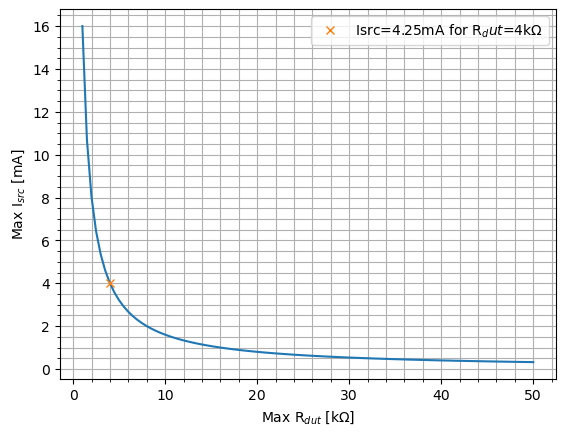

In [ ]:
Rmax_kOhm = 4 # Insert max DUT resistance inbetween adjacent electrodes
Vmax_V = 20 # 
Rmax_dut_kOhm = np.linspace(1, 50, 100)
Isrc_max_mA = lambda Rmax_dut: (0.85*Vmax)/Rmax_dut
plt.plot(Rmax_dut,Isrc_max(Rmax_dut))
plt.plot(4, Isrc_max(4),'x',label=f"Isrc={Isrc_max_mA(Rmax_kOhm)}mA for R$_{'dut'}$={Rmax_kOhm}k$\Omega$")
plt.xlabel('Max R$_{dut}$ [k$\Omega$]')
plt.ylabel('Max I$_{src}$ [mA]')
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor')
plt.legend()

##### Compare integration time of SMU vs serial query time 

each Vmeas reading takes ~1ms with an NPLC of 0.01, i.e. 0.01/50 = 200us. So we have ~800us over overhead for the Vmeas query process.

So we should have a relationship between NPLC and query freq:

$f_q = nplc/50 + 800us$

Text(0, 0.5, 'Query frequency (incl. sample + serial times) [Hz]')

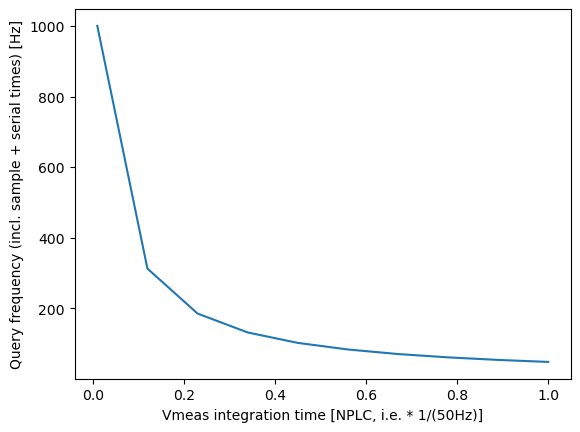

In [ ]:
nplc = np.linspace(0.01,1,10)
fq = lambda x: 1/(x/50 + 800e-6) # 800us query time

plt.plot(nplc,fq(nplc))
plt.xlabel('Vmeas integration time [NPLC, i.e. * 1/(50Hz)]')
plt.ylabel('Query frequency (incl. sample + serial times) [Hz]')

## Part B - EIDORS reconstruction analysis

Now we must determine the allowable SNR that will give a sufficiently good reconstruction. 

The goodness of fit will be given be the Rsqr value of the simulated system vs the real measurements (with inherent noise) and a simulated noisy system.

In [2]:
# load libs
import matlab.engine
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D, art3d
import os
import numpy as np
import pandas as pd
import pickle as pkl

num_elecs = 16 # ;)

print("Matlab engine loading...")
ml_eng = matlab.engine.start_matlab()
print("Loaded!")

# input EIDORS function directory path
pth2 = ml_eng.genpath('..\EIDORS\eidors-v3.10-ng\eidors\ert_black_sensor')
ml_eng.addpath(pth2, nargout=0)
# load eidors startup.m?

Matlab engine loading...
Loaded!


In [3]:
# load specific recon functions

# Function to reformat image data
def ml2py_fem(recon_fem_obj):
    '''
    Takes a Matlab FEM struct with sections 'data', 'nodes', and 'elems' and reformats them such that they are all usable for FEM 
    plotting in python with plot_fem() 
    '''
    recon_data_ = np.array(recon_fem_obj['data'])
    recon_nodes_ = np.array(recon_fem_obj['nodes'])
    recon_elems_ = np.array(recon_fem_obj['elems']) - 1
    
    recon_data = recon_data_
    recon_nodes = np.zeros((len(recon_nodes_), 3))
    recon_nodes[:,0:2] = recon_nodes_
    recon_elems = recon_elems_.astype(int)

    # check if data has been extrapolated by 2x (because EIDORS does this for square mesh reconstructions...)
    if 2*len(recon_data_) == len(recon_elems_):
        recon_data = np.zeros(len(recon_elems_))
        for i in range(int(len(recon_data)/2)):
            recon_data[-(i)*2-1] = recon_data_[i]
            recon_data[-(i)*2-2] = recon_data[-(i)*2-1]
    return recon_data, recon_nodes, recon_elems

def plot_fem(elem_data, nodes, elems, xy_lim=1.1, title=''):
    '''
    Takes meshed 2D FEM data in the form and plots it
    '''
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection="3d")

    norm = plt.Normalize(elem_data.min(), elem_data.max())
    colors = plt.cm.inferno(norm(elem_data))

    norm_cb = mpl.colors.Normalize(vmin=elem_data.min(),vmax=elem_data.max())

    pc = art3d.Poly3DCollection(nodes[elems],facecolors=colors,cmap='inferno',norm=norm_cb,edgecolor="black")
    ax.add_collection(pc)

    ax.view_init(elev=90, azim=270)
    ax.set_xlim3d(-xy_lim,xy_lim)
    ax.set_ylim3d(-xy_lim,xy_lim)

    # Hide the Z axis
    ax.zaxis.line.set_lw(0.)
    ax.set_zticks([])

    # Change xyz plane colours to white
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    # Remove gridlines
    ax.xaxis._axinfo["grid"].update({"linewidth":0})
    ax.yaxis._axinfo["grid"].update({"linewidth":0})
    ax.dist=xy_lim*5

    # Add colour bar
    cbar = plt.colorbar(pc,ax=ax)
    cbar.set_label('$\Delta$R')

    # Label axes
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()
    

# Save image reconstruction data to save time re-solving through Matlab

def save_recon(elem_data, nodes, elems, filename):
    '''
    Save reconstruction data as compressed .pkl file
    '''
    with open(filename+".pkl","wb") as fp:
        pkl.dump(elem_data,fp)
        pkl.dump(nodes,fp)
        pkl.dump(elems,fp)
        
    
    return 0

def load_recon(elem_data, nodes, elems, filename):
    '''
    Load reconstruction data as compressed .pkl file
    '''
    with open(filename+".pkl","rb") as fp:
        elem_data = pkl.load(fp)
        nodes = pkl.load(fp)
        elems = pkl.load(fp)
    
    return elem_data,nodes,elems


### 1.0 Reconstruct with voltage data using the Matlab EIDORS toolbox


#### 1.1 Run reconstruction for sim data

In [5]:
# Define simulation data
i_src = 100e-6
resmeshpcb_2k2 = esim.ErtSim(r'..\KiCAD_scripting\Kicad_netlist_pyspice_sim\resistor_network_2k2.cir', i_src, num_elecs) #add 'r' before file string
resmeshpcb_2k2_anom_3k3 = esim.ErtSim(r'..\KiCAD_scripting\Kicad_netlist_pyspice_sim\resistor_network_3k3_pcb_anom_2k2_bg.cir', i_src, num_elecs)
sim_data = resmeshpcb_2k2.run_sim()
sim_data_anom = resmeshpcb_2k2_anom_3k3.run_sim()
elec_data_sim = resmeshpcb_2k2.get_elec_data()
# elec_data_sim = elec_data_sim[1:256] + [elec_data_sim[0]] # shift data one
elec_data_sim_anom = resmeshpcb_2k2_anom_3k3.get_elec_data()
# elec_data_sim_anom = elec_data_sim_anom[1:256] + [elec_data_sim_anom[0]] # shift data one

# Run inverse solver
if not os.path.isfile('sim_recon.pkl'): # check if solver has already generated a solution
    print("Running EIDORS inverse solver...")
    recon_fem_obj_sim = ml_eng.square_recon(matlab.double(elec_data_sim), matlab.double(elec_data_sim_anom))
    print("Solved!")
    elem_data, nodes, elems = ml2py_fem(recon_fem_obj_sim)
    save_recon(elem_data, nodes, elems, "sim_recon")
else:
    # generate empty variable names
    elem_data = []
    nodes = []
    elems = []

# test load .pkl file
elem_data_sim, nodes_sim, elems_sim = load_recon(elem_data, nodes, elems, "sim_recon")

# plot the simulated resistor network anomaly
plot_fem(elem_data_sim, nodes_sim, elems_sim,title="Image reconstruction of '%s'" % resmeshpcb_2k2)

NameError: name 'esim' is not defined

#### 1.2 Run reconstruction for the real data

Create a reconstruction using voltage measurement data gathered from the real DUT. 

In [5]:
# run a reconstruction on the real data
i_src_str = '1.5mA'
nplc_str = '0.01'

raw_homg_data_V = f"../PCB_MUX/data/res_mesh_2k2_{i_src_str}_nplc{nplc_str}.csv" # res mesh (2k2) reading at using 1mA adj pattern
raw_anom_data_V = f"../PCB_MUX/data/res_mesh_2k2_3k3_anom_{i_src_str}_nplc{nplc_str}.csv" # res mesh (2k2 + 3k3 bg anom) reading at using 1mA adj pattern

elec_data_homg_l = pd.read_csv(raw_homg_data_V,skiprows=1)
elec_data_homg_l['voltage [V]'][1:-1] = elec_data_homg_l['voltage [V]'][0:-2] # shift all readings by one
elec_data_homg_l['voltage [V]'][0] = elec_data_homg_l['voltage [V]'][num_elecs**2]

elec_data_anom_l = pd.read_csv(raw_anom_data_V,skiprows=1) 
elec_data_anom_l['voltage [V]'][1:-1] = elec_data_anom_l['voltage [V]'][0:-2] # shift all readings by one
elec_data_anom_l['voltage [V]'][0] = elec_data_anom_l['voltage [V]'][num_elecs**2]

if os.path.isfile('r_recon.pkl'): # check if solver has already generated a solution
    print("Running EIDORS inverse solver...")
    recon_fem_obj_r = ml_eng.square_recon(matlab.double(elec_data_homg_l['voltage [V]'][0:256]), matlab.double(elec_data_anom_l['voltage [V]'][0:256])) # using simulated anomaly b/c real resistor mesh has defect
    print("Solved!")
    elem_data, nodes, elems = ml2py_fem(recon_fem_obj_r)
    save_recon(elem_data, nodes, elems, "r_recon")

# test load .pkl file
elem_data_r, nodes_r, elems_r = load_recon(elem_data, nodes, elems, "r_recon")
# normalise
elem_data_sim_norm = elem_data_sim/np.max(elem_data_sim)
elem_data_r_norm = elem_data_r/np.max(elem_data_r)

# plot 
plot_fem(elem_data_r_norm, nodes_r, elems_r,title="Image reconstruction of \n '%s'" % raw_homg_data_V)
plot_fem(elem_data_sim_norm - elem_data_r_norm, nodes_r, elems_r,title="Image reconstruction of \n '%s' error" % raw_homg_data_V)


Running EIDORS inverse solver...
Solved!


NameError: name 'elem_data_sim' is not defined

#### 1.3 Run reconstruction for noisy sim data

In Part A-3.0 we formed a noise model from real measurement data with the form:

$V_{sim_n} = V_{sim} + random.normal(\mu(V_{meas}),\sigma(V_{meas}))$

Next we apply this model to the simluated data to check how it affects the reconstruction quality.

In [ ]:
std_isrc_homg_arr

[0.0001602154718991474,
 0.00010906136739840978,
 0.0001100629194105295,
 0.00014259826971441494,
 0.00014615429972517137,
 0.00015713768468734505,
 0.00016821921967438678]

Running EIDORS inverse solver...
Solved!


C:\Users\rel80\AppData\Local\Temp\ipykernel_31716\19425751.py:32: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist=xy_lim*5


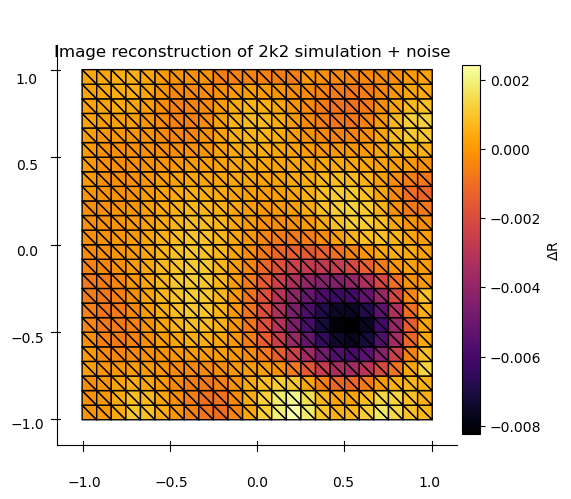

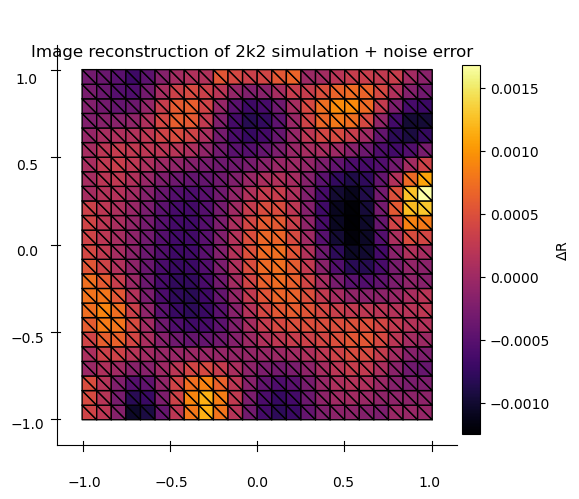

In [ ]:
# %matplotlib inline

# Add noise to simulated data
elec_data_sim_n = np.zeros(np.shape(elec_data_sim))
elec_data_sim_anom_n = np.zeros(np.shape(elec_data_sim_anom))
for i in range(len(elec_data_sim)):
    elec_data_sim_n[i] = elec_data_sim[i] + np.random.normal(scale=std_isrc_nplc_homg_arr[4][0]) # use std found from real data in PtA-3.3
    elec_data_sim_anom_n[i] = elec_data_sim_anom[i] + np.random.normal(scale=std_isrc_nplc_anom_arr[4][0])

# run a reconstruction on the simulation data + modelled noise(error)
if os.path.isfile('n_recon.pkl'): # check if solver has already generated a solution
        print("Running EIDORS inverse solver...")
        recon_fem_obj_n = ml_eng.square_recon(matlab.double(elec_data_sim_n), matlab.double(elec_data_sim_anom_n))
        print("Solved!")
        elem_data, nodes, elems = ml2py_fem(recon_fem_obj_n)
        save_recon(elem_data, nodes, elems, "n_recon")

# test load .pkl file
elem_data_n, nodes_n, elems_n = load_recon(elem_data, nodes, elems, "n_recon")
plot_fem(elem_data_n, nodes_n, elems_n,title="Image reconstruction of 2k2 simulation + noise")
plot_fem(elem_data_sim-elem_data_n, nodes_n, elems_n,title="Image reconstruction of 2k2 simulation + noise error")

### 2.0 Quantify the reconstruction qualities

C:\Users\rel80\AppData\Local\Temp\ipykernel_31716\19425751.py:32: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist=xy_lim*5


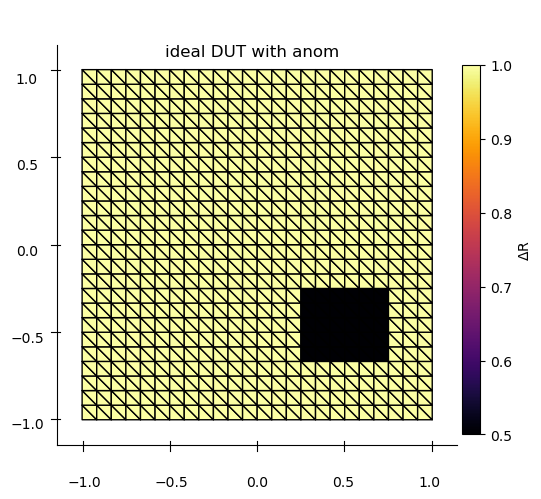

In [ ]:
# function to add square to an exisiting mesh domain

def make_sqr_anom(nodes, elems, corners_x, corners_y, bg_res=1, anom_res=0.5):
    '''
    Function to make square anomaly data on a given mesh domain defined by v and f and a list of the 2 defining corner x & y coordinates for the square.
    corners_x is [x0,x1] and corners_y = [y0,y1]
    such that:
            x-----------x = (x1,y1)
            |           |
            |           |
            x-----------x
            = (x0,y0)
     y|
      |____x
    (0,0)
    '''
    elem_data_dut = np.ones(len(elems)) * bg_res
    anom_nodes = np.array([])
    for elem in range(len(elems)):
        elem_com_x = (nodes[elems[elem][0]][0] + nodes[elems[elem][1]][0] + nodes[elems[elem][2]][0])/3
        elem_com_y = (nodes[elems[elem][0]][1] + nodes[elems[elem][1]][1] + nodes[elems[elem][2]][1])/3
        if (corners_x[0] <= elem_com_x <= corners_x[1]) and (corners_y[0] <= elem_com_y <= corners_y[1]):
            elem_data_dut[elem] = anom_res
            # print('hit')
    return elem_data_dut

# define anom (added ~.15 to box bounds)
x_crns = np.array([0.26, 0.76])
y_crns = np.array([-0.64,-0.26])

# create a DUT that's scaled WRT the 1st and 99th percentile of the 
elem_data_dut = make_sqr_anom(nodes, elems, x_crns, y_crns)

plot_fem(elem_data_dut,nodes_r,elems_r,title="ideal DUT with anom")

##### 2.1 Scaled ideal DUT vs reconstruction error

C:\Users\rel80\AppData\Local\Temp\ipykernel_31716\19425751.py:32: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist=xy_lim*5


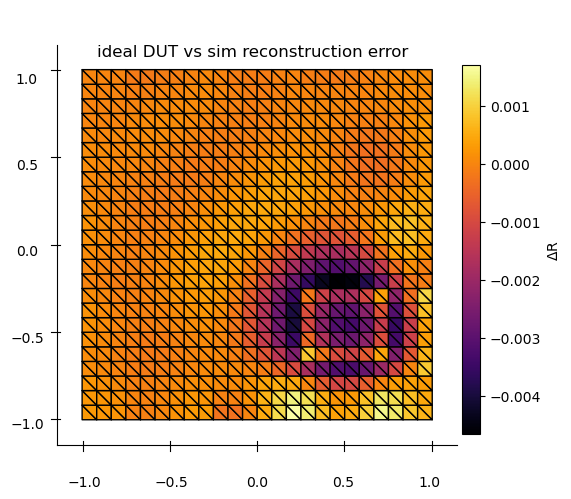

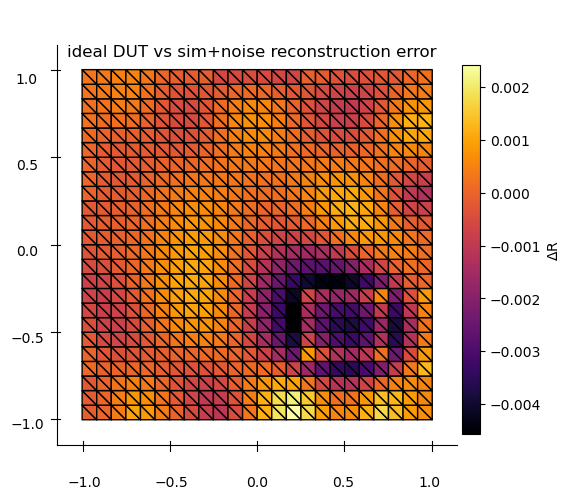

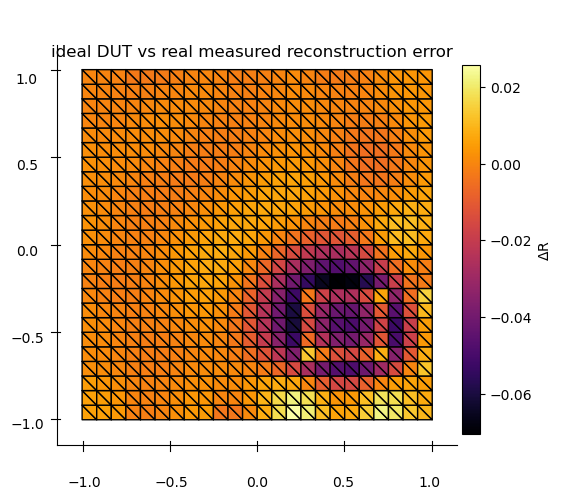

In [ ]:
# assuming the median represents the background resistance and the lower percentile represents the anomaly
lo_p = 5
# create a DUT that's scaled WRT the 1st and 99th percentile of the sim recon data
elem_data_dut = make_sqr_anom(nodes, elems, x_crns, y_crns, bg_res=np.median(elem_data_sim), anom_res=np.percentile(elem_data_sim,lo_p))
elem_err_sim_id = elem_data_sim - elem_data_dut
plot_fem(elem_err_sim_id,nodes,elems,title="ideal DUT vs sim reconstruction error")

# create a DUT that's scaled WRT the 1st and 99th percentile of the sim+noise recon data
elem_data_dut = make_sqr_anom(nodes, elems, x_crns, y_crns, bg_res=np.median(elem_data_n), anom_res=np.percentile(elem_data_n,lo_p))
elem_err_n_id = elem_data_n - elem_data_dut
plot_fem(elem_err_n_id,nodes,elems,title="ideal DUT vs sim+noise reconstruction error")

# create a DUT that's scaled WRT the 1st and 99th percentile of the real meas recon data
elem_data_dut = make_sqr_anom(nodes, elems, x_crns, y_crns, bg_res=np.median(elem_data_r), anom_res=np.percentile(elem_data_r,lo_p))
elem_err_r_id = elem_data_r - elem_data_dut
plot_fem(elem_err_r_id,nodes,elems,title="ideal DUT vs real measured reconstruction error")

##### 2.2.2 Simulated reconstruction vs noisy reconstruction error

C:\Users\rel80\AppData\Local\Temp\ipykernel_31716\19425751.py:32: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist=xy_lim*5


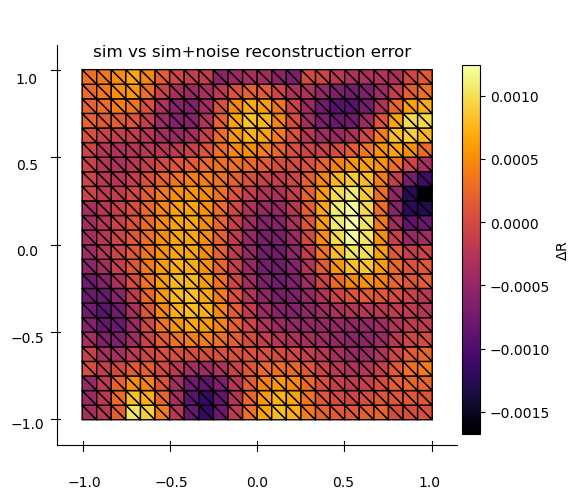

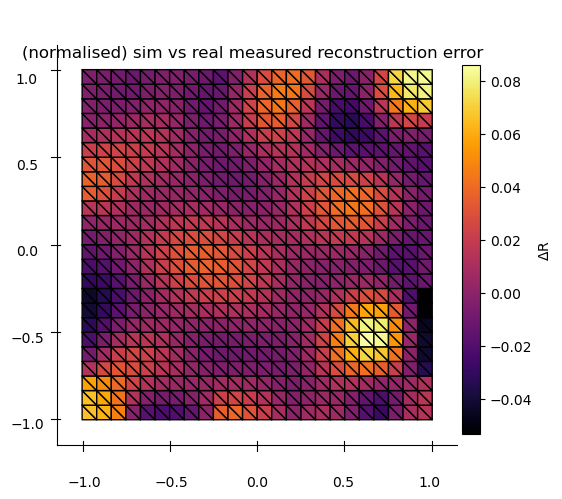

In [ ]:
elem_err_n_sim = elem_data_n - elem_data_sim
plot_fem(elem_err_n_sim, nodes, elems,title="sim vs sim+noise reconstruction error")

elem_err_r_sim_norm = elem_data_r_norm - elem_data_sim_norm
plot_fem(elem_err_r_sim_norm, nodes, elems,title="(normalised) sim vs real measured reconstruction error")

#### 2.2 Mean square error and $R^2$ values
$MSE=\frac{1}{n}\Sigma(y−\hat y)^2$

$R^2=1-\frac{MSE}{Var(y)}$

##### 2.2.1 MSE based on scaled ideal DUT vs reconstructions

Where $\hat y$ are the ideal DUT values and $y$ are the reconstructed values, for $n$ elements.

In [ ]:
mse_sim_id = np.square(elem_err_sim_id).mean()
mse_n_id = np.square(elem_err_n_id).mean()
mse_r_id = np.square(elem_err_r_id).mean()

print(f"MSEs:\nmse_sim_ideal = {mse_sim_id}\nmse_sim+noise_ideal = {mse_n_id}\nmse_real_ideal = {mse_r_id}\n")

MSEs:
mse_sim_ideal = 8.750001016696863e-07
mse_sim+noise_ideal = 1.1781366445538866e-06
mse_real_ideal = 0.0001964235650030748



##### 2.2.1 MSE based on simulated reconstruction vs noisy reconstructions

Where $\hat y$ are the simulated reconstruction values and $y$ are the reconstructed values, for $n$ elements.

In [ ]:
mse_n_sim = np.square(elem_err_n_sim).mean()
mse_r_sim_norm = np.square(elem_err_r_sim_norm).mean()

print(f"MSEs:\nmse_n_sim={mse_n_sim}\nmse_r_sim_norm={mse_r_sim_norm}\n")

rsqr_n_sim = 1 - mse_n_sim/np.var(elem_data_n)
rsqr_r_sim_norm = 1 - mse_r_sim_norm/np.var(elem_data_r_norm)

print(f"Rsqrs:\nrsqr_n_sim={rsqr_n_sim}\nrsqr_r_sim_norm={rsqr_r_sim_norm}\n")

MSEs:
mse_n_sim=2.2408674170428172e-07
mse_r_sim_norm=0.0005414772395650162

Rsqrs:
rsqr_n_sim=0.920628899786323
rsqr_r_sim_norm=0.9993137980765218



### 3.0 Increase noise in system

The next step is to increase the noise in the system by mulitplying the fitted noise parameters increasingly more until an Rsqr value of less than 50% is hit. At this point the 

Running EIDORS inverse solver...
Solved!
0.9836313044417639
0.5
Running EIDORS inverse solver...
Solved!
0.9573852789385696
1.0
Running EIDORS inverse solver...
Solved!
0.8448823330651538
1.5
Running EIDORS inverse solver...
Solved!
0.6940574542063407
2.0
Running EIDORS inverse solver...
Solved!
0.6539972287826726
2.5
Running EIDORS inverse solver...
Solved!
0.6700373434289413
3.0
Running EIDORS inverse solver...
Solved!
0.3467491482016163
3.5


C:\Users\rel80\AppData\Local\Temp\ipykernel_31716\19425751.py:32: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist=xy_lim*5


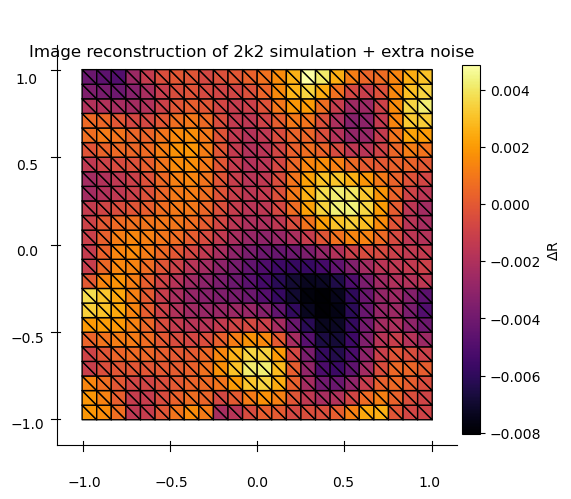

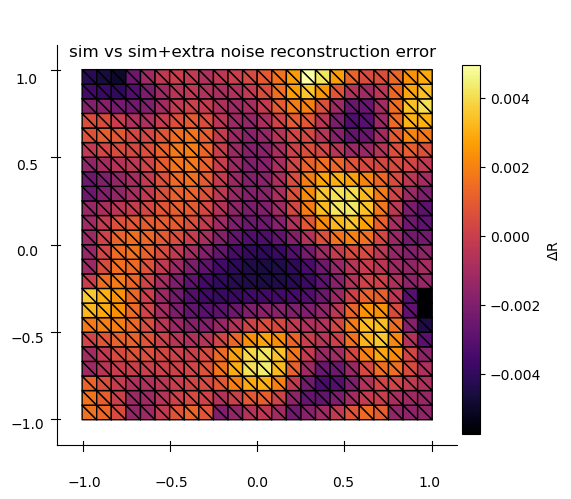

MSEs:
mse_en_sim=3.6715089092640256e-06

Rsqrs:
rsqr_en_sim=0.3467491482016163

Running EIDORS inverse solver...
Solved!
0.9829684759436498
0.5
Running EIDORS inverse solver...
Solved!
0.8845052291280152
1.0
Running EIDORS inverse solver...
Solved!
0.8026095915864555
1.5
Running EIDORS inverse solver...
Solved!
0.7790765602157956
2.0
Running EIDORS inverse solver...
Solved!
0.7379641865500484
2.5
Running EIDORS inverse solver...
Solved!
0.47462395645024036
3.0


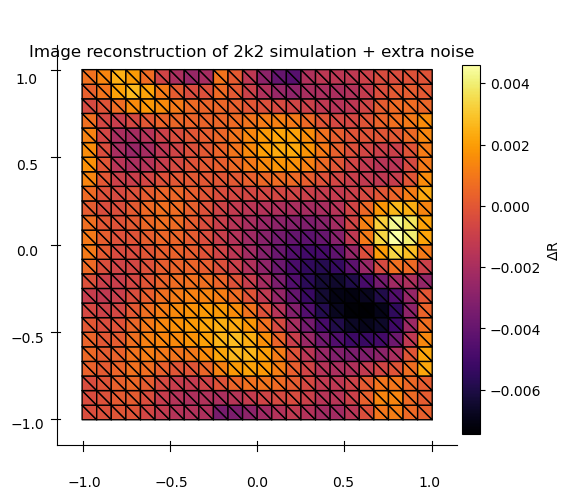

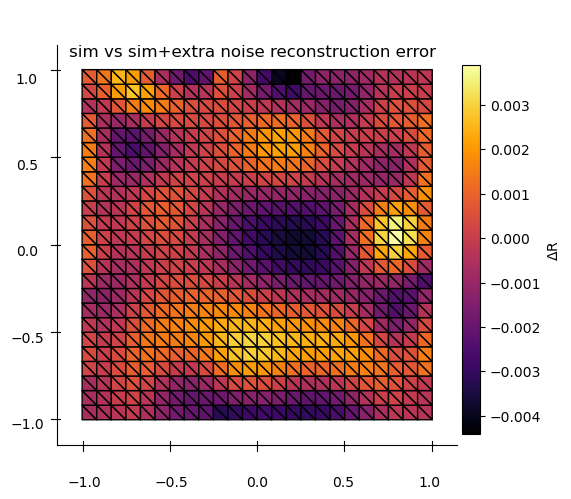

MSEs:
mse_en_sim=2.1183962021484814e-06

Rsqrs:
rsqr_en_sim=0.47462395645024036

Running EIDORS inverse solver...
Solved!
0.9878687319316861
0.5
Running EIDORS inverse solver...
Solved!
0.9238083424919801
1.0
Running EIDORS inverse solver...
Solved!
0.8000419226807021
1.5
Running EIDORS inverse solver...
Solved!
0.7683246238411541
2.0
Running EIDORS inverse solver...
Solved!
0.6128928042891799
2.5
Running EIDORS inverse solver...
Solved!
0.5752652751499846
3.0


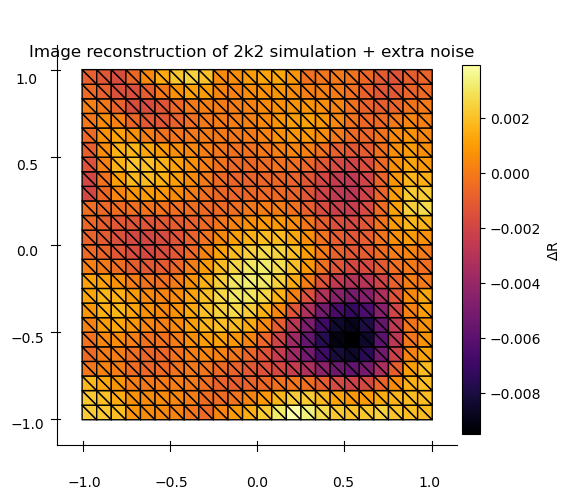

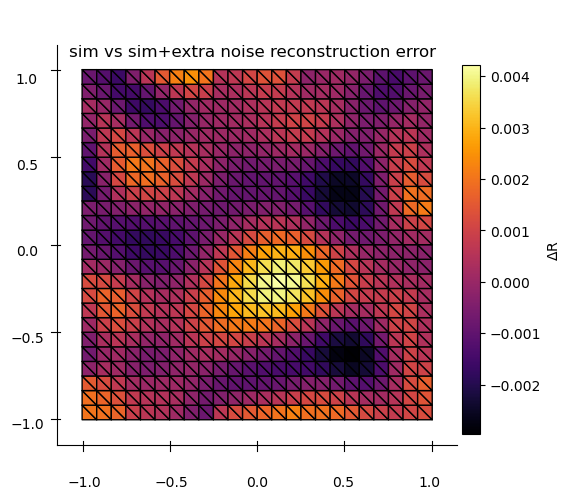

MSEs:
mse_en_sim=1.6412409379307658e-06

Rsqrs:
rsqr_en_sim=0.5752652751499846

Running EIDORS inverse solver...
Solved!
0.9881218359051976
0.5
Running EIDORS inverse solver...
Solved!
0.947776851256051
1.0
Running EIDORS inverse solver...
Solved!
0.7254345703199017
1.5
Running EIDORS inverse solver...
Solved!
0.8523131541738665
2.0
Running EIDORS inverse solver...
Solved!
0.6164999905186406
2.5
Running EIDORS inverse solver...
Solved!
0.5841480179728765
3.0


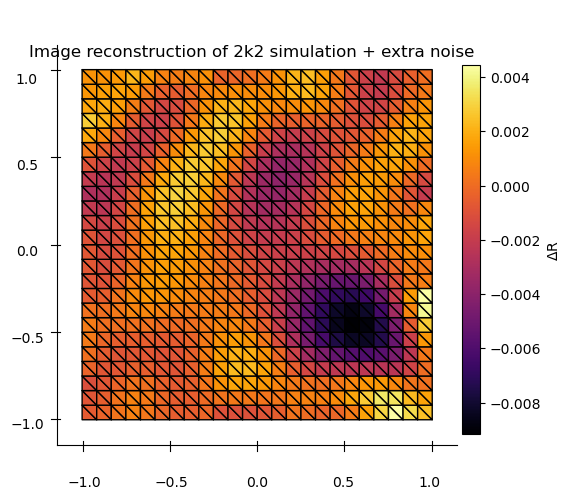

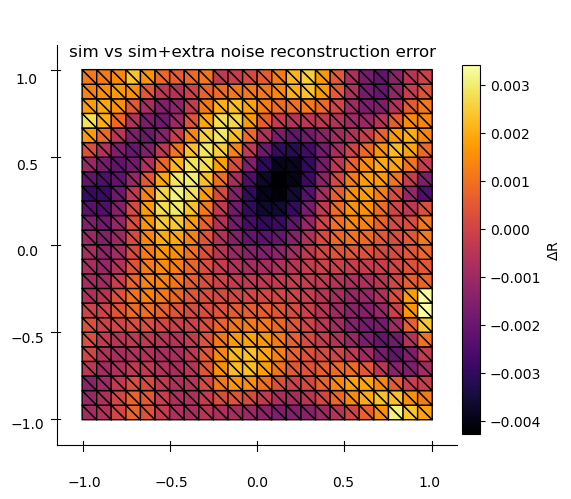

MSEs:
mse_en_sim=1.9806356250950876e-06

Rsqrs:
rsqr_en_sim=0.5841480179728765

Running EIDORS inverse solver...
Solved!
0.9774620607536033
0.5
Running EIDORS inverse solver...
Solved!
0.9101735826216314
1.0
Running EIDORS inverse solver...
Solved!
0.8489196456931939
1.5
Running EIDORS inverse solver...
Solved!
0.7423097786131636
2.0
Running EIDORS inverse solver...
Solved!
0.4508071056760484
2.5


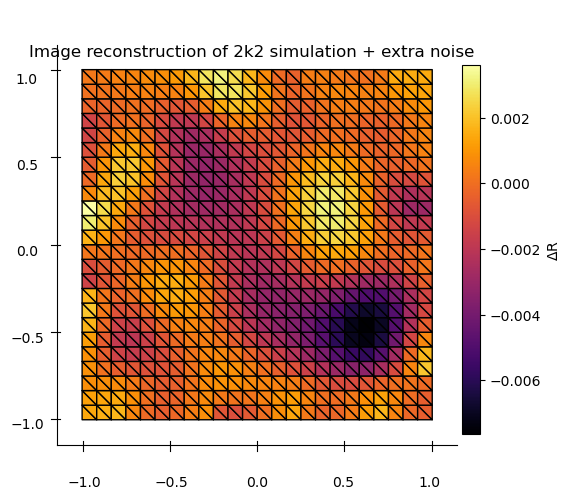

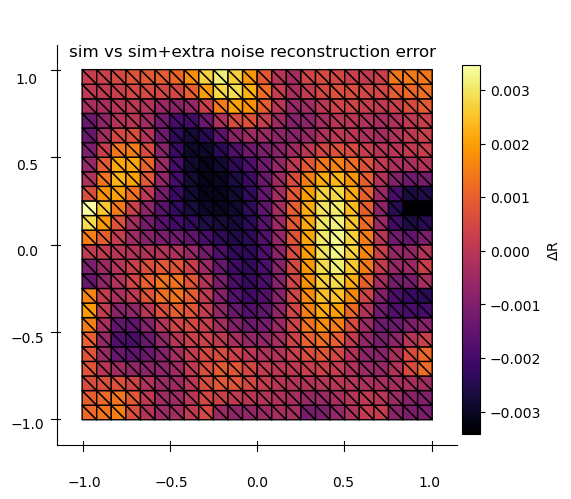

MSEs:
mse_en_sim=1.8398781383236685e-06

Rsqrs:
rsqr_en_sim=0.4508071056760484

Running EIDORS inverse solver...
Solved!
0.9735454001822258
0.5
Running EIDORS inverse solver...
Solved!
0.9088410292073661
1.0
Running EIDORS inverse solver...
Solved!
0.8421662438358889
1.5
Running EIDORS inverse solver...
Solved!
0.761555878743667
2.0
Running EIDORS inverse solver...
Solved!
0.354023243057941
2.5


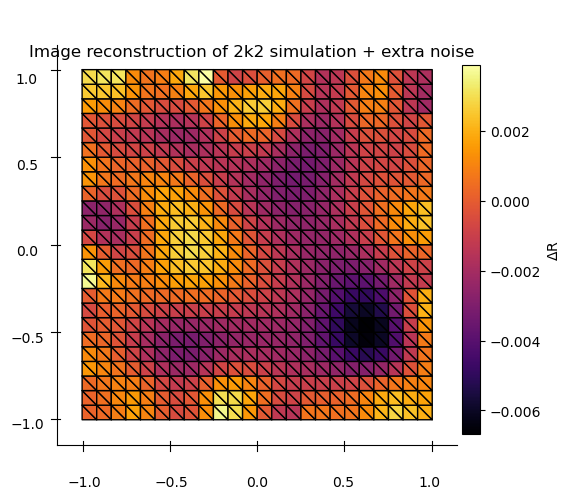

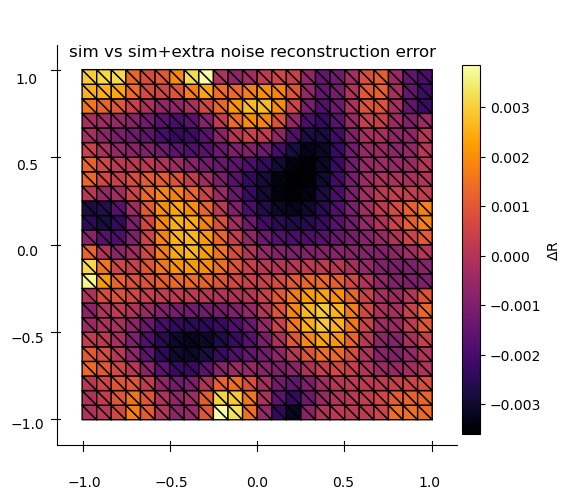

MSEs:
mse_en_sim=2.1966085801202254e-06

Rsqrs:
rsqr_en_sim=0.354023243057941

Running EIDORS inverse solver...
Solved!
0.9756065993319658
0.5
Running EIDORS inverse solver...
Solved!
0.9312676857079454
1.0
Running EIDORS inverse solver...
Solved!
0.8266484720240956
1.5
Running EIDORS inverse solver...
Solved!
0.8499745511976387
2.0
Running EIDORS inverse solver...
Solved!
0.7557314839642635
2.5
Running EIDORS inverse solver...
Solved!
0.7158998678677925
3.0
Running EIDORS inverse solver...
Solved!
0.5191553320820019
3.5


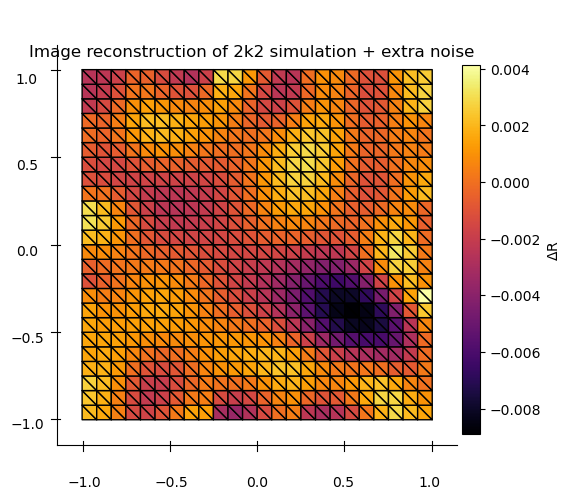

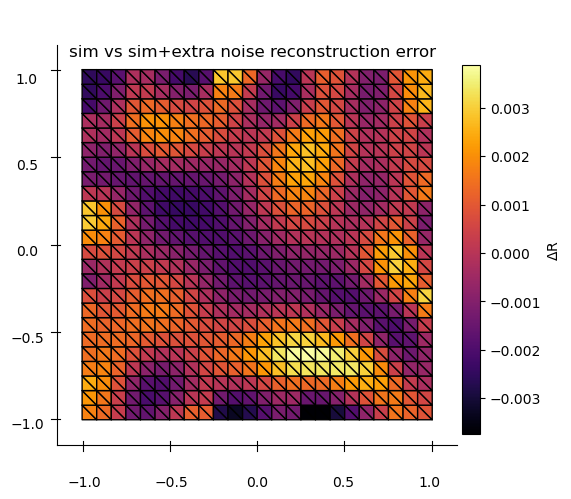

MSEs:
mse_en_sim=2.0741003918239585e-06

Rsqrs:
rsqr_en_sim=0.5191553320820019

Running EIDORS inverse solver...
Solved!
0.981718384198955
0.5
Running EIDORS inverse solver...
Solved!
0.8939418730669375
1.0
Running EIDORS inverse solver...
Solved!
0.8201240950246584
1.5
Running EIDORS inverse solver...
Solved!
0.6755486932618513
2.0
Running EIDORS inverse solver...
Solved!
0.562652870292544
2.5


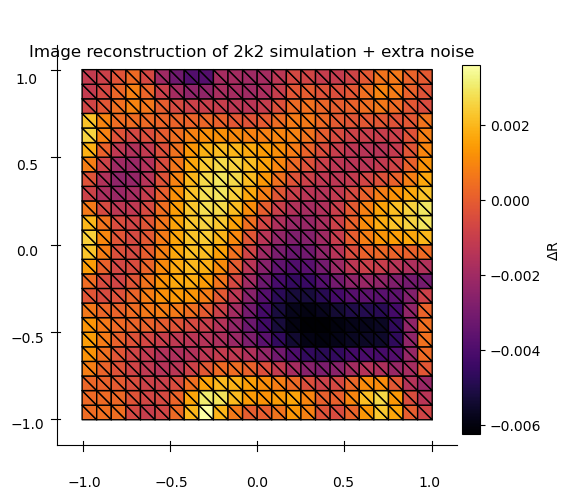

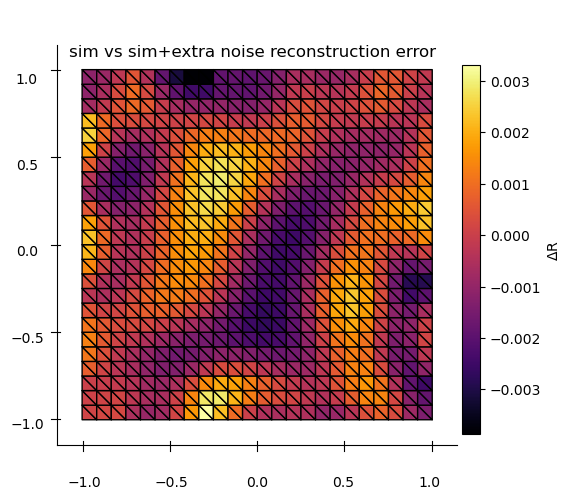

MSEs:
mse_en_sim=1.6729914457632475e-06

Rsqrs:
rsqr_en_sim=0.562652870292544

Running EIDORS inverse solver...
Solved!
0.9745335554777902
0.5
Running EIDORS inverse solver...
Solved!
0.9016926396549562
1.0
Running EIDORS inverse solver...
Solved!
0.8091027797726271
1.5
Running EIDORS inverse solver...
Solved!
0.5736347565243589
2.0


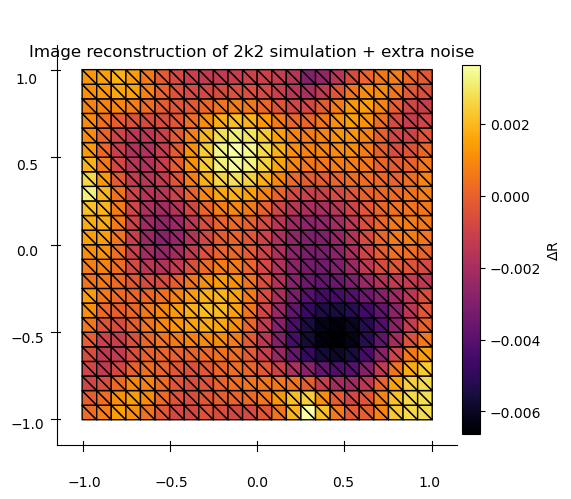

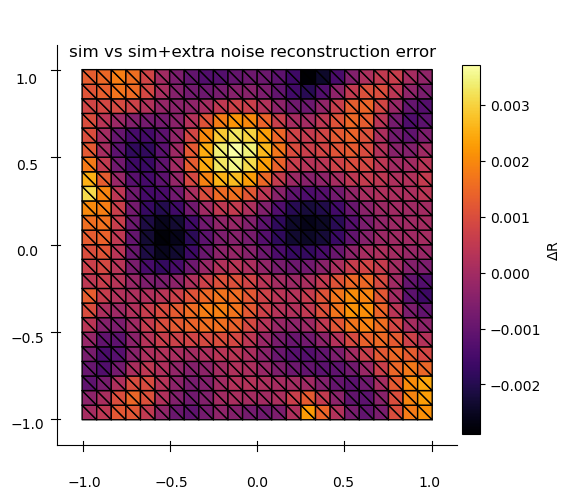

MSEs:
mse_en_sim=1.3736310326923535e-06

Rsqrs:
rsqr_en_sim=0.5736347565243589

Running EIDORS inverse solver...
Solved!
0.9740672451049356
0.5
Running EIDORS inverse solver...
Solved!
0.9166003312961958
1.0
Running EIDORS inverse solver...
Solved!
0.7506052114015312
1.5
Running EIDORS inverse solver...
Solved!
0.7874173764729093
2.0
Running EIDORS inverse solver...
Solved!
0.4601513828363749
2.5


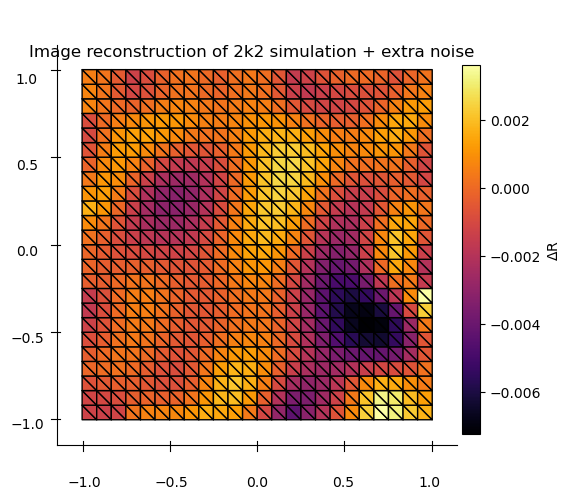

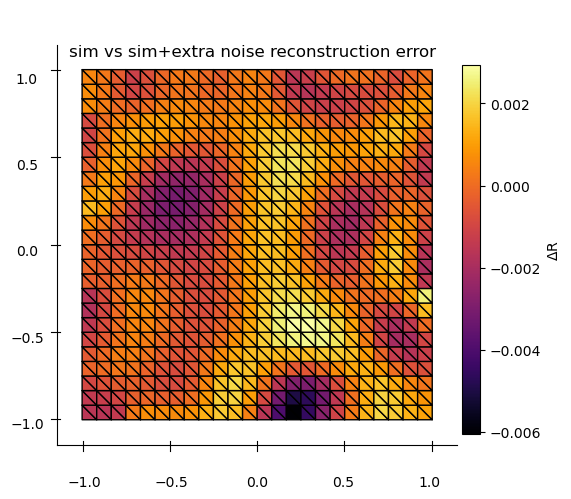

MSEs:
mse_en_sim=1.6322251361248003e-06

Rsqrs:
rsqr_en_sim=0.4601513828363749

avg noise factor: 2.8


In [ ]:
r_sqr_thresh = 0.6

# Add noise to simulated data
elec_data_sim_en = np.zeros(np.shape(elec_data_sim))
elec_data_sim_anom_en = np.zeros(np.shape(elec_data_sim_anom))

noise_factor = []
for test in range(10):
    for nf in range(1,1000):
        # define new extra noisy model
        nf = nf/2
        for i in range(len(elec_data_sim)):
            elec_data_sim_en[i] = elec_data_sim[i] + np.random.normal(scale=std_isrc_nplc_homg_arr[4][0])*nf # use std found from real data in PtA-3.3
            elec_data_sim_anom_en[i] = elec_data_sim_anom[i] + np.random.normal(scale=std_isrc_nplc_anom_arr[4][0])*nf

        # plt.plot(elec_data_sim)
        # plt.plot(elec_data_sim_en)

        print("Running EIDORS inverse solver...")
        recon_fem_obj_en = ml_eng.square_recon(matlab.double(elec_data_sim_en), matlab.double(elec_data_sim_anom_en))
        print("Solved!")
        elem_data, nodes, elems = ml2py_fem(recon_fem_obj_en)
        save_recon(elem_data, nodes, elems, "n2_recon")

        # test load .pkl file
        elem_data_en, nodes_en, elems_en = load_recon(elem_data, nodes, elems, "n2_recon")
        elem_err_en_sim = elem_data_en - elem_data_sim

        mse_en_sim = np.square(elem_err_en_sim).mean()
        rsqr_en_sim = 1 - mse_en_sim/np.var(elem_data_en)

        print(rsqr_en_sim)
        print(nf)

        if rsqr_en_sim < r_sqr_thresh:
            break

    noise_factor.append(nf)

    # plot extra noisy recon
    plot_fem(elem_data_en, nodes_en, elems_en,title="Image reconstruction of 2k2 simulation + extra noise")

    # plot extra noisy reconstruction error
    elem_err_en_sim = elem_data_en - elem_data_sim
    plot_fem(elem_err_en_sim,nodes,elems,title="sim vs sim+extra noise reconstruction error")

    mse_en_sim = np.square(elem_err_en_sim).mean()

    print(f"MSEs:\nmse_en_sim={mse_en_sim}\n")

    rsqr_en_sim = 1 - mse_en_sim/np.var(elem_data_en)

    print(f"Rsqrs:\nrsqr_en_sim={rsqr_en_sim}\n")

print(f"avg noise factor: {sum(noise_factor)/len(noise_factor)}")

In [ ]:
# find extra-noise error values
elec_data_er_en = elec_data_sim - elec_data_sim_en
elec_data_er_en_df = pd.DataFrame(abs(elec_data_er_en),columns=['error[V]'])
elec_data_er_en_df.describe() # summary of error stats

error[V]
count  256.000000
mean     0.000361
std      0.000272
min      0.000002
25%      0.000152
50%      0.000287
75%      0.000509
max      0.001438

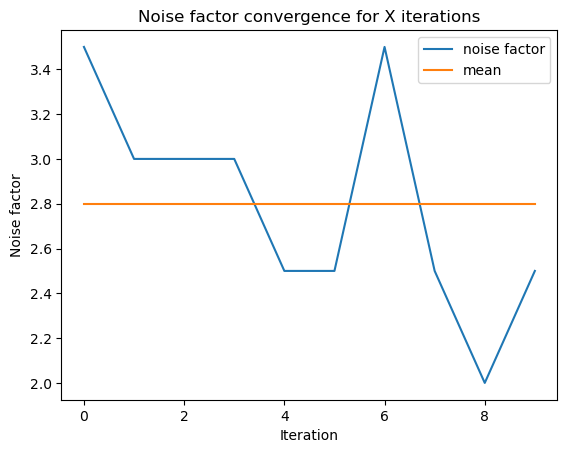

In [ ]:
plt.plot(noise_factor,label='noise factor')
plt.plot(np.ones(len(noise_factor))*np.mean(noise_factor),label='mean')
plt.xlabel('Iteration')
plt.ylabel('Noise factor')
plt.title('Noise factor convergence for X iterations')
plt.legend()

mean SNR for 284.7155907047602


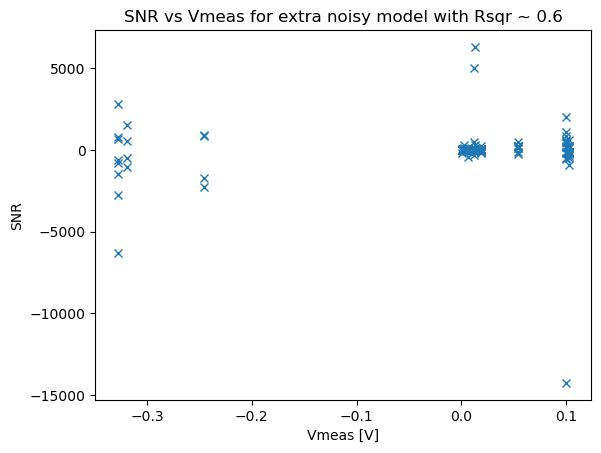

In [ ]:
%matplotlib inline
SNR_arr = np.array(elec_data_sim)/np.array(elec_data_er_en)
plt.plot(elec_data_sim, SNR_arr, 'x')
plt.xlabel('Vmeas [V]')
plt.ylabel('SNR')
plt.title(f'SNR vs Vmeas for extra noisy model with Rsqr ~ {r_sqr_thresh}')
# plt.xlim(0,0.5)
# plt.ylim(-10,10)
print(f"mean SNR for {np.mean(abs(SNR_arr))}")

##### 3.1 Compare through Isrc values and their Rsqr values

In [ ]:
elec_data_homg_l['voltage [V]'][0:num_elecs**2]

0     -0.327000
1      0.099800
2      0.013500
3      0.002940
4      0.006320
         ...   
251    0.000842
252    0.003250
253    0.012100
254    0.102000
255   -0.245000
Name: voltage [V], Length: 256, dtype: float64

In [ ]:
%matplotlib inline
# %matplotlib qt

i_src_arr = [100e-6, 500e-6, 1e-3, 1.25e-3, 1.5e-3, 2e-3, 5e-3]
i_src_str_arr = ['100uA', '500uA', '1mA', '1.25mA', '1.5mA','2mA','5mA']
nplc_str = '0.02'
rsqr_isrc_arr = []

for i in range(len(i_src_arr)):
    i_src = i_src_arr[i]
    i_src_str = i_src_str_arr[i]

    # INPUT phantom mesh .cir netlist files:
    resmeshpcb_2k2 = esim.ErtSim(r'..\KiCAD_scripting\Kicad_netlist_pyspice_sim\resistor_network_2k2.cir', i_src, num_elecs) #add 'r' before file string
    resmeshpcb_2k2_anom_3k3 = esim.ErtSim(r'..\KiCAD_scripting\Kicad_netlist_pyspice_sim\resistor_network_3k3_pcb_anom_2k2_bg.cir', i_src, num_elecs)
    sim_data = resmeshpcb_2k2.run_sim()
    sim_data_anom = resmeshpcb_2k2_anom_3k3.run_sim()
    elec_data_sim = resmeshpcb_2k2.get_elec_data()
    # elec_data_sim = elec_data_sim[1:256] + [elec_data_sim[0]] # shift data one
    elec_data_sim_anom = resmeshpcb_2k2_anom_3k3.get_elec_data()
    # elec_data_sim_anom = elec_data_sim_anom[1:256] + [elec_data_sim_anom[0]] # shift data one

    # INPUT raw ERT voltage measurement sequence:
    #   note: length of these changes file to file
    raw_homg_data_V = f"../PCB_MUX/data/res_mesh_2k2_{i_src_str}_nplc{nplc_str}.csv" # res mesh (2k2) reading at using 1mA adj pattern
    raw_anom_data_V = f"../PCB_MUX/data/res_mesh_2k2_3k3_anom_{i_src_str}_nplc{nplc_str}.csv" # res mesh (2k2 + 3k3 bg anom) reading at using 1mA adj pattern
    elec_data_homg_l = pd.read_csv(raw_homg_data_V,skiprows=1)
    elec_data_homg_l['voltage [V]'][1:-1] = elec_data_homg_l['voltage [V]'][0:-2] # shift all readings by one
    elec_data_homg_l['voltage [V]'][0] = elec_data_homg_l['voltage [V]'][num_elecs**2]
    elec_data_anom_l = pd.read_csv(raw_anom_data_V,skiprows=1) 
    elec_data_anom_l['voltage [V]'][1:-1] = elec_data_anom_l['voltage [V]'][0:-2] # shift all readings by one
    elec_data_anom_l['voltage [V]'][0] = elec_data_anom_l['voltage [V]'][num_elecs**2]

    # Simulation reconstruction
    print("Running EIDORS inverse solver... 1")
    recon_fem_obj_sim = ml_eng.square_recon(matlab.double(elec_data_sim), matlab.double(elec_data_sim_anom))
    print("Solved!")
    elem_data_sim, nodes, elems = ml2py_fem(recon_fem_obj_sim)
    # Real reconstruction
    print("Running EIDORS inverse solver... 2")
    recon_fem_obj_r = ml_eng.square_recon(matlab.double(elec_data_homg_l['voltage [V]'][0:num_elecs**2]), matlab.double(elec_data_anom_l['voltage [V]'][0:num_elecs**2]))
    print("Solved!")
    elem_data_r, nodes, elems = ml2py_fem(recon_fem_obj_r)
    # normalise recons
    elem_data_sim_norm = elem_data_sim/np.max(elem_data_sim)
    elem_data_r_norm = elem_data_r/np.max(elem_data_r)
    elem_err_r_sim_norm = elem_data_sim_norm - elem_data_r_norm
    #MSE
    mse_r_sim = np.square(elem_err_r_sim_norm).mean()
    # Rsqr
    rsqr_r_sim = 1 - mse_r_sim/np.var(elem_data_r_norm)
    rsqr_isrc_arr.append(rsqr_r_sim)
    print(f"Isrc:{i_src_str} A, Rsqr:{rsqr_r_sim}")

    

Running EIDORS inverse solver... 1
Solved!
Running EIDORS inverse solver... 2
Solved!
Isrc:100uA A, Rsqr:0.9092543199246369
Running EIDORS inverse solver... 1
Solved!
Running EIDORS inverse solver... 2
Solved!
Isrc:500uA A, Rsqr:0.9915297832095676
Running EIDORS inverse solver... 1
Solved!
Running EIDORS inverse solver... 2
Solved!
Isrc:1mA A, Rsqr:0.9989317867135138
Running EIDORS inverse solver... 1
Solved!
Running EIDORS inverse solver... 2
Solved!
Isrc:1.25mA A, Rsqr:0.9990795176544539
Running EIDORS inverse solver... 1
Solved!
Running EIDORS inverse solver... 2
Solved!
Isrc:1.5mA A, Rsqr:0.9972801160347466
Running EIDORS inverse solver... 1
Solved!
Running EIDORS inverse solver... 2
Solved!
Isrc:2mA A, Rsqr:0.9988730636910675
Running EIDORS inverse solver... 1
Solved!
Running EIDORS inverse solver... 2
Solved!
Isrc:5mA A, Rsqr:0.9993936708453026


In [ ]:
plt.semilogx(i_src_arr,rsqr_isrc_arr)
plt.title(f"Rsqr of reconstructions of varying Isrc with nplc = {nplc_str}")
plt.xlabel("Isrc [A]")
plt.ylabel("Rsqr")

Text(0, 0.5, 'Rsqr')

##### 3.2 What is an acceptable SNR?

TBD...

### 4.0 Real Domain (Circular) Reconstruction

Now that we've investigated SNR for an idealised resistor network now I will run EIT on the real piezoresistive circular domain using similar parameters. 

##### 4.1 CBSR steady state middle push recon.


Running EIDORS inverse solver...
Solved!


C:\Users\rel80\AppData\Local\Temp\ipykernel_29932\2982572779.py:57: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist=xy_lim*5


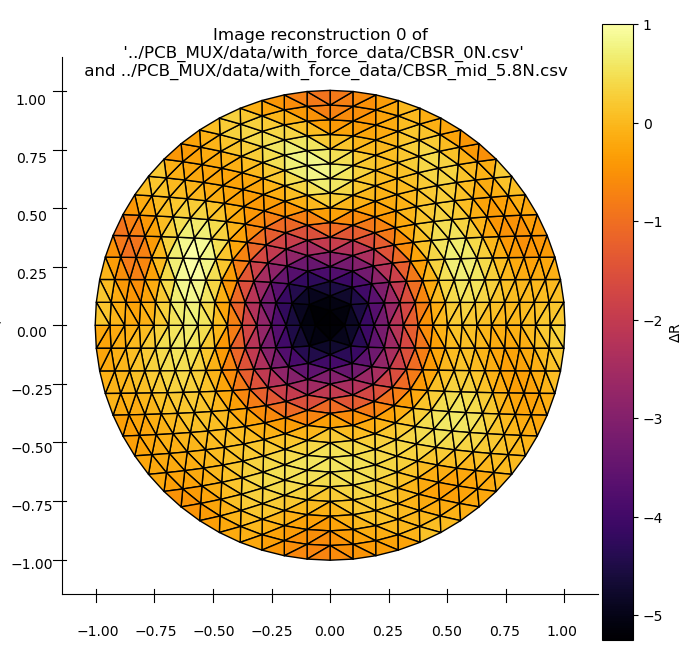

In [5]:
%matplotlib inline
# run a reconstruction on the real data
i_src_str = '1mA'
nplc_str = '0.01'

raw_homg_data_V = f"../PCB_MUX/data/with_force_data/CBSR_0N.csv" # res mesh (2k2) reading at using 1mA adj pattern
raw_anom_data_V = f"../PCB_MUX/data/with_force_data/CBSR_mid_5.8N.csv"

elec_data_homg_l = pd.read_csv(raw_homg_data_V,skiprows=1)
elec_data_homg_l['voltage [V]'][1:-1] = elec_data_homg_l['voltage [V]'][0:-2] # shift all readings by one
elec_data_homg_l['voltage [V]'][0] = elec_data_homg_l['voltage [V]'][num_elecs**2]

elec_data_anom_l = pd.read_csv(raw_anom_data_V,skiprows=1) 
elec_data_anom_l['voltage [V]'][1:-1] = elec_data_anom_l['voltage [V]'][0:-2] # shift all readings by one
elec_data_anom_l['voltage [V]'][0] = elec_data_anom_l['voltage [V]'][num_elecs**2]

# for i in range(len(elec_data_homg_l)//(num_elecs**2)):
for i in range(1):
    if not os.path.isfile(f"cbsr4.1_recon_{i}.pkl"): # check if solver has already generated a solution
        print("Running EIDORS inverse solver...")
        recon_fem_obj_r = ml_eng.circle_recon(matlab.double(elec_data_homg_l['voltage [V]'][i*num_elecs**2:(i+1)*num_elecs**2]), matlab.double(elec_data_anom_l['voltage [V]'][0:256])) # using simulated anomaly b/c real resistor mesh has defect
        print("Solved!")
        elem_data, nodes, elems = ml2py_fem(recon_fem_obj_r)
        save_recon(elem_data, nodes, elems, f"cbsr4.1_recon_{i}")
    else:
        elem_data = 0
        nodes = 0
        elems = 0

    # test load .pkl file
    elem_data, nodes, elems = load_recon(elem_data, nodes, elems, f"cbsr4.1_recon_{i}")
    # normalise
    elem_data_norm = elem_data/np.max(elem_data)

    # plot 
    plot_fem(elem_data_norm, nodes, elems,title=f"Image reconstruction {i} of \n '{raw_homg_data_V}' \n and {raw_anom_data_V}")


#### 4.2 CBSR steady state top push

Push at (x,y) = (0,0.7)

*rotated 2 $\pi$ / 32 on CFA setup*

In [1]:
%matplotlib inline
# run a reconstruction on the real data
i_src_str = '1mA'
nplc_str = '0.01'

raw_homg_data_V = f"../black_sensor/pcb-firmware/pcb_mux/CBSR_0N_2.csv" # res mesh (2k2) reading at using 1mA adj pattern
raw_anom_data_V = f"../black_sensor/pcb-firmware/pcb_mux/CBSR_top_196g.csv"

elec_data_homg_l = pd.read_csv(raw_homg_data_V,skiprows=1)
elec_data_homg_l['voltage [V]'][1:-1] = elec_data_homg_l['voltage [V]'][0:-2] # shift all readings by one
elec_data_homg_l['voltage [V]'][0] = elec_data_homg_l['voltage [V]'][num_elecs**2]

elec_data_anom_l = pd.read_csv(raw_anom_data_V,skiprows=1) 
elec_data_anom_l['voltage [V]'][1:-1] = elec_data_anom_l['voltage [V]'][0:-2] # shift all readings by one
elec_data_anom_l['voltage [V]'][0] = elec_data_anom_l['voltage [V]'][num_elecs**2]

# for i in range(len(elec_data_homg_l)//(num_elecs**2)):
for i in range(1):
    if not os.path.isfile(f"cbsr4.2_recon_{i}.pkl"): # check if solver has already generated a solution
        print("Running EIDORS inverse solver...")
        recon_fem_obj_r = ml_eng.circle_recon(matlab.double(elec_data_homg_l['voltage [V]'][i*num_elecs**2:(i+1)*num_elecs**2]), matlab.double(elec_data_anom_l['voltage [V]'][0:256])) # using simulated anomaly b/c real resistor mesh has defect
        print("Solved!")
        elem_data, nodes, elems = ml2py_fem(recon_fem_obj_r)
        save_recon(elem_data, nodes, elems, f"cbsr4.2_recon_{i}")
    else:
        elem_data = 0
        nodes = 0
        elems = 0

    # test load .pkl file
    elem_data, nodes, elems = load_recon(elem_data, nodes, elems, f"cbsr4.2_recon_{i}")
    # normalise
    elem_data_norm = elem_data/np.max(elem_data)

    # plot 
    plot_fem(elem_data_norm, nodes, elems,title=f"Image reconstruction {i} of \n '{raw_homg_data_V}' \n and {raw_anom_data_V}")


NameError: name 'pd' is not defined

# Part C - Checking reconstruction feasibility

This part involves checking the SNR for a piezoresistive material to ensure that the SNR is lower than that seen when obtaining a 'bad' Rsqr value (currently defined as <60%)

First we iterate through multiple Isrc values on the real DUT to get several SNR values

In [ ]:
%matplotlib inline
# %matplotlib qt

i_src_arr = [100e-6, 500e-6, 1e-3, 1.25e-3, 1.5e-3, 2e-3]
i_src_str_arr = ['100uA', '500uA', '1mA', '1.25mA', '1.5mA','2mA']
nplc_str = '0.01'
mse_isrc_homg_dut_arr = []
snr_min_isrc_homg_dut_arr = []
snr_isrc_homg_dut_arr_l = []
std_isrc_homg_dut_arr = []

for i in range(len(i_src_arr)):
    i_src = i_src_arr[i]
    i_src_str = i_src_str_arr[i]

    # INPUT raw ERT voltage measurement sequence:
    #   note: length of these can changes file to file
    filename = "CBSR_dut_test_sweep"
    raw_homg_data_V = f"../PCB_MUX/data/{filename}_{i_src_str}_nplc{nplc_str}.csv" # res mesh (2k2) reading at using 1mA adj pattern
    elec_data_homg_l = pd.read_csv(raw_homg_data_V,skiprows=1)
    elec_data_homg_l['voltage [V]'][1:-1] = elec_data_homg_l['voltage [V]'][0:-2] # shift all readings by one
    elec_data_homg_l['voltage [V]'][0] = elec_data_homg_l['voltage [V]'][num_elecs**2]

    print(f"for Isrsc = {i_src_str}")

    # homogeneous error plots -
    elec_cycles_homg = len(elec_data_homg_l['voltage [V]'])//num_elecs**2
    # iterate through real homg measurements and calculate error and SNRs
    elec_er_data_homg_l, elec_snr_data_homg_l = calc_vmeas_noise(np.zeros(256), elec_data_homg_l['voltage [V]'], elec_cycles_homg, i_src_str, plot=False)
    print("homogeneous DUT meas")
    elec_mse_homg = sum(np.array(elec_er_data_homg_l)**2)/len(elec_er_data_homg_l)
    mse_isrc_homg_dut_arr.append(elec_mse_homg)
    print("MSE=%.2e" % elec_mse_homg)
    snr_min_isrc_homg_dut_arr.append(np.min(elec_snr_data_homg_l))
    snr_isrc_homg_dut_arr_l.append(elec_snr_data_homg_l)
    print("SNR_min=%.2e, SNR_mean=%.2e" % (np.min(elec_snr_data_homg_l),np.mean(elec_snr_data_homg_l)))
    data_homg_mean, data_homg_std = stats.norm.fit(elec_er_data_homg_l)
    std_isrc_homg_dut_arr.append(data_homg_std)
    print("err_mean = %.2e V, err_std = %.2e" % (data_homg_mean,data_homg_std))
    plt.show()

for Isrsc = 100uA
num of elec cycles 10
homogeneous DUT meas
MSE=2.83e-08
SNR_min=1.83e+00, SNR_mean=inf
err_mean = -1.44e-06 V, err_std = 1.68e-04
for Isrsc = 500uA
num of elec cycles 10
homogeneous DUT meas
MSE=2.77e-08
SNR_min=8.11e+00, SNR_mean=4.15e+03
err_mean = 1.02e-06 V, err_std = 1.66e-04
for Isrsc = 1mA
num of elec cycles 10
homogeneous DUT meas
MSE=1.48e-06
SNR_min=1.38e+01, SNR_mean=6.73e+12
err_mean = 1.73e-05 V, err_std = 1.22e-03
for Isrsc = 1.25mA
num of elec cycles 10
homogeneous DUT meas
MSE=2.33e-06
SNR_min=1.74e+01, SNR_mean=3.92e+03
err_mean = 2.91e-05 V, err_std = 1.52e-03
for Isrsc = 1.5mA
num of elec cycles 10
homogeneous DUT meas
MSE=5.89e-06
SNR_min=1.70e+01, SNR_mean=3.04e+03
err_mean = 4.24e-05 V, err_std = 2.43e-03
for Isrsc = 2mA
num of elec cycles 10
homogeneous DUT meas
MSE=2.37e-05
SNR_min=2.64e+01, SNR_mean=1.87e+03
err_mean = 8.69e-05 V, err_std = 4.87e-03


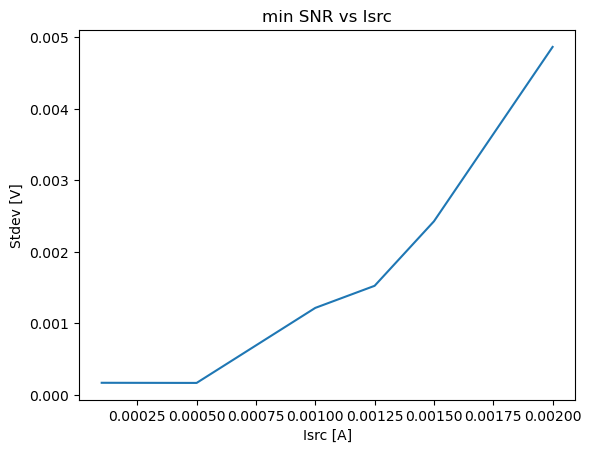

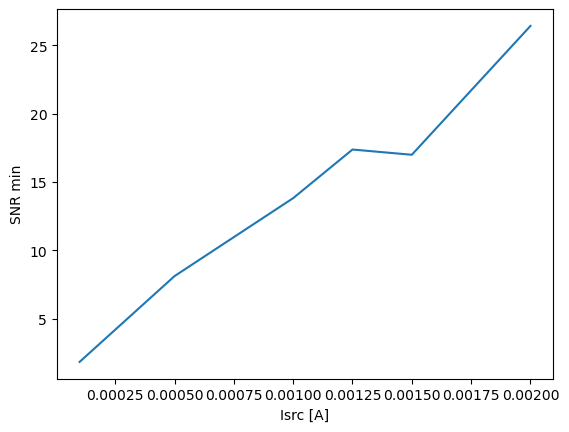

In [ ]:
# %matplotlib qt
%matplotlib inline
plt.figure()
plt.title("Stdev vs Isrc")
plt.plot(i_src_arr,std_isrc_homg_dut_arr)
plt.xlabel('Isrc [A]')
plt.ylabel('Stdev [V]')
plt.title("min SNR vs Isrc")
plt.figure()
plt.plot(i_src_arr,snr_min_isrc_homg_dut_arr)
plt.xlabel('Isrc [A]')
plt.ylabel('SNR min')
plt.show()

**Run animation of dynamaic CBSR test data**

In [ ]:
%matplotlib inline
# run a reconstruction on the real data
i_src_str = '1mA'
nplc_str = '0.01'

raw_homg_data_V = f"../PCB_MUX/data/with_force_data/.csv" # res mesh (2k2) reading at using 1mA adj pattern
raw_anom_data_V = f"../black_sensor/pcb-firmware/pcb_mux/.csv"

elec_data_homg_l = pd.read_csv(raw_homg_data_V,skiprows=1)
elec_data_homg_l['voltage [V]'][1:-1] = elec_data_homg_l['voltage [V]'][0:-2] # shift all readings by one
elec_data_homg_l['voltage [V]'][0] = elec_data_homg_l['voltage [V]'][num_elecs**2]

elec_data_anom_l = pd.read_csv(raw_anom_data_V,skiprows=1) 
elec_data_anom_l['voltage [V]'][1:-1] = elec_data_anom_l['voltage [V]'][0:-2] # shift all readings by one
elec_data_anom_l['voltage [V]'][0] = elec_data_anom_l['voltage [V]'][num_elecs**2]

# for i in range(len(elec_data_homg_l)//(num_elecs**2)):
for i in range(1):
    if not os.path.isfile(f"cbsr4.2_recon_{i}.pkl"): # check if solver has already generated a solution
        print("Running EIDORS inverse solver...")
        recon_fem_obj_r = ml_eng.circle_recon(matlab.double(elec_data_homg_l['voltage [V]'][i*num_elecs**2:(i+1)*num_elecs**2]), matlab.double(elec_data_anom_l['voltage [V]'][0:256])) # using simulated anomaly b/c real resistor mesh has defect
        print("Solved!")
        elem_data, nodes, elems = ml2py_fem(recon_fem_obj_r)
        save_recon(elem_data, nodes, elems, f"cbsr4.2_recon_{i}")
    else:
        elem_data = 0
        nodes = 0
        elems = 0

    # test load .pkl file
    elem_data, nodes, elems = load_recon(elem_data, nodes, elems, f"cbsr4.2_recon_{i}")
    # normalise
    elem_data_norm = elem_data/np.max(elem_data)

    # plot 
    plot_fem(elem_data_norm, nodes, elems,title=f"Image reconstruction {i} of \n '{raw_homg_data_V}' \n and {raw_anom_data_V}")

In [ ]:
# Put EIT data into a EIDORS readable format (M V_readings, N frames)

# currently we have a stream of data which is just (1 x total_readings)

elec_data_dyn_anim = np.zeros((num_elecs**2,frames))

for frame in range(frames):

    elec_data_dyn_anim[:,frame] = np.transpose(elec_data_dyn_l['voltage [V]'][frame*num_elecs**2:(frame+1)*num_elecs**2])

elec_data_anim_df = pd.DataFrame(elec_data_dyn_anim)

elec_data_anim_df.to_csv('cbsr_dyn1.csv')

# # Complete a reconstruction with DUT homg and anom voltage readings
# print("Running EIDORS inverse solver...")
# recon_fem_obj_cbsr = ml_eng.circle_recon(matlab.double(elec_data_dyn_anim[:,0])) # get the elem and node co-ordinates
# recon_anim_fem_cbsr = ml_eng.circle_recon_stream(matlab.double(elec_data_dyn_anim)) # get the reconstructed elem data stream
# print("Solved!")

# elem_data, nodes, elems = ml2py_fem(recon_fem_obj_cbsr)
# save_recon(elem_data, nodes, elems, "cbsr_dyn")

**Next steps:**
0. Measure the current error
    a. voltage error will be a percentage due to error in the current

1. Measure the noise in the CBSR DUT

    a. test 'homg' CBSR sample MSE, Rsqr, ...? Using the mean value as the reference.

2. Quantify reconstruction quality, by comparing

    a. with expected push location?

    b. with a forward model generated my EIDORS

3. Create function for multi-frame image reconstruction

    i. grab data stream making 'frame_i' = homg and 'frame_i+1' = anom

    ii. run recon

    iii. update plot with recon

    iv. i++

    v. return to 'i.' unless i = i_max

